# V3
## Changements :
- Pré-calculs des SP et SPt stocké dans un dictionnaire possible (non utilisable avec des grosses instances)
- Version agents en ANN/GNN
- fix total wiating time

### UNITES
1 TICK est mit à l'echelle à 1 SECONDE

In [63]:
import networkx as nx
import osmnx as ox
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import shapely
import random
import numpy as np
from IPython.display import clear_output
import math
from mas_transportation_utils import *
#from mas_transportation_utils import all_paths
import rtree
import heapq
from timeit import default_timer as timer

%matplotlib inline
ox.config(log_console=True)
ox.__version__
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

ox.utils.config(bidirectional_network_types=['drive'])

In [64]:
class Agent:
    def __init__(self, unique_id):
        self.is_alive = True
        self.unique_id = unique_id
    
    def update(self) -> None: 
        pass
    
    def decide(self) -> None:
        pass
    
class UserAgent(Agent):
    def __init__(self, unique_id, v_dep, v_arr):
        super().__init__(unique_id)
        self.v_dep = v_dep
        self.v_r = v_dep
        self.v_arr = v_arr
        
        #calcul de la longueur du plus court chemin à l'origine
        ###self.SPL = nx.shortest_path_length(sma.G, source=self.v_dep, target=self.v_arr)
        
    def update(self) -> None:
        pass
    
    def decide(self) -> None:
        pass    

In [65]:
class ContinuousDriverAgent(UserAgent):
    '''pref might be : "length" or "travel_time"'''
    def __init__(self, unique_id, v_dep, v_arr, capacity=3, detour_factor=0, pref_weight='travel_time', test=False):
        super().__init__(unique_id, v_dep, v_arr)
        
        self.dep_time = sma.tick
        
        self.pref_weight = pref_weight
        self.detour_factor = detour_factor
        self.SP = sma.get_SP(self.v_dep, self.v_arr, weight=pref_weight)
        self.SPt = sma.get_SP_value(self.v_dep, self.v_arr, weight='travel_time')
        self.SPd = sma.get_SP_value(self.v_dep, self.v_arr, weight='length')
        self.detour_factor = detour_factor
        
        self.trip = self.SP
        
        
        self.current_pos = dict()
        self.current_pos['node1'] = self.v_dep
        self.current_pos['node2'] = self.trip[1]
        self.current_pos['edge_data'] = sma.G.get_edge_data(self.v_dep, self.trip[1])[0]
        self.current_pos['time'] = 0
        
        self.total_distance=0
        #self.total_distance=self.current_pos['edge_data']['length']
        
        self.c = capacity
        self.l_arr_time = sma.tick + self.SPt + math.ceil(self.SPt*detour_factor) #'''arrondi ?'''
        self.v_r = self.trip[1]
        
        #tableaux du scheduling S
        self.arr = [sma.tick + self.current_pos['edge_data']['travel_time'], self.SPt] #tableau des premières arrivées
        self.ddl = [self.arr[0], self.l_arr_time] #tableau des dernières arrivées
        self.slk = [0, self.ddl[1]-self.arr[1]] #tableau de la marge de temps a chaque étape
        
        self.stops = [self.trip[1], v_arr] #tableau référençant les noeuds avec arrêts obligatoire 
                             #(noeuds de recup et de dépot des passagers et noeud d'arrivé du conducteur)
        self.capacities = [capacity, capacity]
        self.tag_event = False
        
        self.perceptions = [None] #les ellipses, la perception à chaque étape
        self.perceptions.append(self.get_perception_idx(self.v_r, self.v_arr, 1))
        sma.rtree.insert(self.unique_id, self.perceptions[1], (self.unique_id, 1))
        
        self.riders_distance = 0
        #affichage de la progression sur une carte
        self.test = test
        if self.test :
            fig, ax = ox.plot_graph_route(sma.G, self.trip, route_color='y', route_linewidth=6, node_size=0)

    
    def add_rider_to_scheduler(self, rider, r_v1, r_v2, dl_v1, dl_v2, idx1, idx2):
        #on ajoute le passager au scheduler, on met a jour le trip et la capacité
        
        #########checks##############
        if dl_v1 > self.ddl[-1] or dl_v2 > self.ddl[-1]:
            raise Exception("Rider's deadline should be lower than driver's deadline")
            
        if r_v1 == r_v2:
            raise Exception("Driver",self.unique_id,"problème noeud égaux")

        if r_v2 in self.stops and self.stops.index(r_v2) == idx2:
            if self.ddl[self.stops.index(r_v2)] >= dl_v2:
                self.ddl[self.stops.index(r_v2)] = dl_v2
            else: raise Exception("pb driver schedule ajout r_v2")
        else :
            if idx1==idx2 and r_v1 in self.stops and self.stops.index(self.stops[-1]) != idx1: #and self.stops.index(r_v1) == idx1:
                self.stops.insert(idx2+1, r_v2)
                self.ddl.insert(idx2+1, dl_v2)
                self.capacities.insert(idx2+1, self.capacities[idx2])
                                                     
            else:
                self.stops.insert(idx2, r_v2)
                self.ddl.insert(idx2, dl_v2)
                self.capacities.insert(idx2, self.capacities[idx2-1])
            
        if r_v1 in self.stops :
            if self.ddl[self.stops.index(r_v1)] >= dl_v1:
                self.ddl[self.stops.index(r_v1)] = dl_v1 
            else: 
                print("pb driver schedule ajout r_v1?")
                self.stops.insert(idx1, r_v1)
                self.ddl.insert(idx1, dl_v1)
                self.capacities.insert(idx1, self.capacities[idx1-1])
                d_id = self.unique_id
                print("arr",sma.getAgentFromId(d_id).arr)
                print("ddl",sma.getAgentFromId(d_id).ddl)
                print("slk",sma.getAgentFromId(d_id).slk)
                print("cap",sma.getAgentFromId(d_id).capacities)
                print("perc",sma.getAgentFromId(d_id).perceptions)
                print("stops",sma.getAgentFromId(d_id).stops)
                print("trip",sma.getAgentFromId(d_id).trip)
                print("v_r",sma.getAgentFromId(d_id).current_pos)
                print("v_arr",sma.getAgentFromId(d_id).v_arr)
                print("v_dep",sma.getAgentFromId(d_id).v_dep)
            
        else:
            self.stops.insert(idx1, r_v1)
            self.ddl.insert(idx1, dl_v1)
            self.capacities.insert(idx1, self.capacities[idx1-1])
            
        for i in np.arange(idx1,idx2):
            self.capacities[i]-=1        
        #puis on recalcule le chemin le plus court et la marge (skl = slack time)
        
        #pour le premier on se base sur le noeud courant
        self.arr = [self.arr[0]]
        dif = [self.ddl[0] - self.arr[0]]#normalement = à 0
        if self.ddl[0] - self.arr[0] < 0:
            raise Exception("Problème insertion conducteur",self.unique_id,"avec ddl",self.ddl[0],"et arr",self.arr[0],"premiere indice tableau/position courrante")
        
        #self.arr.append(sma.tick + (self.current_pos['edge_data']['travel_time'] - self.current_pos['time']) + compute_shortest_path_time(ox.shortest_path(sma.G, self.v_r, self.stops[0], weight=self.pref_weight)))
        #dif.append(self.ddl[0] - self.arr[0])
        
        
        for i in range(len(self.stops)-1):
            self.arr.append(self.arr[i] + sma.get_SP_value(self.stops[i], self.stops[i+1], weight="travel_time"))
            dif.append(self.ddl[i+1] - self.arr[i+1])
        
        #calcul marge dépendante des marges suivantes
        self.slk = []
        for i in range(len(dif)):
            self.slk.append(np.min(dif[i:]))
        
#         if rider != None:
#             self.riders_distance+= rider.SPd
        self.tag_event = True
        self.update()
    
    def get_all_perceptions(self):
        perceptions = []
        perceptions.append(None)
            
        for i in range(len(self.stops)-1):
            if self.slk[i+1]==0:
                perceptions.append(None)
            else:
                perceptions.append(self.get_perception_idx(self.stops[i], self.stops[i+1], i+1))
    
        return perceptions
                                    
    def get_perception_idx(self, orig, dest, stop_idx):
        slack_time = self.slk[stop_idx]
        
        SP = sma.get_SP(orig, dest, weight=self.pref_weight)
        min_lat = False
        max_lat = False
        min_lon = False
        max_lon = False
        for node in SP:
            lat = sma.G.nodes[node]['y']
            lon = sma.G.nodes[node]['x']
            if lat < min_lat or not min_lat :
                min_lat = lat
            if lat > max_lat or not max_lat:
                max_lat = lat
            if lon < min_lon or not min_lon:
                min_lon = lon
            if lon > max_lon or not max_lon :
                max_lon = lon
                
        if slack_time > 0:
            speed_mps = sma.speed / 3.6 #il faudra a terme faire une moyenne sur la vitesse par exemple
            meters = speed_mps * slack_time
            earth = 6378.137  #radius of the earth in kilometer
            pi = math.pi 
            m = (1 / ((2 * pi / 360) * earth)) / 1000  #1 meter in degree


            min_lat = min_lat - (meters*m) 
            max_lat = max_lat + (meters*m) 
            min_lon = min_lon - (meters*m) / math.cos(min_lat * (pi / 180))
            max_lon = max_lon + (meters*m) / math.cos(max_lat * (pi / 180))
        
        #il ne faut pas dépasser les limites du graphe
        min_lat = max(min_lat, sma.min_lat)
        max_lat = min(max_lat, sma.max_lat)
    
        min_lon = max(min_lon, sma.min_lon)
        max_lon = min(max_lon, sma.max_lon)

        perception = (min_lon, min_lat, max_lon, max_lat)    
        
        return perception
        
        
    def update_perception(self):
        for p in self.perceptions:
            if p != None:
                sma.rtree.delete(self.unique_id, p)
        if self.is_alive:    
            new_perception=self.get_all_perceptions()
            for p in new_perception:
                if p != None:
                    sma.rtree.insert(self.unique_id, p, obj=(self.unique_id, new_perception.index(p)))

            self.perceptions = new_perception
        
                                    
        
                                    
    
#     def get_perception_set_node(self):
#         return set([item for sublist in self.perceptions for item in sublist])
    
#     def algo_recu_percep(self, current_node, visited, perception, max_weight):
#         for succ in G.neighbors(current_node):
#             if succ not in visited :
#                 visited.append(succ)
#                 try: 
#                     if nx.shortest_path_length(sma.G, orig, succ, weight=self.pref_weight) + nx.shortest_path_length(sma.G, succ, dest, weight=self.pref_weight) <= max_weight:
#                         perception.add(succ)
#                         self.algo_recu_percep(succ, visited, perception, max_weight)
#                 except (KeyError, nx.NetworkXNoPath):
#                     pass
            
    def update(self): 
        #a terme, il faudra identifier dans quelles ellipses sont les modifs et modif uniquement là
        if self.tag_event == True:
            self.update_perception()
            self.trip = sma.get_SP(self.v_r, self.stops[1], weight=self.pref_weight)
            self.tag_event = False
    
    def decide(self):
        current_time = self.current_pos['time'] + 1
        if current_time < self.current_pos['edge_data']['travel_time']:
            self.current_pos['time'] = current_time
            
        else :
            reste = current_time - self.current_pos['edge_data']['travel_time']
            self.current_pos = dict()
            self.current_pos['node1'] = self.trip.pop(0)
            try :
                self.current_pos['node2'] = self.trip[0]
            except IndexError :
                d_id = self.unique_id
                print("arr",sma.getAgentFromId(d_id).arr)
                print("ddl",sma.getAgentFromId(d_id).ddl)
                print("slk",sma.getAgentFromId(d_id).slk)
                print("cap",sma.getAgentFromId(d_id).capacities)
                print("perc",sma.getAgentFromId(d_id).perceptions)
                print("stops",sma.getAgentFromId(d_id).stops)
                print("trip",sma.getAgentFromId(d_id).trip)
                print("v_r",sma.getAgentFromId(d_id).current_pos)
                print("v_arr",sma.getAgentFromId(d_id).v_arr)
                print("v_dep",sma.getAgentFromId(d_id).v_dep)
                self.is_alive = False
                self.update_perception()
                
#                 d_trip_time = sma.tick + self.current_pos['edge_data']['travel_time'] - self.current_pos['time'] - self.dep_time
#                 d_trip_length = self.total_distance
#                 sma.data['d_trip_time'].append(d_trip_time)
#                 sma.data['d_trip_length'].append(d_trip_length)
#                 sma.data['saved_distance']+=self.SPd-self.total_distance
                return
                
            #print(self.current_pos['node1'], self.current_pos['node2'])
            #print(sma.G.get_edge_data(self.current_pos['node1'], self.current_pos['node2']))
            self.current_pos['edge_data'] = sma.G.get_edge_data(self.current_pos['node1'], self.current_pos['node2'])[0]
            self.current_pos['time'] = reste
            self.v_r = self.current_pos['node2']
            self.total_distance+=self.current_pos['edge_data']['length']
            
            if self.v_r == self.v_arr and self.stops[1]==self.v_arr and len(self.stops)<=2:
                if self.test :
                    clear_output(wait=True)
                    fig, ax = ox.plot_graph_route(sma.G, [self.trip[-1]], route_color='y', route_linewidth=6, node_size=0)
                    
                self.is_alive = False
                self.update_perception()
                
                d_trip_time = sma.tick + self.current_pos['edge_data']['travel_time'] - self.current_pos['time'] - self.dep_time
                d_trip_length = self.total_distance
                sma.data['d_trip_time'].append(d_trip_time)
                sma.data['d_trip_length'].append(d_trip_length)
                sma.data['saved_distance']+=self.SPd-self.total_distance
                
                if sma.verbose == True:
                    print("Driver",self.unique_id,"arrived")
                
                
            else :
#                 if sma.verbose == True:
#                     print("Driver",self.unique_id,"passing through node",self.current_pos['node2'])
                if self.test :
                    clear_output(wait=True)
                    fig, ax = ox.plot_graph_route(sma.G, self.trip, route_color='y', route_linewidth=6, node_size=0)
                                                       
                                    
                #si le prochain noeud est un arret prévu                    
                if self.current_pos['node2'] == self.stops[1]:
                                    
                    self.arr.pop(0) 
                    self.slk.pop(1)
                    
                                    
                    self.ddl.pop(0)
                    self.ddl[0]=self.arr[0]
                    
                    self.capacities.pop(0)
                    
#                     if self.perceptions[1] != None:
#                         sma.rtree.delete(self.unique_id, self.perceptions[1])
#                     self.perceptions.pop(1)
                    
                    #print("d passe par un stop ?")
                                    
                    self.stops.pop(0)
                    self.update_perception()
                    
                    
                    self.trip = sma.get_SP(self.v_r, self.stops[1], weight=self.pref_weight)
                        
                    
                    
                else :
                    self.arr[0]+= self.current_pos['edge_data']['travel_time'] - self.current_pos['time']
                    self.ddl[0]=self.arr[0]
                    self.stops[0]=self.v_r
                    #self.trip = ox.shortest_path(sma.G, self.v_r, self.stops[1], weight=self.pref_weight)
                
                
                
                
                

In [66]:
class SMA:
    def __init__(self, verbose=False, verbose2=False, place='Piedmont, California, USA', speed=50, show_graph=False, hop='mhop', pre_comput_SP=False):
        self.tick=0 #1 tick = 1 seconde
        self.resetTicks()
        
        if hop in ['mhop','shop','nohop']:
            self.hop = hop
        else :
            raise Exception("hop parameters is either : mhop, shop or nohop")
            
        
        if place=='grid':
            north, south, east, west = 37.79, 37.78, -122.41, -122.43
            self.min_lat, self.min_lon, self.max_lat, self.max_lon = south, west, north ,east 
            
        elif isinstance(place, list):
            west, south, east, north = place
            self.min_lat, self.min_lon, self.max_lat, self.max_lon = south, west, north ,east 
        
        else:
            gdf = ox.geocode_to_gdf(place) 
            # get the street network within this bounding box
            west, south, east, north = list(gdf.bounds.iloc[0])
            self.min_lat, self.min_lon, self.max_lat, self.max_lon = south, west, north ,east 
            #self.bbox = (self.min_lon, self.min_lat, self.max_lon, self.max_lat)
            
        self.G = ox.graph_from_bbox(north, south, east, west, network_type='drive')
        
#         #filter deadends
#         deadends = []
#         for node in list(self.G.nodes):
#             if self.G.nodes[node]['street_count']==1:
#                 deadends.append(node)
#         print(deadends)
#         self.G.remove_nodes_from(deadends)
        
        if show_graph:
            fig, ax = ox.plot_graph(self.G, figsize=(20, 20),  node_size=20)
        self.speed = speed
        # hwy_speeds = {'residential': 30,
        #               'secondary': 50,
        #               'tertiary': 70}

        hwy_speeds = {'residential': speed,
                      'primary':speed,
                      'secondary': speed,
                      'tertiary': speed,
                      'motorway': speed,
                      'trunk': speed,
                      'trunk_link': speed,
                      'motorway_link':speed,
                      'primary_link':speed,
                      'secondary_link':speed,
                      'tertiary_link':speed,
                      'road':speed}
        
        for o,d,_ in self.G.edges:
            self.G.get_edge_data(o,d)[0]['speed_kph'] = speed

        self.G = ox.add_edge_speeds(self.G, hwy_speeds, fallback=50, precision=0)
        #temps arrondis
        self.G = ox.add_edge_travel_times(self.G, precision=0)
        
        #dictionnaire des agents par type
        self.agentTypeIdDict = {}
        self.agentTypeIdDict["drivers"] = []
        self.agentTypeIdDict["riders"] = []
        self.agentTypeIdDict["tsas"] = []
        self.agentTypeIdDict["tgas"] = []
        
        #dictionnaire des agents par id
        self.agentDict = {}
        
        #arbre d'indexation spatiale R-TREE
        self.rtree = rtree.index.Index()
        
        #précalcul des chemins les plus courts si choisi, et de leurs valeurs sous la forme : dict{node,[dict{value},dict{path}]}
        self.pre_comput_SP = pre_comput_SP
        if self.pre_comput_SP:
            if verbose:
                print("Precomputing Shortests paths...")
            self.spt_dict = dict(nx.all_pairs_dijkstra(self.G, weight="travel_time"))
            self.spd_dict = dict(nx.all_pairs_dijkstra(self.G, weight="length"))
            if verbose:
                print("Done !")
        
        #self.G = None
        self.verbose = verbose
        self.verbose2 = verbose2
        
        
        ####DATA####
        self.data = dict()
        self.data['d_trip_time'] = []
        self.data['d_trip_length'] = []
        self.data['r_total_waiting_time'] = []
        self.data['r_start_waiting_time'] = []
        self.data['r_trip_time'] = []
        self.data['r_saved_time'] = []
        self.data['r_nb_unmatched'] = 0
        self.data['r_nb_matched'] = 0
        self.data['mhop_count'] = 0
        self.data['shop_count'] = 0
        self.data['saved_distance'] = 0
        self.data['nb_tsf'] = []
    
    def resetTicks(self):
        self.tick=0
          
    def setRoadGraph(self,graph):
        self.G = graph
        
    def addAgent(self,ag):
        self.agentDict[ag.unique_id] = ag
        if "RiderAgent" in ag.__class__.__name__:
            self.agentTypeIdDict["riders"].append(ag.unique_id)
        elif "DriverAgent" in ag.__class__.__name__:
            self.agentTypeIdDict["drivers"].append(ag.unique_id)
        elif "TransportServiceAgent" in ag.__class__.__name__:
            self.agentTypeIdDict["tsas"].append(ag.unique_id)
        elif "TransportGeneratorAgent" in ag.__class__.__name__:
            self.agentTypeIdDict["tgas"].append(ag.unique_id)
        else: raise Exception(ag.__class__.__name__,"is a wrong type of agent.")
            
            
    def getAgentFromId(self, unique_id):
        return self.agentDict[unique_id]
    
    def getRiders(self):
        R = []
        for r in self.agentTypeIdDict['riders']:
            R.append(self.agentDict[r])
        return R
        
    def getDrivers(self):
        D = []
        for d in self.agentTypeIdDict['drivers']:
            D.append(self.agentDict[d])
        return D
        
    def getTSAs(self):
        TSA = []
        for tsa in self.agentTypeIdDict['tsas']:
            TSA.append(self.agentDict[tsa])
        return TSA
    
    def getTGAs(self):
        TGA = []
        for tga in self.agentTypeIdDict['tgas']:
            TGA.append(self.agentDict[tga])
        return TGA
    
    #recupere chemin le plus court précalculé
    def get_SP(self, orig, dest, weight):
        if self.pre_comput_SP:
            if weight == "travel_time":
                return self.spt_dict[orig][1][dest]
            elif weight == "length":
                return self.spd_dict[orig][1][dest]
            else: raise NameError('weigth should be either \'travel_time\' or \'length\'.')
        else :
            return nx.shortest_path(self.G, orig, dest)
            
    #recupere la valeur du chemin le plus court précalculé
    def get_SP_value(self, orig, dest, weight):
        if self.pre_comput_SP:
            if weight == "travel_time":
                return self.spt_dict[orig][0][dest]
            elif weight == "length":
                return self.spd_dict[orig][0][dest]
            else: raise NameError('weigth should be either \'travel_time\' or \'length\'.')
        else :
            if weight == "travel_time":
                return compute_shortest_path_time(self.G, nx.shortest_path(self.G,orig,dest))
            elif weight == "length":
                return compute_shortest_path_distance(self.G, nx.shortest_path(self.G, orig,dest))
    
    

    def run(self,rounds=None):
        if rounds==None:
            #on s'arrete si tout les passagers ou tout les conducteurs sont arrivés
            self.runOnce()
            while len([agent for agent in sma.agentDict.values() if ("RiderAgent" in agent.__class__.__name__)]) > 0 and len([agent for agent in sma.agentDict.values() if ("DriverAgent" in agent.__class__.__name__)]) > 0:
                self.runOnce()
            #print("Finished in",self.tick,"ticks")
        
        else :
            #génération classique
            for i in range(0,rounds):
                self.runOnce()

    def runOnce(self):
        self.tick+=1
        #random.shuffle(self.agentList)
        for ag in self.agentDict.values() :
            #print(ag.unique_id)
            ag.update()
            ag.decide()
        
        #phase de nettoyage des agents morts
        for ag in self.agentDict.copy().values():
            if ag.is_alive == False:
                if "RiderAgent" in ag.__class__.__name__:
                    self.agentTypeIdDict["riders"].remove(ag.unique_id)
                elif "DriverAgent" in ag.__class__.__name__:
                    self.agentTypeIdDict["drivers"].remove(ag.unique_id)
                elif "TransportServiceAgent" in ag.__class__.__name__:
                    self.agentTypeIdDict["tsas"].remove(ag.unique_id)
                elif "TransportGeneratorAgent" in ag.__class__.__name__:
                    self.agentTypeIdDict["tgas"].remove(ag.unique_id)
                else: raise Exception(ag.__class__.__name__,"is a wrong type of agent, even if diying.")
                
                self.agentDict.pop(ag.unique_id)
                
                
        if self.verbose == True:      
            print("tick",str(self.tick),"ended")

### Test 1: un conducteur va vers sa destination

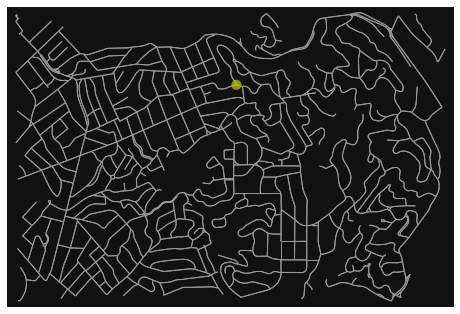

In [67]:
rounds = 500
sma = SMA()
G = sma.G
sma.tick = 0
orig = list(G)[1]
dest = list(G)[120]
#d1 = ContinuousDriverAgent(1, orig, dest, detour=0.5, pref_weight='length',test=True)
d1 = ContinuousDriverAgent(2, orig, dest, detour_factor=0.5, pref_weight='travel_time',test=True)
sma.addAgent(d1)
for _ in range(rounds):
    sma.runOnce()
    #print(sma.rtree)
    #print(list(sma.rtree.intersection(d1.perceptions[1],objects='raw')))

### Test 2: un conducteur prends en charge une requete fictive (aucun test de faisabilité)

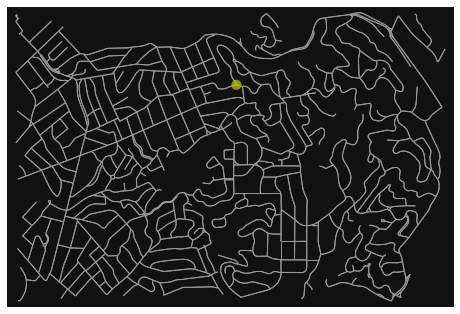

In [68]:
rounds = 1000
sma = SMA()
G = sma.G
sma.tick = 0
orig = list(G)[1]
dest = list(G)[120]
#d1 = ContinuousDriverAgent(1, orig, dest, detour=0.5, pref_weight='length',test=True)
d1 = ContinuousDriverAgent(2, orig, dest, detour_factor=0.5, pref_weight='travel_time',test=True)
sma.addAgent(d1)
for _ in range(30):
    sma.runOnce()

p_cs = d1.perceptions[1]
p_node_cs = set(ox.truncate.truncate_graph_bbox(G, p_cs[3], p_cs[1], p_cs[2], p_cs[0], truncate_by_edge=False, retain_all=False).nodes)
r1, r2 = random.sample(p_node_cs,2)
d1.add_rider_to_scheduler(None, r1, r2, 60, 100, 1, 1)

for _ in range(1000):
    sma.runOnce()

In [69]:
class RiderAgent(UserAgent):
    '''pref might be : "length" or "travel_time"'''
    def __init__(self, unique_id, v_dep, v_arr, detour_factor=0, waiting_time=5, pref_weight='travel_time'):
        super().__init__(unique_id, v_dep, v_arr)
        self.dep_time = sma.tick
        self.max_wt = waiting_time * 60 #minutes vers secondes
        self.v_dep = v_dep
        self.v_arr = v_arr
        self.pref_weight = pref_weight
        self.detour_factor = detour_factor
        self.SP = sma.get_SP(self.v_dep, self.v_arr, weight=pref_weight)
        self.SPt = sma.get_SP_value(self.v_dep, self.v_arr, weight="travel_time")
        self.SPd = sma.get_SP_value(self.v_dep, self.v_arr, weight="length")
        self.detour_factor = detour_factor
        self.arr = sma.tick + self.SPt
        self.l_arr_time = sma.tick + self.max_wt + self.SPt + math.ceil(self.SPt*self.detour_factor) #'''arrondi ?'''
        self.l_dep_time = sma.tick + self.max_wt
        self.perception = None #les ellipses, la perception à chaque étape
#         self.wt_perception = None
        self.wt = 0
        self.checked_couples = set() #on stock les couples de conducteurs déja vérifiés
        self.checked_drivers = set()
        self.v_dep_lat = sma.G.nodes[self.v_dep]['y']
        self.v_dep_lon = sma.G.nodes[self.v_dep]['x']
        self.v_arr_lat = sma.G.nodes[self.v_arr]['y']
        self.v_arr_lon = sma.G.nodes[self.v_arr]['x']
        
        
        self.served = False
    
    def get_perception_trip(self):
        slack_time = self.SPt*self.detour_factor
        # ou 
        #slack_time = self.l_arr_time - self.max_wt #le wt n'est pas vraiment du détour ?
        
        SP = sma.get_SP(self.v_dep, self.v_arr, weight=self.pref_weight)
        min_lat = False
        max_lat = False
        min_lon = False
        max_lon = False
        for node in SP:
            lat = sma.G.nodes[node]['y']
            lon = sma.G.nodes[node]['x']
            if lat < min_lat or not min_lat :
                min_lat = lat
            if lat > max_lat or not max_lat:
                max_lat = lat
            if lon < min_lon or not min_lon:
                min_lon = lon
            if lon > max_lon or not max_lon :
                max_lon = lon
                
        if slack_time > 0:
            speed_mps = sma.speed / 3.6 #il faudra a terme faire une moyenne sur la vitesse par exemple
            meters = speed_mps * slack_time
            earth = 6378.137  #radius of the earth in kilometer
            pi = math.pi 
            m = (1 / ((2 * pi / 360) * earth)) / 1000  #1 meter in degree


            min_lat = min_lat - (meters*m) 
            max_lat = max_lat + (meters*m) 
            min_lon = min_lon - (meters*m) / math.cos(min_lat * (pi / 180))
            max_lon = max_lon + (meters*m) / math.cos(max_lat * (pi / 180))
            
        #il ne faut pas dépasser les limites du graphe
        min_lat = max(min_lat, sma.min_lat)
        max_lat = min(max_lat, sma.max_lat)
    
        min_lon = max(min_lon, sma.min_lon)
        max_lon = min(max_lon, sma.max_lon)

        perception = (min_lon, min_lat, max_lon, max_lat)    
        
        return perception
        
        
    
        
        
        
    def update(self):
        if not self.served:
#             if sma.verbose:
#                 print("Rider",self.unique_id,"looking for a ride")
            self.perception = self.get_perception_trip()
            #self.wt_perception = self.get_perception_wt()

            #phase candidats approché
            #set conducteur avec le noeud de départ dans leur perception
            Q1 = list(sma.rtree.intersection((self.v_dep_lon,self.v_dep_lat,self.v_dep_lon,self.v_dep_lat),objects="raw"))
            #print(Q1)
            
            #si aucun, on ne pourra pas bouger de toute façon
            if not Q1 :
                return
            
            #set conducteur dont perception dans la zone d'attente
            #d_on_wt = sma.rtree.intersection((self.wt_perception),objects="raw")
            
            #set conducteur dont perception est dans perception passager
            Q2 = list(sma.rtree.intersection((self.perception),objects="raw"))
            #print(Q2)
            if not Q2 :
                return
            #set conducteur dont noeud d'arrivé est dans perception
            Q3 = list(sma.rtree.intersection((self.v_arr_lon,self.v_arr_lat,self.v_arr_lon,self.v_arr_lat),objects="raw"))
            #print(Q3)
            if not Q3 :
                return
            

            
            candidates_s = set()
            cur_d_s = set()
            for d1_id, idx1 in Q1:
                for d2_id, idx2 in Q2:
                    if d1_id == d2_id and idx1 <= idx2:
                        d1 = sma.getAgentFromId(d1_id)
                        candidates_s.add((d1,idx1,idx2))
                        cur_d_s.add(d1_id)
                              
            
            candidates_e = set()
            cur_d_e = set()
            for d2_id, idx2 in Q2:
                for d3_id, idx3 in Q3:
                    if d2_id == d3_id and idx2 <= idx3:
                        d2 = sma.getAgentFromId(d2_id)
                        candidates_e.add((d2,idx2,idx3))
                        cur_d_e.add(d2_id)
                        
            if len(cur_d_s - self.checked_drivers) == 0 and len(cur_d_e - self.checked_drivers) == 0:
                return
#             if sma.verbose:
#                 print("checking riders at start id:",[cand[0].unique_id for cand in candidates_s])   
#                 print("checking riders at end id:",[cand[0].unique_id for cand in candidates_e])   
            
            #objet sous la forme (conducteur1, conducteur2, fitness, temps d'attente au noeud de transfert)
            best_candidate = None
            
            p_node_r = set(ox.truncate.truncate_graph_bbox(sma.G, self.perception[3], self.perception[1], self.perception[2], self.perception[0], truncate_by_edge=False, retain_all=False).nodes)
            wt_transfert = 0
            
            for cand_s in candidates_s:
#                 b_start = timer()
                self.checked_drivers.add(cand_s[0].unique_id)
#                 if sma.verbose:
#                     print(cand_s[0].unique_id)
#                     print(cand_s[0].perceptions)
#                     print(cand_s[2])
                p_cs = cand_s[0].perceptions[cand_s[2]]
                if p_cs[3]==p_cs[1] or p_cs[2]==p_cs[0]:
                    print("oof")
                    continue
#                 start = timer()
                try :
                    p_node_cs = set(ox.truncate.truncate_graph_bbox(sma.G, p_cs[3], p_cs[1], p_cs[2], p_cs[0], truncate_by_edge=False, retain_all=False).nodes)
                    
                except nx.exception.NetworkXPointlessConcept:
                    continue
#                 end = timer()
#                 print(f'elapsed time p_cs truncate: {end - start}')
                    
                
                
                Spt_ds_v1 = sma.get_SP_value(cand_s[0].stops[cand_s[1]-1], self.v_dep, weight="travel_time")
                    
                #si le candidat au départ respecte le temps d'attente du passager et qu'il a de la place   
                if Spt_ds_v1 + cand_s[0].arr[cand_s[1]-1] <= self.l_dep_time and cand_s[0].capacities[cand_s[1]-1]>0:  
                    #print("time check ok")
                    for cand_e in candidates_e:
                        #b_start = timer()

                        self.checked_drivers.add(cand_e[0].unique_id)
                        if (cand_s[0].unique_id, cand_s[0], cand_e[0].unique_id, cand_e[2]) in self.checked_couples:
                            #print("coucou")
                            continue
                        #print("coucou2")
                        self.checked_couples.add((cand_s[0].unique_id, cand_s[0], cand_e[0].unique_id, cand_e[2]))
                        
                        
                        #single hop ?
                        if cand_s[0].unique_id == cand_e[0].unique_id:
                            
                            #print("single hop ok")
                            #dans la meme bbox de perception?
                            if cand_s[1] == cand_e[2]:
                                #print("meme perception ok")
                                Spt_ds_v2 = sma.get_SP_value(self.v_dep, self.v_arr, weight="travel_time")
                                Spt_ds_v3 = sma.get_SP_value(self.v_arr, cand_s[0].stops[cand_s[1]], weight="travel_time")
                                
                                fitness = Spt_ds_v1 + Spt_ds_v2 + cand_s[0].arr[cand_s[1]-1]
                                if (fitness <= self.l_arr_time) and (fitness+Spt_ds_v3 - cand_s[0].arr[cand_s[1]] <= cand_s[0].slk[cand_s[1]]) and cand_s[0].capacities[cand_s[1]-1]>0:
                                    #print("grosse contrainte ok")
                                    
                                    if best_candidate == None or best_candidate[2]>=fitness:
                                        d1_data = (cand_s[0], self.v_dep, self.v_arr, Spt_ds_v1+cand_s[0].arr[cand_s[1]-1], fitness, cand_s[1],cand_s[1]) #r_v1, r_v2, dl_v1, dl_v2, idx1, idx2
                                        d2_data = None
                                        if sma.verbose2:
                                            print("best_candidate was",best_candidate)
                                        best_candidate=(d1_data, d2_data, fitness, 0) 
                                        if sma.verbose2:
                                            print("best_candidate is",best_candidate)
                                        



                            else:
                                #redondance avec plus bas
                                Spt_ds_v2 = sma.get_SP_value(self.v_dep, cand_s[0].stops[cand_s[1]], weight="travel_time")
                                Spt_ds_v3 = sma.get_SP_value(cand_s[0].stops[cand_e[2]-1],self.v_arr, weight="travel_time")
                                Spt_ds_v4 = sma.get_SP_value(self.v_arr, cand_s[0].stops[cand_e[2]], weight="travel_time")
                                #condition au départ
                                new_arr_s = Spt_ds_v1+Spt_ds_v2+cand_s[0].arr[cand_s[1]-1]
                                if new_arr_s - cand_s[0].arr[cand_s[1]] <= cand_s[0].slk[cand_s[1]] :
                                    fitness = cand_s[0].arr[cand_e[2]-1]+(new_arr_s-cand_s[0].arr[cand_s[1]])+Spt_ds_v3
                                    #condition a l'arrivée
                                    if (fitness+Spt_ds_v4-cand_s[0].arr[cand_e[2]]<=cand_s[0].slk[cand_e[2]]) and\
                                    (fitness <= self.l_arr_time) and\
                                    all(cap > 0 for cap in cand_s[0].capacities[cand_s[1]:cand_e[2]]):
                                        if best_candidate == None or best_candidate[2]>=fitness:
                                            d1_data = (cand_s[0], self.v_dep, self.v_arr, Spt_ds_v1+cand_s[0].arr[cand_s[1]-1], fitness, cand_s[1],cand_e[2]) #d, r_v1, r_v2, dl_v1, dl_v2, idx1, idx2
                                            d2_data = None
                                        
                                            if sma.verbose2:
                                                print("best_candidate was",best_candidate)
                                            best_candidate=(d1_data, d2_data, fitness, 0) 
                                            if sma.verbose2:
                                                print("best_candidate is",best_candidate)
                                         
                        #multihop?                    
                        else:
                            if sma.hop != 'mhop':
                                continue
                            p_ce = cand_e[0].perceptions[cand_e[1]]
#                             if p_ce[3]==p_ce[1] or p_ce[2]==p_ce[0]:
#                                 continue
                            #start = timer()
                            try : 
                                p_node_ce = set(ox.truncate.truncate_graph_bbox(sma.G, p_ce[3], p_ce[1], p_ce[2], p_ce[0], truncate_by_edge=False, retain_all=False).nodes)
                                
                            except nx.exception.NetworkXPointlessConcept:
                                continue
                                
                            #end = timer()
                            #print(f'elapsed time p_ce truncate: {end - start}')
                            transfert_nodes = p_node_r.intersection(p_node_cs, p_node_ce)
                            #print(transfert_nodes)
                                
                            for t_node in transfert_nodes:
                                
                                if cand_s[1] == cand_s[2]:
                                    #print(self.v_dep, t_node)
                                    Spt_ds_v2 = sma.get_SP_value(self.v_dep, t_node, weight="travel_time")
                                    arr_cs_t_node = cand_s[0].arr[cand_s[1]-1] +Spt_ds_v1 + Spt_ds_v2
                                    Spt_de_v1 = sma.get_SP_value(cand_e[0].stops[cand_e[1]-1], t_node, weight="travel_time")
                                    arr_ce_t_node = cand_e[0].arr[cand_e[1]-1] + Spt_de_v1 
                                    #si le premier conducteur arrive avant le second
                                    if arr_cs_t_node <= arr_ce_t_node:
                                        wt_transfert = arr_ce_t_node - arr_cs_t_node 
                                        Spt_ds_v3 = sma.get_SP_value(t_node, cand_s[0].stops[cand_s[1]], weight="travel_time")
                                        if arr_cs_t_node+Spt_ds_v3-cand_s[0].arr[cand_s[1]] <=cand_s[0].slk[cand_s[1]] and cand_s[0].capacities[cand_s[1]-1]>0:
                                            if cand_e[1] == cand_e[2]:
                                                Spt_de_v2 = sma.get_SP_value(t_node, self.v_arr, weight="travel_time")
                                                Spt_de_v3 = sma.get_SP_value(self.v_arr, cand_e[0].stops[cand_e[1]], weight="travel_time")
                                                if arr_ce_t_node+Spt_de_v2+Spt_de_v3-cand_e[0].arr[cand_e[1]]<=cand_e[0].slk[cand_e[1]] and cand_e[0].capacities[cand_e[1]-1]>0:
                                                    #fitness = arr_cs_t_node + wt_transfert + Spt_de_v2
                                                    fitness =  arr_ce_t_node + Spt_de_v2
                                                    
                                                    if fitness <= self.l_arr_time:
                                                        if best_candidate == None or best_candidate[2]>fitness:
                                                            d1_data = (cand_s[0], self.v_dep, t_node, Spt_ds_v1+cand_s[0].arr[cand_s[1]-1],\
                                                                       arr_cs_t_node, cand_s[1],cand_s[2]) #d, r_v1, r_v2, dl_v1, dl_v2, idx1, idx2
                                                            d2_data = (cand_e[0], t_node, self.v_arr, arr_ce_t_node,\
                                                                       fitness, cand_e[1],cand_e[2])
                                                            if sma.verbose2:
                                                                print("best_candidate was",best_candidate)
                                                            best_candidate=(d1_data, d2_data, fitness, wt_transfert) 
                                                            if sma.verbose2:
                                                                print("best_candidate is",best_candidate)
          
                                            else: 
                                                #redondance avec plus haut
                                                Spt_de_v2 = sma.get_SP_value(t_node, cand_e[0].stops[cand_e[1]], weight="travel_time")
                                                
                                                 #condition au départ
                                                new_arr_e = Spt_de_v1+Spt_de_v2+cand_e[0].arr[cand_e[1]-1]
                                                if new_arr_e - cand_e[0].arr[cand_e[1]]<= cand_e[0].slk[cand_e[1]] :
                                                    #condition a l'arrivée
                                                    Spt_de_v3 = sma.get_SP_value(cand_e[0].stops[cand_e[2]-1], self.v_arr, weight="travel_time")
                                                    Spt_de_v4 = sma.get_SP_value(self.v_arr, cand_e[0].stops[cand_e[2]], weight="travel_time")
                                                    fitness = cand_e[0].arr[cand_e[2]-1]+(new_arr_e-cand_e[0].arr[cand_e[1]])+Spt_de_v3
                                                    
                                                    if (fitness+Spt_de_v4-cand_e[0].arr[cand_e[2]]<=cand_e[0].slk[cand_e[2]]) and (fitness <= self.l_arr_time) and\
                                                    all(cap > 0 for cap in cand_e[0].capacities[cand_e[1]:cand_e[2]]):
                
                                                        if best_candidate == None or best_candidate[2]>fitness:
                                                            d1_data = (cand_s[0], self.v_dep, t_node, Spt_ds_v1+cand_s[0].arr[cand_s[1]-1],\
                                                                       arr_cs_t_node, cand_s[1],cand_s[2]) #d, r_v1, r_v2, dl_v1, dl_v2, idx1, idx2
                                                            d2_data = (cand_e[0], t_node, self.v_arr, arr_ce_t_node,\
                                                                       fitness, cand_e[1],cand_e[2])
                                        
                                                            if sma.verbose2:
                                                                print("best_candidate was",best_candidate)
                                                            best_candidate=(d1_data, d2_data, fitness, wt_transfert) 
                                                            if sma.verbose2:
                                                                print("best_candidate is",best_candidate)
                                                               
                                else:
                                    Spt_ds_v2 = sma.get_SP_value(self.v_dep, cand_s[0].stops[cand_s[1]], weight="travel_time")
                                    new_arr_s = Spt_ds_v1+Spt_ds_v2+cand_s[0].arr[cand_s[1]-1]
                                    if new_arr_s - cand_s[0].arr[cand_s[1]] <= cand_s[0].slk[cand_s[1]] :
                                        
                                        Spt_ds_v3 = sma.get_SP_value(cand_s[0].stops[cand_s[2]-1], t_node, weight="travel_time")
                                        arr_cs_t_node = cand_s[0].arr[cand_s[2]-1]+(new_arr_s-cand_s[0].arr[cand_s[1]])+Spt_ds_v3
                                        
                                        Spt_de_v1 = sma.get_SP_value(cand_e[0].stops[cand_e[1]-1], t_node, weight="travel_time")
                                        arr_ce_t_node = cand_e[0].arr[cand_e[1]-1] + Spt_de_v1 
                                        
                                        #si le premier conducteur arrive avant le second
                                        if arr_cs_t_node <= arr_ce_t_node:
                                            wt_transfert =  arr_ce_t_node - arr_cs_t_node
                                            #j'ai modif ici cand_s[0].stops[cand_s[2]] 2 a la place de 1
                                            Spt_ds_v4 = sma.get_SP_value(t_node, cand_s[0].stops[cand_s[2]], weight="travel_time")
                                            if arr_cs_t_node + Spt_ds_v4 - cand_s[0].arr[cand_s[2]] <= cand_s[0].slk[cand_s[2]] and all(cap > 0 for cap in cand_s[0].capacities[cand_s[1]:cand_s[2]]):
                                                #redondance avec plus haut
                                                if cand_e[1] == cand_e[2]:
                                                    Spt_de_v2 = sma.get_SP_value(t_node, self.v_arr, weight="travel_time")
                                                    Spt_de_v3 = sma.get_SP_value(self.v_arr, cand_e[0].stops[cand_e[1]], weight="travel_time")
                                                    fitness = Spt_de_v1+Spt_de_v2+cand_e[0].arr[cand_e[1]-1]
                                                    if fitness+Spt_de_v3-cand_e[0].arr[cand_e[1]]<=cand_e[0].slk[cand_e[1]] and cand_e[0].capacities[cand_e[1]-1]>0:
                                                        if fitness <= self.l_arr_time:
                                                            
                                                            if best_candidate == None or best_candidate[2]>fitness:
                                                                d1_data = (cand_s[0], self.v_dep, t_node, Spt_ds_v1+cand_s[0].arr[cand_s[1]-1],\
                                                                       arr_cs_t_node, cand_s[1],cand_s[2]) #d, r_v1, r_v2, dl_v1, dl_v2, idx1, idx2
                                                                d2_data = (cand_e[0], t_node, self.v_arr, arr_ce_t_node,\
                                                                       fitness, cand_e[1],cand_e[2])
                                        
                                                                if sma.verbose2:
                                                                    print("best_candidate was",best_candidate)
                                                                best_candidate=(d1_data, d2_data, fitness, wt_transfert) 
                                                                if sma.verbose2:
                                                                    print("best_candidate is",best_candidate)
                                                else: 
                                                    Spt_de_v2 = sma.get_SP_value(t_node, cand_e[0].stops[cand_e[1]], weight="travel_time")

                                                    #condition au départ
                                                    new_arr_e = Spt_de_v1+Spt_de_v2+cand_e[0].arr[cand_e[1]-1]
                                                    if new_arr_e - cand_e[0].arr[cand_e[1]]<= cand_e[0].slk[cand_e[1]] :
                                                        Spt_de_v3 = sma.get_SP_value(cand_e[0].stops[cand_e[2]-1], self.v_arr, weight="travel_time")
                                                        Spt_de_v4 = sma.get_SP_value(self.v_arr, cand_e[0].stops[cand_e[2]], weight="travel_time")
                                                        fitness = cand_e[0].arr[cand_e[2]-1]+(new_arr_e-cand_e[0].arr[cand_e[1]])+Spt_de_v3
                                        
                                                        if (fitness+Spt_de_v4-cand_e[0].arr[cand_e[2]]<=cand_e[0].slk[cand_e[2]]) and\
                                                        (fitness <= self.l_arr_time) and\
                                                        all(cap > 0 for cap in cand_e[0].capacities[cand_e[1]:cand_e[2]]):
                                                            
                                                            if best_candidate == None or best_candidate[2]>fitness:
                                                                d1_data = (cand_s[0], self.v_dep, t_node, Spt_ds_v1+cand_s[0].arr[cand_s[1]-1],\
                                                                       arr_cs_t_node, cand_s[1],cand_s[2]) #d, r_v1, r_v2, dl_v1, dl_v2, idx1, idx2
                                                                d2_data = (cand_e[0], t_node, self.v_arr, arr_ce_t_node,\
                                                                       fitness, cand_e[1],cand_e[2])
                                        
                                                                if sma.verbose2:
                                                                    print("best_candidate was",best_candidate)
                                                                best_candidate=(d1_data, d2_data, fitness, wt_transfert) 
                                                                if sma.verbose2:
                                                                    print("best_candidate is",best_candidate) 
                                                    
                               
                            
#                                 b_end = timer()
#                                 print(f'elapsed time b_end: {b_end - b_start}')
                
                        
#                 b_end = timer()
#                 print(f'elapsed time b_end: {b_end - b_start}')
                
            if(best_candidate != None):
                #pass bug
                if best_candidate[0][1] == best_candidate[0][2]:
                    print(best_candidate)
                    best_candidate=(best_candidate[1],None,best_candidate[2])
                  
                d1 = best_candidate[0][0]
                data1 = best_candidate[0][1:]
                sma.getAgentFromId(d1.unique_id).add_rider_to_scheduler(self, data1[0], data1[1], data1[2], data1[3], data1[4], data1[5])
                sma.getAgentFromId(d1.unique_id).perceptions
                #check singlehop
                if best_candidate[1] != None:
                    d2 = best_candidate[1][0]
                    data2 = best_candidate[1][1:]
                    sma.getAgentFromId(d2.unique_id).add_rider_to_scheduler(self, data2[0], data2[1], data2[2], data2[3], data2[4], data2[5])
                    if sma.verbose:
                        print("Rider",self.unique_id,"multihop with",d1.unique_id,"and",d2.unique_id)
                    sma.data['mhop_count']+=1
                else:
                    if sma.verbose:
                        
                        print("Rider",self.unique_id,"single hop with",d1.unique_id)
                    sma.data['shop_count']+=1
                    
                total_wt = data1[2] - self.dep_time + best_candidate[3]
                sma.data['r_total_waiting_time'].append(abs(total_wt))
                sma.data['r_start_waiting_time'].append(data1[2]-self.dep_time)
                sma.data['r_trip_time'].append(best_candidate[2] - self.dep_time)
                sma.data['r_saved_time'].append(self.l_arr_time-best_candidate[2])
                sma.data['saved_distance']+=self.SPd
                self.served = True
            
                    
                #ajoute meilleurs candidats
                #notifier conducteur pour ajouter passager
            
        
    
    def decide(self):
        if not self.served:
            self.wt+= 1
            if self.wt==self.max_wt:
                self.is_alive = False
                if sma.verbose:
                    print("Rider",self.unique_id,"cancels.")
                sma.data['r_nb_unmatched'] += 1
        else :
            sma.data['r_nb_matched'] += 1
            self.is_alive = False
#             if sma.verbose:
#                 print("Rider",self.unique_id,"found a trip.")
            
            
        
        
        

In [70]:
class GNNV1RiderAgent(UserAgent):
    '''version 1: plutot naze'''
    '''pref might be : "length" or "travel_time"'''
    def __init__(self, unique_id, v_dep, v_arr, detour_factor=0, waiting_time=5, pref_weight='travel_time'):
        super().__init__(unique_id, v_dep, v_arr)
        self.dep_time = sma.tick
        self.max_wt = waiting_time * 60 #minutes vers secondes
        self.v_dep = v_dep
        self.v_arr = v_arr
        self.pref_weight = pref_weight
        self.detour_factor = detour_factor
        self.SP = sma.get_SP(self.v_dep, self.v_arr, weight=pref_weight)
        self.SPt = sma.get_SP_value(self.v_dep, self.v_arr, weight="travel_time")
        self.SPd = sma.get_SP_value(self.v_dep, self.v_arr, weight="length")
        self.detour_factor = detour_factor
        self.arr = sma.tick + self.SPt
        self.l_arr_time = sma.tick + self.max_wt + self.SPt + math.ceil(self.SPt*self.detour_factor) #'''arrondi ?'''
        self.l_dep_time = sma.tick + self.max_wt
        self.perception = None #les ellipses, la perception à chaque étape
#         self.wt_perception = None
        self.wt = 0
        self.checked_couples = set() #on stock les couples de conducteurs déja vérifiés
        self.checked_drivers = set()
        self.v_dep_lat = sma.G.nodes[self.v_dep]['y']
        self.v_dep_lon = sma.G.nodes[self.v_dep]['x']
        self.v_arr_lat = sma.G.nodes[self.v_arr]['y']
        self.v_arr_lon = sma.G.nodes[self.v_arr]['x']
        
        
        self.served = False
    
    def get_perception_trip(self):
        slack_time = self.SPt*self.detour_factor
        # ou 
        #slack_time = self.l_arr_time - self.max_wt #le wt n'est pas vraiment du détour ?
        
        SP = sma.get_SP(self.v_dep, self.v_arr, weight=self.pref_weight)
        min_lat = False
        max_lat = False
        min_lon = False
        max_lon = False
        for node in SP:
            lat = sma.G.nodes[node]['y']
            lon = sma.G.nodes[node]['x']
            if lat < min_lat or not min_lat :
                min_lat = lat
            if lat > max_lat or not max_lat:
                max_lat = lat
            if lon < min_lon or not min_lon:
                min_lon = lon
            if lon > max_lon or not max_lon :
                max_lon = lon
                
        if slack_time > 0:
            speed_mps = sma.speed / 3.6 #il faudra a terme faire une moyenne sur la vitesse par exemple
            meters = speed_mps * slack_time
            earth = 6378.137  #radius of the earth in kilometer
            pi = math.pi 
            m = (1 / ((2 * pi / 360) * earth)) / 1000  #1 meter in degree


            min_lat = min_lat - (meters*m) 
            max_lat = max_lat + (meters*m) 
            min_lon = min_lon - (meters*m) / math.cos(min_lat * (pi / 180))
            max_lon = max_lon + (meters*m) / math.cos(max_lat * (pi / 180))
            
        #il ne faut pas dépasser les limites du graphe
        min_lat = max(min_lat, sma.min_lat)
        max_lat = min(max_lat, sma.max_lat)
    
        min_lon = max(min_lon, sma.min_lon)
        max_lon = min(max_lon, sma.max_lon)

        perception = (min_lon, min_lat, max_lon, max_lat)    
        
        return perception
        
        
    
        
        
        
    def update(self):
        if not self.served:
#             if sma.verbose:
#                 print("Rider",self.unique_id,"looking for a ride")
            self.perception = self.get_perception_trip()
            #self.wt_perception = self.get_perception_wt()

            #phase candidats approché
            #set conducteur avec le noeud de départ dans leur perception
            Q1 = list(sma.rtree.intersection((self.v_dep_lon,self.v_dep_lat,self.v_dep_lon,self.v_dep_lat),objects="raw"))
            #print(Q1)
            
            #si aucun, on ne pourra pas bouger de toute façon
            if not Q1 :
                return
            
            #set conducteur dont perception dans la zone d'attente
            #d_on_wt = sma.rtree.intersection((self.wt_perception),objects="raw")
            
            #set conducteur dont perception est dans perception passager
            Q2 = list(sma.rtree.intersection((self.perception),objects="raw"))
            #print(Q2)
            if not Q2 :
                return
            #set conducteur dont noeud d'arrivé est dans perception
            Q3 = list(sma.rtree.intersection((self.v_arr_lon,self.v_arr_lat,self.v_arr_lon,self.v_arr_lat),objects="raw"))
            #print(Q3)
            if not Q3 :
                return
            

            
            candidates_s = set()
            cur_d_s = set()
            for d1_id, idx1 in Q1:
                for d2_id, idx2 in Q2:
                    if d1_id == d2_id and idx1 <= idx2:
                        d1 = sma.getAgentFromId(d1_id)
                        candidates_s.add((d1,idx1,idx2))
                        cur_d_s.add(d1_id)
                              
            
            candidates_e = set()
            cur_d_e = set()
            for d2_id, idx2 in Q2:
                for d3_id, idx3 in Q3:
                    if d2_id == d3_id and idx2 <= idx3:
                        d2 = sma.getAgentFromId(d2_id)
                        candidates_e.add((d2,idx2,idx3))
                        cur_d_e.add(d2_id)
                        
            if len(cur_d_s - self.checked_drivers) == 0 and len(cur_d_e - self.checked_drivers) == 0:
                return
#             if sma.verbose:
#                 print("checking riders at start id:",[cand[0].unique_id for cand in candidates_s])   
#                 print("checking riders at end id:",[cand[0].unique_id for cand in candidates_e])   

            best_candidate = None
            p_node_r = set(ox.truncate.truncate_graph_bbox(sma.G, self.perception[3], self.perception[1], self.perception[2], self.perception[0], truncate_by_edge=False, retain_all=False).nodes)
            wt_transfert = 0
            
            for cand_s in candidates_s:
#                 b_start = timer()
                self.checked_drivers.add(cand_s[0].unique_id)
#                 if sma.verbose:
#                     print(cand_s[0].unique_id)
#                     print(cand_s[0].perceptions)
#                     print(cand_s[2])
                p_cs = cand_s[0].perceptions[cand_s[2]]
                if p_cs[3]==p_cs[1] or p_cs[2]==p_cs[0]:
                    print("oof")
                    continue
#                 start = timer()
                try :
                    p_node_cs = set(ox.truncate.truncate_graph_bbox(sma.G, p_cs[3], p_cs[1], p_cs[2], p_cs[0], truncate_by_edge=False, retain_all=False).nodes)
                    
                except nx.exception.NetworkXPointlessConcept:
                    continue
#                 end = timer()
#                 print(f'elapsed time p_cs truncate: {end - start}')
                    
                
                
                Spt_ds_v1 = sma.get_SP_value(cand_s[0].stops[cand_s[1]-1], self.v_dep, weight="travel_time")
                    
                #si le candidat au départ respecte le temps d'attente du passager et qu'il a de la place   
                if Spt_ds_v1 + cand_s[0].arr[cand_s[1]-1] <= self.l_dep_time and cand_s[0].capacities[cand_s[1]-1]>0:  
                    #print("time check ok")
                    for cand_e in candidates_e:
                        #b_start = timer()

                        self.checked_drivers.add(cand_e[0].unique_id)
                        if (cand_s[0].unique_id, cand_s[0], cand_e[0].unique_id, cand_e[2]) in self.checked_couples:
                            #print("coucou")
                            continue
                        #print("coucou2")
                        self.checked_couples.add((cand_s[0].unique_id, cand_s[0], cand_e[0].unique_id, cand_e[2]))
                        
                        
                        #single hop ?
                        if cand_s[0].unique_id == cand_e[0].unique_id:
                            
                            #print("single hop ok")
                            #dans la meme bbox de perception?
                            if cand_s[1] == cand_e[2]:
                                #print("meme perception ok")
                                Spt_ds_v2 = sma.get_SP_value(self.v_dep, self.v_arr, weight="travel_time")
                                Spt_ds_v3 = sma.get_SP_value(self.v_arr, cand_s[0].stops[cand_s[1]], weight="travel_time")
                                
                                fitness = Spt_ds_v1 + Spt_ds_v2 + cand_s[0].arr[cand_s[1]-1]
                                if (fitness <= self.l_arr_time) and (fitness+Spt_ds_v3 - cand_s[0].arr[cand_s[1]] <= cand_s[0].slk[cand_s[1]]) and cand_s[0].capacities[cand_s[1]-1]>0:
                                    #print("grosse contrainte ok")
                                    
                                    if best_candidate == None or best_candidate[2]>=fitness:
                                        d1_data = (cand_s[0], self.v_dep, self.v_arr, Spt_ds_v1+cand_s[0].arr[cand_s[1]-1], fitness, cand_s[1],cand_s[1]) #r_v1, r_v2, dl_v1, dl_v2, idx1, idx2
                                        d2_data = None
                                        if sma.verbose2:
                                            print("best_candidate was",best_candidate)
                                        best_candidate=(d1_data, d2_data, fitness, 0) 
                                        if sma.verbose2:
                                            print("best_candidate is",best_candidate)
                                        



                            else:
                                #redondance avec plus bas
                                Spt_ds_v2 = sma.get_SP_value(self.v_dep, cand_s[0].stops[cand_s[1]], weight="travel_time")
                                Spt_ds_v3 = sma.get_SP_value(cand_s[0].stops[cand_e[2]-1],self.v_arr, weight="travel_time")
                                Spt_ds_v4 = sma.get_SP_value(self.v_arr, cand_s[0].stops[cand_e[2]], weight="travel_time")
                                #condition au départ
                                new_arr_s = Spt_ds_v1+Spt_ds_v2+cand_s[0].arr[cand_s[1]-1]
                                if new_arr_s - cand_s[0].arr[cand_s[1]] <= cand_s[0].slk[cand_s[1]] :
                                    fitness = cand_s[0].arr[cand_e[2]-1]+(new_arr_s-cand_s[0].arr[cand_s[1]])+Spt_ds_v3
                                    #condition a l'arrivée
                                    if (fitness+Spt_ds_v4-cand_s[0].arr[cand_e[2]]<=cand_s[0].slk[cand_e[2]]) and\
                                    (fitness <= self.l_arr_time) and\
                                    all(cap > 0 for cap in cand_s[0].capacities[cand_s[1]:cand_e[2]]):
                                        if best_candidate == None or best_candidate[2]>=fitness:
                                            d1_data = (cand_s[0], self.v_dep, self.v_arr, Spt_ds_v1+cand_s[0].arr[cand_s[1]-1], fitness, cand_s[1],cand_e[2]) #d, r_v1, r_v2, dl_v1, dl_v2, idx1, idx2
                                            d2_data = None
                                        
                                            if sma.verbose2:
                                                print("best_candidate was",best_candidate)
                                            best_candidate=(d1_data, d2_data, fitness, 0) 
                                            if sma.verbose2:
                                                print("best_candidate is",best_candidate)
                                         
                        #multihop?                    
                        else:
                            if sma.hop != 'mhop':
                                continue
                            p_ce = cand_e[0].perceptions[cand_e[1]]
#                             if p_ce[3]==p_ce[1] or p_ce[2]==p_ce[0]:
#                                 continue
                            #start = timer()
                            try : 
                                p_node_ce = set(ox.truncate.truncate_graph_bbox(sma.G, p_ce[3], p_ce[1], p_ce[2], p_ce[0], truncate_by_edge=False, retain_all=False).nodes)
                                
                            except nx.exception.NetworkXPointlessConcept:
                                continue
                                
                            #end = timer()
                            #print(f'elapsed time p_ce truncate: {end - start}')
                            transfert_nodes = p_node_r.intersection(p_node_cs, p_node_ce)
                            #print(transfert_nodes)
                             
                                
                                
                            '''CHANGEMENT ICI: au lieu de parcourir tout les noeuds, on va faire en sorte d identifier le meilleur (indexation des noeuds de transferts et IER)'''
                            #indexation des noeuds de transfert
                            
                            '''il faudra certainement jouer avec la leaf capacity pour eviter les overlap trop consequant'''
                            #prop = rtree.index.Property(leaf_capacity=?)  
                            #idx = rtree.index.Index(properties=p)  
                            rtree_ts = rtree.index.Index()
                            for t_node in transfert_nodes:
                                t_lon = sma.G.nodes[t_node]['x']
                                t_lat = sma.G.nodes[t_node]['y']
                                rtree_ts.insert(t_node,(t_lon, t_lat, t_lon, t_lat), obj=t_node)
                            
                            #set Q = origin and departure of rider et drivers
                            Q = [self.v_dep, self.v_arr, cand_s[0].stops[cand_s[1]], cand_s[0].stops[cand_s[2]], cand_e[0].stops[cand_e[1]], cand_e[0].stops[cand_e[2]]]
                            Q_coord = []
                            for i in range(len(Q)):
                                Q_coord.append((sma.G.nodes[Q[i]]['x'],sma.G.nodes[Q[i]]['y']))
                                
                            #init priority queue
                            h = []
                            best_dist = float('inf') #pas forcément necessaire car on cherche du 1-GNN
                            found = False
                            for item in rtree_ts.leaves():
                                #print(item)
                                de_agg = compute_euclidian_aggregate_distance(Q_coord,item[2])
                                heapq.heappush(h,(de_agg,item))
    
                            
                            while len(h)>0 and found==False:
                                elem = heapq.heappop(h)
                                #print('elem',elem)
                                #if elem is a list then it's a node
#                                 if elem[0] >= best_dist:
#                                     print("see heapq while elem > best_dist")
#                                     pass
                                if not isinstance(elem[1], int):
                                    #print('is a node', elem)
                                    for child in elem[1][1]:
                                        if isinstance(child, int):
                                            #print('is a leaf', child)
                                            heapq.heappush(h,(compute_euclidian_aggregate_distance(Q_coord,[sma.G.nodes[child]['x'],sma.G.nodes[child]['y']]*2),child)) #*2 to get bbox style coordinate
                                            
                                        else :
                                            #print('is a node', elem)
                                            heapq.heappush(h,(compute_euclidian_aggregate_distance(Q_coord,child[2]),child))
        
                                else :
                                    #print('is a leaf', elem)
                                    d_agg = 0
                                    for q in Q:
                                        d_agg =+ sma.get_SP_value(q, elem[1], weight='length')
                                    if d_agg < best_dist:
                                        t_node = elem[1]
                                    
                                        
                                        if cand_s[1] == cand_s[2]:
                                            #print(self.v_dep, t_node)
                                            Spt_ds_v2 = sma.get_SP_value(self.v_dep, t_node, weight="travel_time")
                                            arr_cs_t_node = cand_s[0].arr[cand_s[1]-1] +Spt_ds_v1 + Spt_ds_v2
                                            Spt_de_v1 = sma.get_SP_value(cand_e[0].stops[cand_e[1]-1], t_node, weight="travel_time")
                                            arr_ce_t_node = cand_e[0].arr[cand_e[1]-1] + Spt_de_v1 
                                            #si le premier conducteur arrive avant le second
                                            if arr_cs_t_node <= arr_ce_t_node:
                                                wt_transfert = arr_ce_t_node - arr_cs_t_node 
                                                Spt_ds_v3 = sma.get_SP_value(t_node, cand_s[0].stops[cand_s[1]], weight="travel_time")
                                                if arr_cs_t_node+Spt_ds_v3-cand_s[0].arr[cand_s[1]] <=cand_s[0].slk[cand_s[1]] and cand_s[0].capacities[cand_s[1]-1]>0:
                                                    if cand_e[1] == cand_e[2]:
                                                        Spt_de_v2 = sma.get_SP_value(t_node, self.v_arr, weight="travel_time")
                                                        Spt_de_v3 = sma.get_SP_value(self.v_arr, cand_e[0].stops[cand_e[1]], weight="travel_time")
                                                        if arr_ce_t_node+Spt_de_v2+Spt_de_v3-cand_e[0].arr[cand_e[1]]<=cand_e[0].slk[cand_e[1]] and cand_e[0].capacities[cand_e[1]-1]>0:
                                                            #fitness = arr_cs_t_node + wt_transfert + Spt_de_v2
                                                            fitness =  arr_ce_t_node + Spt_de_v2

                                                            if fitness <= self.l_arr_time:
                                                                found = True
                                                                if best_candidate == None or best_candidate[2]>fitness:
                                                                    d1_data = (cand_s[0], self.v_dep, t_node, Spt_ds_v1+cand_s[0].arr[cand_s[1]-1],\
                                                                               arr_cs_t_node, cand_s[1],cand_s[2]) #d, r_v1, r_v2, dl_v1, dl_v2, idx1, idx2
                                                                    d2_data = (cand_e[0], t_node, self.v_arr, arr_ce_t_node,\
                                                                               fitness, cand_e[1],cand_e[2])
                                                                    if sma.verbose2:
                                                                        print("best_candidate was",best_candidate)
                                                                    best_candidate=(d1_data, d2_data, fitness, wt_transfert) 
                                                                    if sma.verbose2:
                                                                        print("best_candidate is",best_candidate)

                                                    else: 
                                                        #redondance avec plus haut
                                                        Spt_de_v2 = sma.get_SP_value(t_node, cand_e[0].stops[cand_e[1]], weight="travel_time")

                                                         #condition au départ
                                                        new_arr_e = Spt_de_v1+Spt_de_v2+cand_e[0].arr[cand_e[1]-1]
                                                        if new_arr_e - cand_e[0].arr[cand_e[1]]<= cand_e[0].slk[cand_e[1]] :
                                                            #condition a l'arrivée
                                                            Spt_de_v3 = sma.get_SP_value(cand_e[0].stops[cand_e[2]-1], self.v_arr, weight="travel_time")
                                                            Spt_de_v4 = sma.get_SP_value(self.v_arr, cand_e[0].stops[cand_e[2]], weight="travel_time")
                                                            fitness = cand_e[0].arr[cand_e[2]-1]+(new_arr_e-cand_e[0].arr[cand_e[1]])+Spt_de_v3

                                                            if (fitness+Spt_de_v4-cand_e[0].arr[cand_e[2]]<=cand_e[0].slk[cand_e[2]]) and (fitness <= self.l_arr_time) and\
                                                            all(cap > 0 for cap in cand_e[0].capacities[cand_e[1]:cand_e[2]]):
                                                                found = True
                                                                if best_candidate == None or best_candidate[2]>fitness:
                                                                    d1_data = (cand_s[0], self.v_dep, t_node, Spt_ds_v1+cand_s[0].arr[cand_s[1]-1],\
                                                                               arr_cs_t_node, cand_s[1],cand_s[2]) #d, r_v1, r_v2, dl_v1, dl_v2, idx1, idx2
                                                                    d2_data = (cand_e[0], t_node, self.v_arr, arr_ce_t_node,\
                                                                               fitness, cand_e[1],cand_e[2])

                                                                    if sma.verbose2:
                                                                        print("best_candidate was",best_candidate)
                                                                    best_candidate=(d1_data, d2_data, fitness, wt_transfert) 
                                                                    if sma.verbose2:
                                                                        print("best_candidate is",best_candidate)

                                        else:
                                            Spt_ds_v2 = sma.get_SP_value(self.v_dep, cand_s[0].stops[cand_s[1]], weight="travel_time")
                                            new_arr_s = Spt_ds_v1+Spt_ds_v2+cand_s[0].arr[cand_s[1]-1]
                                            if new_arr_s - cand_s[0].arr[cand_s[1]] <= cand_s[0].slk[cand_s[1]] :

                                                Spt_ds_v3 = sma.get_SP_value(cand_s[0].stops[cand_s[2]-1], t_node, weight="travel_time")
                                                arr_cs_t_node = cand_s[0].arr[cand_s[2]-1]+(new_arr_s-cand_s[0].arr[cand_s[1]])+Spt_ds_v3

                                                Spt_de_v1 = sma.get_SP_value(cand_e[0].stops[cand_e[1]-1], t_node, weight="travel_time")
                                                arr_ce_t_node = cand_e[0].arr[cand_e[1]-1] + Spt_de_v1 

                                                #si le premier conducteur arrive avant le second
                                                if arr_cs_t_node <= arr_ce_t_node:
                                                    wt_transfert =  arr_ce_t_node - arr_cs_t_node
                                                    #j'ai modif ici cand_s[0].stops[cand_s[2]] 2 a la place de 1
                                                    Spt_ds_v4 = sma.get_SP_value(t_node, cand_s[0].stops[cand_s[2]], weight="travel_time")
                                                    if arr_cs_t_node + Spt_ds_v4 - cand_s[0].arr[cand_s[2]] <= cand_s[0].slk[cand_s[2]] and all(cap > 0 for cap in cand_s[0].capacities[cand_s[1]:cand_s[2]]):
                                                        #redondance avec plus haut
                                                        if cand_e[1] == cand_e[2]:
                                                            Spt_de_v2 = sma.get_SP_value(t_node, self.v_arr, weight="travel_time")
                                                            Spt_de_v3 = sma.get_SP_value(self.v_arr, cand_e[0].stops[cand_e[1]], weight="travel_time")
                                                            fitness = Spt_de_v1+Spt_de_v2+cand_e[0].arr[cand_e[1]-1]
                                                            if fitness+Spt_de_v3-cand_e[0].arr[cand_e[1]]<=cand_e[0].slk[cand_e[1]] and cand_e[0].capacities[cand_e[1]-1]>0:
                                                                if fitness <= self.l_arr_time:
                                                                    found = True
                                                                    if best_candidate == None or best_candidate[2]>fitness:
                                                                        d1_data = (cand_s[0], self.v_dep, t_node, Spt_ds_v1+cand_s[0].arr[cand_s[1]-1],\
                                                                               arr_cs_t_node, cand_s[1],cand_s[2]) #d, r_v1, r_v2, dl_v1, dl_v2, idx1, idx2
                                                                        d2_data = (cand_e[0], t_node, self.v_arr, arr_ce_t_node,\
                                                                               fitness, cand_e[1],cand_e[2])

                                                                        if sma.verbose2:
                                                                            print("best_candidate was",best_candidate)
                                                                        best_candidate=(d1_data, d2_data, fitness, wt_transfert) 
                                                                        if sma.verbose2:
                                                                            print("best_candidate is",best_candidate)
                                                        else: 
                                                            Spt_de_v2 = sma.get_SP_value(t_node, cand_e[0].stops[cand_e[1]], weight="travel_time")

                                                            #condition au départ
                                                            new_arr_e = Spt_de_v1+Spt_de_v2+cand_e[0].arr[cand_e[1]-1]
                                                            if new_arr_e - cand_e[0].arr[cand_e[1]]<= cand_e[0].slk[cand_e[1]] :
                                                                Spt_de_v3 = sma.get_SP_value(cand_e[0].stops[cand_e[2]-1], self.v_arr, weight="travel_time")
                                                                Spt_de_v4 = sma.get_SP_value(self.v_arr, cand_e[0].stops[cand_e[2]], weight="travel_time")
                                                                fitness = cand_e[0].arr[cand_e[2]-1]+(new_arr_e-cand_e[0].arr[cand_e[1]])+Spt_de_v3

                                                                if (fitness+Spt_de_v4-cand_e[0].arr[cand_e[2]]<=cand_e[0].slk[cand_e[2]]) and\
                                                                (fitness <= self.l_arr_time) and\
                                                                all(cap > 0 for cap in cand_e[0].capacities[cand_e[1]:cand_e[2]]):
                                                                    found = True
                                                                    if best_candidate == None or best_candidate[2]>fitness:
                                                                        d1_data = (cand_s[0], self.v_dep, t_node, Spt_ds_v1+cand_s[0].arr[cand_s[1]-1],\
                                                                               arr_cs_t_node, cand_s[1],cand_s[2]) #d, r_v1, r_v2, dl_v1, dl_v2, idx1, idx2
                                                                        d2_data = (cand_e[0], t_node, self.v_arr, arr_ce_t_node,\
                                                                               fitness, cand_e[1],cand_e[2])

                                                                        if sma.verbose2:
                                                                            print("best_candidate was",best_candidate)
                                                                        best_candidate=(d1_data, d2_data, fitness, wt_transfert) 
                                                                        if sma.verbose2:
                                                                            print("best_candidate is",best_candidate) 
                                                    
                               
                            
#                                 b_end = timer()
#                                 print(f'elapsed time b_end: {b_end - b_start}')
                
                        
#                 b_end = timer()
#                 print(f'elapsed time b_end: {b_end - b_start}')
                
            if(best_candidate != None):
                #pass bug
                if best_candidate[0][1] == best_candidate[0][2]:
                    print(best_candidate)
                    best_candidate=(best_candidate[1],None,best_candidate[2])
                  
                d1 = best_candidate[0][0]
                data1 = best_candidate[0][1:]
                sma.getAgentFromId(d1.unique_id).add_rider_to_scheduler(self, data1[0], data1[1], data1[2], data1[3], data1[4], data1[5])
                sma.getAgentFromId(d1.unique_id).perceptions
                #check singlehop
                if best_candidate[1] != None:
                    d2 = best_candidate[1][0]
                    data2 = best_candidate[1][1:]
                    sma.getAgentFromId(d2.unique_id).add_rider_to_scheduler(self, data2[0], data2[1], data2[2], data2[3], data2[4], data2[5])
                    if sma.verbose:
                        print("Rider",self.unique_id,"multihop with",d1.unique_id,"and",d2.unique_id)
                    sma.data['mhop_count']+=1
                else:
                    if sma.verbose:
                        
                        print("Rider",self.unique_id,"single hop with",d1.unique_id)
                    sma.data['shop_count']+=1
                    
                total_wt = data1[2] - self.dep_time + best_candidate[3]
                sma.data['r_total_waiting_time'].append(abs(total_wt))
                sma.data['r_start_waiting_time'].append(data1[2]-self.dep_time)
                sma.data['r_trip_time'].append(best_candidate[2] - self.dep_time)
                sma.data['r_saved_time'].append(self.l_arr_time-best_candidate[2])
                sma.data['saved_distance']+=self.SPd
                self.served = True
            
                    
                #ajoute meilleurs candidats
                #notifier conducteur pour ajouter passager
            
        
    
    def decide(self):
        if not self.served:
            self.wt+= 1
            if self.wt==self.max_wt:
                self.is_alive = False
                if sma.verbose:
                    print("Rider",self.unique_id,"cancels.")
                sma.data['r_nb_unmatched'] += 1
        else :
            sma.data['r_nb_matched'] += 1
            self.is_alive = False
#             if sma.verbose:
#                 print("Rider",self.unique_id,"found a trip.")
            
            
        
        
        

In [71]:
class GNNV2RiderAgent(UserAgent):
    '''pref might be : "length" or "travel_time"'''
    def __init__(self, unique_id, v_dep, v_arr, detour_factor=0, waiting_time=5, pref_weight='travel_time', version=1):
        # param en plus : best_distance_type='real'
        super().__init__(unique_id, v_dep, v_arr)
        self.dep_time = sma.tick
        self.max_wt = waiting_time * 60 #minutes vers secondes
        self.v_dep = v_dep
        self.v_arr = v_arr
        self.pref_weight = pref_weight
        self.detour_factor = detour_factor
        self.SP = sma.get_SP(self.v_dep, self.v_arr, weight=pref_weight)
        self.SPt = sma.get_SP_value(self.v_dep, self.v_arr, weight="travel_time")
        self.SPd = sma.get_SP_value(self.v_dep, self.v_arr, weight="length")
        self.detour_factor = detour_factor
        self.arr = sma.tick + self.SPt
        self.l_arr_time = sma.tick + self.max_wt + self.SPt + math.ceil(self.SPt*self.detour_factor) #'''arrondi ?'''
        self.l_dep_time = sma.tick + self.max_wt
        self.perception = None #les ellipses, la perception à chaque étape
#         self.wt_perception = None
        self.wt = 0
        self.checked_couples = set() #on stock les couples de conducteurs déja vérifiés
        self.checked_drivers = set()
        self.v_dep_lat = sma.G.nodes[self.v_dep]['y']
        self.v_dep_lon = sma.G.nodes[self.v_dep]['x']
        self.v_arr_lat = sma.G.nodes[self.v_arr]['y']
        self.v_arr_lon = sma.G.nodes[self.v_arr]['x']
        
        self.version = version
#         if best_distance_type=='euclidian' or best_distance_type=='real':
#             self.best_distance_type=best_distance_type
#         else :
#             raise ValueError('param best_distance_type value must be either \'real\' or \'euclidian\'')
            
        self.served = False
    
    def get_perception_trip(self):
        slack_time = self.SPt*self.detour_factor
        # ou 
        #slack_time = self.l_arr_time - self.max_wt #le wt n'est pas vraiment du détour ?
        
        SP = sma.get_SP(self.v_dep, self.v_arr, weight=self.pref_weight)
        min_lat = False
        max_lat = False
        min_lon = False
        max_lon = False
        for node in SP:
            lat = sma.G.nodes[node]['y']
            lon = sma.G.nodes[node]['x']
            if lat < min_lat or not min_lat :
                min_lat = lat
            if lat > max_lat or not max_lat:
                max_lat = lat
            if lon < min_lon or not min_lon:
                min_lon = lon
            if lon > max_lon or not max_lon :
                max_lon = lon
                
        if slack_time > 0:
            speed_mps = sma.speed / 3.6 #il faudra a terme faire une moyenne sur la vitesse par exemple
            meters = speed_mps * slack_time
            earth = 6378.137  #radius of the earth in kilometer
            pi = math.pi 
            m = (1 / ((2 * pi / 360) * earth)) / 1000  #1 meter in degree


            min_lat = min_lat - (meters*m) 
            max_lat = max_lat + (meters*m) 
            min_lon = min_lon - (meters*m) / math.cos(min_lat * (pi / 180))
            max_lon = max_lon + (meters*m) / math.cos(max_lat * (pi / 180))
            
        #il ne faut pas dépasser les limites du graphe
        min_lat = max(min_lat, sma.min_lat)
        max_lat = min(max_lat, sma.max_lat)
    
        min_lon = max(min_lon, sma.min_lon)
        max_lon = min(max_lon, sma.max_lon)

        perception = (min_lon, min_lat, max_lon, max_lat)    
        
        return perception
        
        
    
        
        
        
    def update(self):
        if not self.served:
#             if sma.verbose:
#                 print("Rider",self.unique_id,"looking for a ride")
            self.perception = self.get_perception_trip()
            #self.wt_perception = self.get_perception_wt()

            #phase candidats approché
            #set conducteur avec le noeud de départ dans leur perception
            Q1 = list(sma.rtree.intersection((self.v_dep_lon,self.v_dep_lat,self.v_dep_lon,self.v_dep_lat),objects="raw"))
            #print(Q1)
            
            #si aucun, on ne pourra pas bouger de toute façon
            if not Q1 :
                return
            
            #set conducteur dont perception dans la zone d'attente
            #d_on_wt = sma.rtree.intersection((self.wt_perception),objects="raw")
            
            #set conducteur dont perception est dans perception passager
            Q2 = list(sma.rtree.intersection((self.perception),objects="raw"))
            #print(Q2)
            if not Q2 :
                return
            #set conducteur dont noeud d'arrivé est dans perception
            Q3 = list(sma.rtree.intersection((self.v_arr_lon,self.v_arr_lat,self.v_arr_lon,self.v_arr_lat),objects="raw"))
            #print(Q3)
            if not Q3 :
                return
            

            
            candidates_s = set()
            cur_d_s = set()
            for d1_id, idx1 in Q1:
                for d2_id, idx2 in Q2:
                    if d1_id == d2_id and idx1 <= idx2:
                        d1 = sma.getAgentFromId(d1_id)
                        candidates_s.add((d1,idx1,idx2))
                        cur_d_s.add(d1_id)
                              
            
            candidates_e = set()
            cur_d_e = set()
            for d2_id, idx2 in Q2:
                for d3_id, idx3 in Q3:
                    if d2_id == d3_id and idx2 <= idx3:
                        d2 = sma.getAgentFromId(d2_id)
                        candidates_e.add((d2,idx2,idx3))
                        cur_d_e.add(d2_id)
                        
            if len(cur_d_s - self.checked_drivers) == 0 and len(cur_d_e - self.checked_drivers) == 0:
                return
#             if sma.verbose:
#                 print("checking riders at start id:",[cand[0].unique_id for cand in candidates_s])   
#                 print("checking riders at end id:",[cand[0].unique_id for cand in candidates_e])   

            best_candidate = None
            best_dist = float('inf')
            p_node_r = set(ox.truncate.truncate_graph_bbox(sma.G, self.perception[3], self.perception[1], self.perception[2], self.perception[0], truncate_by_edge=False, retain_all=False).nodes)
            wt_transfert = 0
            
            for cand_s in candidates_s:
#                 b_start = timer()
                self.checked_drivers.add(cand_s[0].unique_id)
#                 if sma.verbose:
#                     print(cand_s[0].unique_id)
#                     print(cand_s[0].perceptions)
#                     print(cand_s[2])
                p_cs = cand_s[0].perceptions[cand_s[2]]
                if p_cs[3]==p_cs[1] or p_cs[2]==p_cs[0]:
                    print("oof")
                    continue
#                 start = timer()
                try :
                    p_node_cs = set(ox.truncate.truncate_graph_bbox(sma.G, p_cs[3], p_cs[1], p_cs[2], p_cs[0], truncate_by_edge=False, retain_all=False).nodes)
                    
                except nx.exception.NetworkXPointlessConcept:
                    continue
#                 end = timer()
#                 print(f'elapsed time p_cs truncate: {end - start}')
                    
                
                
                Spt_ds_v1 = sma.get_SP_value(cand_s[0].stops[cand_s[1]-1], self.v_dep, weight="travel_time")
                    
                #si le candidat au départ respecte le temps d'attente du passager et qu'il a de la place   
                if Spt_ds_v1 + cand_s[0].arr[cand_s[1]-1] <= self.l_dep_time and cand_s[0].capacities[cand_s[1]-1]>0:  
                    #print("time check ok")
                    for cand_e in candidates_e:
                        #b_start = timer()

                        self.checked_drivers.add(cand_e[0].unique_id)
                        if (cand_s[0].unique_id, cand_s[0], cand_e[0].unique_id, cand_e[2]) in self.checked_couples:
                            #print("coucou")
                            continue
                        #print("coucou2")
                        self.checked_couples.add((cand_s[0].unique_id, cand_s[0], cand_e[0].unique_id, cand_e[2]))
                        
                        
                        #single hop ?
                        if cand_s[0].unique_id == cand_e[0].unique_id:
                            
                            #print("single hop ok")
                            #dans la meme bbox de perception?
                            if cand_s[1] == cand_e[2]:
                                #print("meme perception ok")
                                Spt_ds_v2 = sma.get_SP_value(self.v_dep, self.v_arr, weight="travel_time")
                                Spt_ds_v3 = sma.get_SP_value(self.v_arr, cand_s[0].stops[cand_s[1]], weight="travel_time")
                                
                                fitness = Spt_ds_v1 + Spt_ds_v2 + cand_s[0].arr[cand_s[1]-1]
                                if (fitness <= self.l_arr_time) and (fitness+Spt_ds_v3 - cand_s[0].arr[cand_s[1]] <= cand_s[0].slk[cand_s[1]]) and cand_s[0].capacities[cand_s[1]-1]>0:
                                    #print("grosse contrainte ok")
                                    
                                    if best_candidate == None or best_candidate[2]>=fitness:
                                        d1_data = (cand_s[0], self.v_dep, self.v_arr, Spt_ds_v1+cand_s[0].arr[cand_s[1]-1], fitness, cand_s[1],cand_s[1]) #r_v1, r_v2, dl_v1, dl_v2, idx1, idx2
                                        d2_data = None
                                        if sma.verbose2:
                                            print("best_candidate was",best_candidate)
                                        best_candidate=(d1_data, d2_data, fitness, 0) 
                                        if sma.verbose2:
                                            print("best_candidate is",best_candidate)
                                        



                            else:
                                #redondance avec plus bas
                                Spt_ds_v2 = sma.get_SP_value(self.v_dep, cand_s[0].stops[cand_s[1]], weight="travel_time")
                                Spt_ds_v3 = sma.get_SP_value(cand_s[0].stops[cand_e[2]-1],self.v_arr, weight="travel_time")
                                Spt_ds_v4 = sma.get_SP_value(self.v_arr, cand_s[0].stops[cand_e[2]], weight="travel_time")
                                #condition au départ
                                new_arr_s = Spt_ds_v1+Spt_ds_v2+cand_s[0].arr[cand_s[1]-1]
                                if new_arr_s - cand_s[0].arr[cand_s[1]] <= cand_s[0].slk[cand_s[1]] :
                                    fitness = cand_s[0].arr[cand_e[2]-1]+(new_arr_s-cand_s[0].arr[cand_s[1]])+Spt_ds_v3
                                    #condition a l'arrivée
                                    if (fitness+Spt_ds_v4-cand_s[0].arr[cand_e[2]]<=cand_s[0].slk[cand_e[2]]) and\
                                    (fitness <= self.l_arr_time) and\
                                    all(cap > 0 for cap in cand_s[0].capacities[cand_s[1]:cand_e[2]]):
                                        if best_candidate == None or best_candidate[2]>=fitness:
                                            d1_data = (cand_s[0], self.v_dep, self.v_arr, Spt_ds_v1+cand_s[0].arr[cand_s[1]-1], fitness, cand_s[1],cand_e[2]) #d, r_v1, r_v2, dl_v1, dl_v2, idx1, idx2
                                            d2_data = None
                                        
                                            if sma.verbose2:
                                                print("best_candidate was",best_candidate)
                                            best_candidate=(d1_data, d2_data, fitness, 0) 
                                            if sma.verbose2:
                                                print("best_candidate is",best_candidate)
                                         
                        #multihop?                    
                        else:
                            if sma.hop != 'mhop':
                                continue
                            p_ce = cand_e[0].perceptions[cand_e[1]]
#                             if p_ce[3]==p_ce[1] or p_ce[2]==p_ce[0]:
#                                 continue
                            #start = timer()
                            try : 
                                p_node_ce = set(ox.truncate.truncate_graph_bbox(sma.G, p_ce[3], p_ce[1], p_ce[2], p_ce[0], truncate_by_edge=False, retain_all=False).nodes)
                                
                            except nx.exception.NetworkXPointlessConcept:
                                continue
                                
                            #end = timer()
                            #print(f'elapsed time p_ce truncate: {end - start}')
                            transfert_nodes = p_node_r.intersection(p_node_cs, p_node_ce)
                            #print(transfert_nodes)
                             
                                
                                
                            '''CHANGEMENT ICI: au lieu de parcourir tout les noeuds, on va faire en sorte d identifier le meilleur (indexation des noeuds de transferts et IER)'''
                            #indexation des noeuds de transfert
                            
                            '''il faudra certainement jouer avec la leaf capacity pour eviter les overlap trop consequant'''
                            #prop = rtree.index.Property(leaf_capacity=?)  
                            #idx = rtree.index.Index(properties=p)  
                            rtree_ts = rtree.index.Index()
                            for t_node in transfert_nodes:
                                t_lon = sma.G.nodes[t_node]['x']
                                t_lat = sma.G.nodes[t_node]['y']
                                rtree_ts.insert(t_node,(t_lon, t_lat, t_lon, t_lat), obj=t_node)
                            
                            #set Q = origin and departure of rider et drivers
                            if self.version == 1:
                                Q = [self.v_dep, self.v_arr, cand_s[0].stops[cand_s[1]], cand_s[0].stops[cand_s[2]], cand_e[0].stops[cand_e[1]], cand_e[0].stops[cand_e[2]]]
                            elif self.version == 2:
                                Q = [cand_s[0].stops[cand_s[1]], cand_s[0].stops[cand_s[2]], cand_e[0].stops[cand_e[1]], cand_e[0].stops[cand_e[2]]]
                            elif self.version == 3:
                                Q = [self.v_dep, self.v_arr, cand_s[0].stops[cand_s[2]], cand_e[0].stops[cand_e[1]]]
                            
                            #faire ici version des slides
                            
                            Q_coord = []
                            for i in range(len(Q)):
                                Q_coord.append((sma.G.nodes[Q[i]]['x'],sma.G.nodes[Q[i]]['y']))
                                
                            #init priority queue
                            h = []
                            found = False
                            for item in rtree_ts.leaves():
                                #print(item)
                                de_agg = compute_euclidian_aggregate_distance(Q_coord,item[2])
                                heapq.heappush(h,(de_agg,item))
    
                            
                            #print("nouveau",cand_s[0],cand_e[0])
                            while len(h)>0 and found==False:
                                elem = heapq.heappop(h)
                                if elem[0] >= best_dist:
                                    break
                                if not isinstance(elem[1], int):
                                    #print('is a node', elem)
                                    for child in elem[1][1]:
                                        if isinstance(child, int):
                                            #print('is a leaf', child)
                                            heapq.heappush(h,(compute_euclidian_aggregate_distance(Q_coord,[sma.G.nodes[child]['x'],sma.G.nodes[child]['y']]*2),child)) #*2 to get bbox style coordinate
                                            
                                        else :
                                            #print('is a node', elem)
                                            heapq.heappush(h,(compute_euclidian_aggregate_distance(Q_coord,child[2]),child))
        
                                else :
                                    #print('is a leaf', elem)
                                    d_agg = 0
                                    for q in Q:
                                        d_agg =+ sma.get_SP_value(q, elem[1], weight='length')
                                    if d_agg < best_dist:
                                        t_node = elem[1]
                                    
                                        
                                        if cand_s[1] == cand_s[2]:
                                            #print(self.v_dep, t_node)
                                            Spt_ds_v2 = sma.get_SP_value(self.v_dep, t_node, weight="travel_time")
                                            arr_cs_t_node = cand_s[0].arr[cand_s[1]-1] +Spt_ds_v1 + Spt_ds_v2
                                            Spt_de_v1 = sma.get_SP_value(cand_e[0].stops[cand_e[1]-1], t_node, weight="travel_time")
                                            arr_ce_t_node = cand_e[0].arr[cand_e[1]-1] + Spt_de_v1 
                                            #si le premier conducteur arrive avant le second
                                            if arr_cs_t_node <= arr_ce_t_node:
                                                wt_transfert = arr_ce_t_node - arr_cs_t_node 
                                                Spt_ds_v3 = sma.get_SP_value(t_node, cand_s[0].stops[cand_s[1]], weight="travel_time")
                                                if arr_cs_t_node+Spt_ds_v3-cand_s[0].arr[cand_s[1]] <=cand_s[0].slk[cand_s[1]] and cand_s[0].capacities[cand_s[1]-1]>0:
                                                    if cand_e[1] == cand_e[2]:
                                                        Spt_de_v2 = sma.get_SP_value(t_node, self.v_arr, weight="travel_time")
                                                        Spt_de_v3 = sma.get_SP_value(self.v_arr, cand_e[0].stops[cand_e[1]], weight="travel_time")
                                                        if arr_ce_t_node+Spt_de_v2+Spt_de_v3-cand_e[0].arr[cand_e[1]]<=cand_e[0].slk[cand_e[1]] and cand_e[0].capacities[cand_e[1]-1]>0:
                                                            #fitness = arr_cs_t_node + wt_transfert + Spt_de_v2
                                                            fitness =  arr_ce_t_node + Spt_de_v2

                                                            if fitness <= self.l_arr_time:
                                                                found = True
                                                                best_dist = d_agg
                                                                if best_candidate == None or best_candidate[2]>fitness:
                                                                    d1_data = (cand_s[0], self.v_dep, t_node, Spt_ds_v1+cand_s[0].arr[cand_s[1]-1],\
                                                                               arr_cs_t_node, cand_s[1],cand_s[2]) #d, r_v1, r_v2, dl_v1, dl_v2, idx1, idx2
                                                                    d2_data = (cand_e[0], t_node, self.v_arr, arr_ce_t_node,\
                                                                               fitness, cand_e[1],cand_e[2])
                                                                    if sma.verbose2:
                                                                        print("best_candidate was",best_candidate)
                                                                    best_candidate=(d1_data, d2_data, fitness, wt_transfert) 
                                                                    if sma.verbose2:
                                                                        print("best_candidate is",best_candidate)

                                                    else: 
                                                        #redondance avec plus haut
                                                        Spt_de_v2 = sma.get_SP_value(t_node, cand_e[0].stops[cand_e[1]], weight="travel_time")

                                                         #condition au départ
                                                        new_arr_e = Spt_de_v1+Spt_de_v2+cand_e[0].arr[cand_e[1]-1]
                                                        if new_arr_e - cand_e[0].arr[cand_e[1]]<= cand_e[0].slk[cand_e[1]] :
                                                            #condition a l'arrivée
                                                            Spt_de_v3 = sma.get_SP_value(cand_e[0].stops[cand_e[2]-1], self.v_arr, weight="travel_time")
                                                            Spt_de_v4 = sma.get_SP_value(self.v_arr, cand_e[0].stops[cand_e[2]], weight="travel_time")
                                                            fitness = cand_e[0].arr[cand_e[2]-1]+(new_arr_e-cand_e[0].arr[cand_e[1]])+Spt_de_v3

                                                            if (fitness+Spt_de_v4-cand_e[0].arr[cand_e[2]]<=cand_e[0].slk[cand_e[2]]) and (fitness <= self.l_arr_time) and\
                                                            all(cap > 0 for cap in cand_e[0].capacities[cand_e[1]:cand_e[2]]):
                                                                found = True
                                                                best_dist = d_agg
                                                                if best_candidate == None or best_candidate[2]>fitness:
                                                                    d1_data = (cand_s[0], self.v_dep, t_node, Spt_ds_v1+cand_s[0].arr[cand_s[1]-1],\
                                                                               arr_cs_t_node, cand_s[1],cand_s[2]) #d, r_v1, r_v2, dl_v1, dl_v2, idx1, idx2
                                                                    d2_data = (cand_e[0], t_node, self.v_arr, arr_ce_t_node,\
                                                                               fitness, cand_e[1],cand_e[2])

                                                                    if sma.verbose2:
                                                                        print("best_candidate was",best_candidate)
                                                                    best_candidate=(d1_data, d2_data, fitness, wt_transfert) 
                                                                    if sma.verbose2:
                                                                        print("best_candidate is",best_candidate)

                                        else:
                                            Spt_ds_v2 = sma.get_SP_value(self.v_dep, cand_s[0].stops[cand_s[1]], weight="travel_time")
                                            new_arr_s = Spt_ds_v1+Spt_ds_v2+cand_s[0].arr[cand_s[1]-1]
                                            if new_arr_s - cand_s[0].arr[cand_s[1]] <= cand_s[0].slk[cand_s[1]] :

                                                Spt_ds_v3 = sma.get_SP_value(cand_s[0].stops[cand_s[2]-1], t_node, weight="travel_time")
                                                arr_cs_t_node = cand_s[0].arr[cand_s[2]-1]+(new_arr_s-cand_s[0].arr[cand_s[1]])+Spt_ds_v3

                                                Spt_de_v1 = sma.get_SP_value(cand_e[0].stops[cand_e[1]-1], t_node, weight="travel_time")
                                                arr_ce_t_node = cand_e[0].arr[cand_e[1]-1] + Spt_de_v1 

                                                #si le premier conducteur arrive avant le second
                                                if arr_cs_t_node <= arr_ce_t_node:
                                                    wt_transfert =  arr_ce_t_node - arr_cs_t_node
                                                    #j'ai modif ici cand_s[0].stops[cand_s[2]] 2 a la place de 1
                                                    Spt_ds_v4 = sma.get_SP_value(t_node, cand_s[0].stops[cand_s[2]], weight="travel_time")
                                                    if arr_cs_t_node + Spt_ds_v4 - cand_s[0].arr[cand_s[2]] <= cand_s[0].slk[cand_s[2]] and all(cap > 0 for cap in cand_s[0].capacities[cand_s[1]:cand_s[2]]):
                                                        #redondance avec plus haut
                                                        if cand_e[1] == cand_e[2]:
                                                            Spt_de_v2 = sma.get_SP_value(t_node, self.v_arr, weight="travel_time")
                                                            Spt_de_v3 = sma.get_SP_value(self.v_arr, cand_e[0].stops[cand_e[1]], weight="travel_time")
                                                            fitness = Spt_de_v1+Spt_de_v2+cand_e[0].arr[cand_e[1]-1]
                                                            if fitness+Spt_de_v3-cand_e[0].arr[cand_e[1]]<=cand_e[0].slk[cand_e[1]] and cand_e[0].capacities[cand_e[1]-1]>0:
                                                                if fitness <= self.l_arr_time:
                                                                    found = True
                                                                    best_dist = d_agg
                                                                    if best_candidate == None or best_candidate[2]>fitness:
                                                                        d1_data = (cand_s[0], self.v_dep, t_node, Spt_ds_v1+cand_s[0].arr[cand_s[1]-1],\
                                                                               arr_cs_t_node, cand_s[1],cand_s[2]) #d, r_v1, r_v2, dl_v1, dl_v2, idx1, idx2
                                                                        d2_data = (cand_e[0], t_node, self.v_arr, arr_ce_t_node,\
                                                                               fitness, cand_e[1],cand_e[2])

                                                                        if sma.verbose2:
                                                                            print("best_candidate was",best_candidate)
                                                                        best_candidate=(d1_data, d2_data, fitness, wt_transfert) 
                                                                        if sma.verbose2:
                                                                            print("best_candidate is",best_candidate)
                                                        else: 
                                                            Spt_de_v2 = sma.get_SP_value(t_node, cand_e[0].stops[cand_e[1]], weight="travel_time")

                                                            #condition au départ
                                                            new_arr_e = Spt_de_v1+Spt_de_v2+cand_e[0].arr[cand_e[1]-1]
                                                            if new_arr_e - cand_e[0].arr[cand_e[1]]<= cand_e[0].slk[cand_e[1]] :
                                                                Spt_de_v3 = sma.get_SP_value(cand_e[0].stops[cand_e[2]-1], self.v_arr, weight="travel_time")
                                                                Spt_de_v4 = sma.get_SP_value(self.v_arr, cand_e[0].stops[cand_e[2]], weight="travel_time")
                                                                fitness = cand_e[0].arr[cand_e[2]-1]+(new_arr_e-cand_e[0].arr[cand_e[1]])+Spt_de_v3

                                                                if (fitness+Spt_de_v4-cand_e[0].arr[cand_e[2]]<=cand_e[0].slk[cand_e[2]]) and\
                                                                (fitness <= self.l_arr_time) and\
                                                                all(cap > 0 for cap in cand_e[0].capacities[cand_e[1]:cand_e[2]]):
                                                                    found = True
                                                                    best_dist = d_agg
                                                                    if best_candidate == None or best_candidate[2]>fitness:
                                                                        d1_data = (cand_s[0], self.v_dep, t_node, Spt_ds_v1+cand_s[0].arr[cand_s[1]-1],\
                                                                               arr_cs_t_node, cand_s[1],cand_s[2]) #d, r_v1, r_v2, dl_v1, dl_v2, idx1, idx2
                                                                        d2_data = (cand_e[0], t_node, self.v_arr, arr_ce_t_node,\
                                                                               fitness, cand_e[1],cand_e[2])

                                                                        if sma.verbose2:
                                                                            print("best_candidate was",best_candidate)
                                                                        best_candidate=(d1_data, d2_data, fitness, wt_transfert) 
                                                                        if sma.verbose2:
                                                                            print("best_candidate is",best_candidate) 
                                                    
                               
                            
#                                 b_end = timer()
#                                 print(f'elapsed time b_end: {b_end - b_start}')
                
                        
#                 b_end = timer()
#                 print(f'elapsed time b_end: {b_end - b_start}')
                
            if(best_candidate != None):
                #pass bug
                if best_candidate[0][1] == best_candidate[0][2]:
                    print(best_candidate)
                    best_candidate=(best_candidate[1],None,best_candidate[2])
                  
                d1 = best_candidate[0][0]
                data1 = best_candidate[0][1:]
                sma.getAgentFromId(d1.unique_id).add_rider_to_scheduler(self, data1[0], data1[1], data1[2], data1[3], data1[4], data1[5])
                sma.getAgentFromId(d1.unique_id).perceptions
                #check singlehop
                if best_candidate[1] != None:
                    d2 = best_candidate[1][0]
                    data2 = best_candidate[1][1:]
                    sma.getAgentFromId(d2.unique_id).add_rider_to_scheduler(self, data2[0], data2[1], data2[2], data2[3], data2[4], data2[5])
                    if sma.verbose:
                        print("Rider",self.unique_id,"multihop with",d1.unique_id,"and",d2.unique_id)
                    sma.data['mhop_count']+=1
                else:
                    if sma.verbose:
                        
                        print("Rider",self.unique_id,"single hop with",d1.unique_id)
                    sma.data['shop_count']+=1
                    
                total_wt = data1[2] - self.dep_time + best_candidate[3]
                sma.data['r_total_waiting_time'].append(abs(total_wt))
                sma.data['r_start_waiting_time'].append(data1[2]-self.dep_time)
                sma.data['r_trip_time'].append(best_candidate[2] - self.dep_time)
                sma.data['r_saved_time'].append(self.l_arr_time-best_candidate[2])
                sma.data['saved_distance']+=self.SPd
                self.served = True
            
                    
                #ajoute meilleurs candidats
                #notifier conducteur pour ajouter passager
            
        
    
    def decide(self):
        if not self.served:
            self.wt+= 1
            if self.wt==self.max_wt:
                self.is_alive = False
                if sma.verbose:
                    print("Rider",self.unique_id,"cancels.")
                sma.data['r_nb_unmatched'] += 1
        else :
            sma.data['r_nb_matched'] += 1
            self.is_alive = False
#             if sma.verbose:
#                 print("Rider",self.unique_id,"found a trip.")
            
            
        
        
        

In [72]:
class GNNV3RiderAgent(UserAgent):
    '''pref might be : "length" or "travel_time"'''
    def __init__(self, unique_id, v_dep, v_arr, detour_factor=0, waiting_time=5, pref_weight='travel_time', version=1):
        # param en plus : best_distance_type='real'
        super().__init__(unique_id, v_dep, v_arr)
        self.dep_time = sma.tick
        self.max_wt = waiting_time * 60 #minutes vers secondes
        self.v_dep = v_dep
        self.v_arr = v_arr
        self.pref_weight = pref_weight
        self.detour_factor = detour_factor
        self.SP = sma.get_SP(self.v_dep, self.v_arr, weight=pref_weight)
        self.SPt = sma.get_SP_value(self.v_dep, self.v_arr, weight="travel_time")
        self.SPd = sma.get_SP_value(self.v_dep, self.v_arr, weight="length")
        self.detour_factor = detour_factor
        self.arr = sma.tick + self.SPt
        self.l_arr_time = sma.tick + self.max_wt + self.SPt + math.ceil(self.SPt*self.detour_factor) #'''arrondi ?'''
        self.l_dep_time = sma.tick + self.max_wt
        self.perception = None #les ellipses, la perception à chaque étape
#         self.wt_perception = None
        self.wt = 0
        self.checked_couples = set() #on stock les couples de conducteurs déja vérifiés
        self.checked_drivers = set()
        self.v_dep_lat = sma.G.nodes[self.v_dep]['y']
        self.v_dep_lon = sma.G.nodes[self.v_dep]['x']
        self.v_arr_lat = sma.G.nodes[self.v_arr]['y']
        self.v_arr_lon = sma.G.nodes[self.v_arr]['x']
        
        self.version = version
#         if best_distance_type=='euclidian' or best_distance_type=='real':
#             self.best_distance_type=best_distance_type
#         else :
#             raise ValueError('param best_distance_type value must be either \'real\' or \'euclidian\'')
            
        self.served = False
    
    def get_perception_trip(self):
        slack_time = self.SPt*self.detour_factor
        # ou 
        #slack_time = self.l_arr_time - self.max_wt #le wt n'est pas vraiment du détour ?
        
        SP = sma.get_SP(self.v_dep, self.v_arr, weight=self.pref_weight)
        min_lat = False
        max_lat = False
        min_lon = False
        max_lon = False
        for node in SP:
            lat = sma.G.nodes[node]['y']
            lon = sma.G.nodes[node]['x']
            if lat < min_lat or not min_lat :
                min_lat = lat
            if lat > max_lat or not max_lat:
                max_lat = lat
            if lon < min_lon or not min_lon:
                min_lon = lon
            if lon > max_lon or not max_lon :
                max_lon = lon
                
        if slack_time > 0:
            speed_mps = sma.speed / 3.6 #il faudra a terme faire une moyenne sur la vitesse par exemple
            meters = speed_mps * slack_time
            earth = 6378.137  #radius of the earth in kilometer
            pi = math.pi 
            m = (1 / ((2 * pi / 360) * earth)) / 1000  #1 meter in degree


            min_lat = min_lat - (meters*m) 
            max_lat = max_lat + (meters*m) 
            min_lon = min_lon - (meters*m) / math.cos(min_lat * (pi / 180))
            max_lon = max_lon + (meters*m) / math.cos(max_lat * (pi / 180))
            
        #il ne faut pas dépasser les limites du graphe
        min_lat = max(min_lat, sma.min_lat)
        max_lat = min(max_lat, sma.max_lat)
    
        min_lon = max(min_lon, sma.min_lon)
        max_lon = min(max_lon, sma.max_lon)

        perception = (min_lon, min_lat, max_lon, max_lat)    
        
        return perception
        
        
    
        
        
        
    def update(self):
        if not self.served:
#             if sma.verbose:
#                 print("Rider",self.unique_id,"looking for a ride")
            self.perception = self.get_perception_trip()
            #self.wt_perception = self.get_perception_wt()

            #phase candidats approché
            #set conducteur avec le noeud de départ dans leur perception
            Q1 = list(sma.rtree.intersection((self.v_dep_lon,self.v_dep_lat,self.v_dep_lon,self.v_dep_lat),objects="raw"))
            #print(Q1)
            
            #si aucun, on ne pourra pas bouger de toute façon
            if not Q1 :
                return
            
            #set conducteur dont perception dans la zone d'attente
            #d_on_wt = sma.rtree.intersection((self.wt_perception),objects="raw")
            
            #set conducteur dont perception est dans perception passager
            Q2 = list(sma.rtree.intersection((self.perception),objects="raw"))
            #print(Q2)
            if not Q2 :
                return
            #set conducteur dont noeud d'arrivé est dans perception
            Q3 = list(sma.rtree.intersection((self.v_arr_lon,self.v_arr_lat,self.v_arr_lon,self.v_arr_lat),objects="raw"))
            #print(Q3)
            if not Q3 :
                return
            

            
            candidates_s = set()
            cur_d_s = set()
            for d1_id, idx1 in Q1:
                for d2_id, idx2 in Q2:
                    if d1_id == d2_id and idx1 <= idx2:
                        d1 = sma.getAgentFromId(d1_id)
                        candidates_s.add((d1,idx1,idx2))
                        cur_d_s.add(d1_id)
                              
            
            candidates_e = set()
            cur_d_e = set()
            for d2_id, idx2 in Q2:
                for d3_id, idx3 in Q3:
                    if d2_id == d3_id and idx2 <= idx3:
                        d2 = sma.getAgentFromId(d2_id)
                        candidates_e.add((d2,idx2,idx3))
                        cur_d_e.add(d2_id)
                        
            if len(cur_d_s - self.checked_drivers) == 0 and len(cur_d_e - self.checked_drivers) == 0:
                return
#             if sma.verbose:
#                 print("checking riders at start id:",[cand[0].unique_id for cand in candidates_s])   
#                 print("checking riders at end id:",[cand[0].unique_id for cand in candidates_e])   

            best_candidate = None
            best_dist = float('inf')
            p_node_r = set(ox.truncate.truncate_graph_bbox(sma.G, self.perception[3], self.perception[1], self.perception[2], self.perception[0], truncate_by_edge=False, retain_all=False).nodes)
            wt_transfert = 0
            
            for cand_s in candidates_s:
#                 b_start = timer()
                self.checked_drivers.add(cand_s[0].unique_id)
#                 if sma.verbose:
#                     print(cand_s[0].unique_id)
#                     print(cand_s[0].perceptions)
#                     print(cand_s[2])
                p_cs = cand_s[0].perceptions[cand_s[2]]
                if p_cs[3]==p_cs[1] or p_cs[2]==p_cs[0]:
                    print("oof")
                    continue
#                 start = timer()
                try :
                    p_node_cs = set(ox.truncate.truncate_graph_bbox(sma.G, p_cs[3], p_cs[1], p_cs[2], p_cs[0], truncate_by_edge=False, retain_all=False).nodes)
                    
                except nx.exception.NetworkXPointlessConcept:
                    continue
#                 end = timer()
#                 print(f'elapsed time p_cs truncate: {end - start}')
                    
                
                
                Spt_ds_v1 = sma.get_SP_value(cand_s[0].stops[cand_s[1]-1], self.v_dep, weight="travel_time")
                    
                #si le candidat au départ respecte le temps d'attente du passager et qu'il a de la place   
                if Spt_ds_v1 + cand_s[0].arr[cand_s[1]-1] <= self.l_dep_time and cand_s[0].capacities[cand_s[1]-1]>0:  
                    #print("time check ok")
                    for cand_e in candidates_e:
                        #b_start = timer()

                        self.checked_drivers.add(cand_e[0].unique_id)
                        if (cand_s[0].unique_id, cand_s[0], cand_e[0].unique_id, cand_e[2]) in self.checked_couples:
                            #print("coucou")
                            continue
                        #print("coucou2")
                        self.checked_couples.add((cand_s[0].unique_id, cand_s[0], cand_e[0].unique_id, cand_e[2]))
                        
                        
                        #single hop ?
                        if cand_s[0].unique_id == cand_e[0].unique_id:
                            
                            #print("single hop ok")
                            #dans la meme bbox de perception?
                            if cand_s[1] == cand_e[2]:
                                #print("meme perception ok")
                                Spt_ds_v2 = sma.get_SP_value(self.v_dep, self.v_arr, weight="travel_time")
                                Spt_ds_v3 = sma.get_SP_value(self.v_arr, cand_s[0].stops[cand_s[1]], weight="travel_time")
                                
                                fitness = Spt_ds_v1 + Spt_ds_v2 + cand_s[0].arr[cand_s[1]-1]
                                if (fitness <= self.l_arr_time) and (fitness+Spt_ds_v3 - cand_s[0].arr[cand_s[1]] <= cand_s[0].slk[cand_s[1]]) and cand_s[0].capacities[cand_s[1]-1]>0:
                                    #print("grosse contrainte ok")
                                    
                                    if best_candidate == None or best_candidate[2]>=fitness:
                                        best_dist = (sma.speed/3.6) * (Spt_ds_v1 + Spt_ds_v2 + Spt_ds_v3 - (cand_s[0].arr[cand_s[2]] - cand_s[0].arr[cand_s[1]]))
                                        if sma.verbose2:
                                            print('best_dist',best_dist,'meters')
                                        d1_data = (cand_s[0], self.v_dep, self.v_arr, Spt_ds_v1+cand_s[0].arr[cand_s[1]-1], fitness, cand_s[1],cand_s[1]) #r_v1, r_v2, dl_v1, dl_v2, idx1, idx2
                                        d2_data = None
                                        if sma.verbose2:
                                            print("best_candidate was",best_candidate)
                                        best_candidate=(d1_data, d2_data, fitness, 0) 
                                        if sma.verbose2:
                                            print("best_candidate is",best_candidate)
                                        



                            else:
                                #redondance avec plus bas
                                Spt_ds_v2 = sma.get_SP_value(self.v_dep, cand_s[0].stops[cand_s[1]], weight="travel_time")
                                Spt_ds_v3 = sma.get_SP_value(cand_s[0].stops[cand_e[2]-1],self.v_arr, weight="travel_time")
                                Spt_ds_v4 = sma.get_SP_value(self.v_arr, cand_s[0].stops[cand_e[2]], weight="travel_time")
                                #condition au départ
                                new_arr_s = Spt_ds_v1+Spt_ds_v2+cand_s[0].arr[cand_s[1]-1]
                                if new_arr_s - cand_s[0].arr[cand_s[1]] <= cand_s[0].slk[cand_s[1]] :
                                    fitness = cand_s[0].arr[cand_e[2]-1]+(new_arr_s-cand_s[0].arr[cand_s[1]])+Spt_ds_v3
                                    #condition a l'arrivée
                                    if (fitness+Spt_ds_v4-cand_s[0].arr[cand_e[2]]<=cand_s[0].slk[cand_e[2]]) and\
                                    (fitness <= self.l_arr_time) and\
                                    all(cap > 0 for cap in cand_s[0].capacities[cand_s[1]:cand_e[2]]):
                                        if best_candidate == None or best_candidate[2]>=fitness:
                                            best_dist = (sma.speed/3.6) * ((Spt_ds_v1 + Spt_ds_v2 - (cand_s[0].arr[cand_s[2]] - cand_s[0].arr[cand_s[1]])) + (Spt_ds_v3 + Spt_ds_v4 - (cand_e[0].arr[cand_e[2]] - cand_e[0].arr[cand_e[1]])))
                                            if sma.verbose2:
                                                print('best_dist',best_dist,'meters')
                                                
                                            d1_data = (cand_s[0], self.v_dep, self.v_arr, Spt_ds_v1+cand_s[0].arr[cand_s[1]-1], fitness, cand_s[1],cand_e[2]) #d, r_v1, r_v2, dl_v1, dl_v2, idx1, idx2
                                            d2_data = None
                                        
                                            if sma.verbose2:
                                                print("best_candidate was",best_candidate)
                                            best_candidate=(d1_data, d2_data, fitness, 0) 
                                            if sma.verbose2:
                                                print("best_candidate is",best_candidate)
                                         
                        #multihop?                    
                        else:
                            if sma.hop != 'mhop':
                                continue
                            p_ce = cand_e[0].perceptions[cand_e[1]]
#                             if p_ce[3]==p_ce[1] or p_ce[2]==p_ce[0]:
#                                 continue
                            #start = timer()
                            try : 
                                p_node_ce = set(ox.truncate.truncate_graph_bbox(sma.G, p_ce[3], p_ce[1], p_ce[2], p_ce[0], truncate_by_edge=False, retain_all=False).nodes)
                                
                            except nx.exception.NetworkXPointlessConcept:
                                continue
                                
                            #end = timer()
                            #print(f'elapsed time p_ce truncate: {end - start}')
                            transfert_nodes = p_node_r.intersection(p_node_cs, p_node_ce)
                            #print(transfert_nodes)
                             
                                
                                
                            '''CHANGEMENT ICI: au lieu de parcourir tout les noeuds, on va faire en sorte d identifier le meilleur (indexation des noeuds de transferts et IER)'''
                            #indexation des noeuds de transfert
                            
                            '''il faudra certainement jouer avec la leaf capacity pour eviter les overlap trop consequant'''
                            #prop = rtree.index.Property(leaf_capacity=?)  
                            #idx = rtree.index.Index(properties=p)  
                            rtree_ts = rtree.index.Index()
                            for t_node in transfert_nodes:
                                t_lon = sma.G.nodes[t_node]['x']
                                t_lat = sma.G.nodes[t_node]['y']
                                rtree_ts.insert(t_node,(t_lon, t_lat, t_lon, t_lat), obj=t_node)
                            
                            #set Q = origin and departure of rider et drivers
                            if self.version == 1:
                                Q = [self.v_dep, self.v_arr, cand_s[0].stops[cand_s[1]], cand_s[0].stops[cand_s[2]], cand_e[0].stops[cand_e[1]], cand_e[0].stops[cand_e[2]]]
                            elif self.version == 2:
                                Q = [cand_s[0].stops[cand_s[1]], cand_s[0].stops[cand_s[2]], cand_e[0].stops[cand_e[1]], cand_e[0].stops[cand_e[2]]]
                            
                            #faire ici version des slides
                            
                            Q_coord = []
                            for i in range(len(Q)):
                                Q_coord.append((sma.G.nodes[Q[i]]['x'],sma.G.nodes[Q[i]]['y']))
                                
                            #init priority queue
                            h = []
                            found = False
                            for item in rtree_ts.leaves():
                                #print(item)
                                de_agg = compute_euclidian_aggregate_distance(Q_coord,item[2])
                                heapq.heappush(h,(de_agg,item))
    
                            
                            #print("nouveau",cand_s[0],cand_e[0])
                            while len(h)>0 and found==False:
                                elem = heapq.heappop(h)
                                if elem[0] >= best_dist:
                                    break
                                if not isinstance(elem[1], int):
                                    #print('is a node', elem)
                                    for child in elem[1][1]:
                                        if isinstance(child, int):
                                            #print('is a leaf', child)
                                            heapq.heappush(h,(compute_euclidian_aggregate_distance(Q_coord,[sma.G.nodes[child]['x'],sma.G.nodes[child]['y']]*2),child)) #*2 to get bbox style coordinate
                                            
                                        else :
                                            #print('is a node', elem)
                                            heapq.heappush(h,(compute_euclidian_aggregate_distance(Q_coord,child[2]),child))
        
                                else :
                                    #print('is a leaf', elem)
                                    d_agg = 0
                                    for q in Q:
                                        d_agg =+ sma.get_SP_value(q, elem[1], weight='length')
                                    if d_agg < best_dist:
                                        t_node = elem[1]
                                    
                                        
                                        if cand_s[1] == cand_s[2]:
                                            #print(self.v_dep, t_node)
                                            Spt_ds_v2 = sma.get_SP_value(self.v_dep, t_node, weight="travel_time")
                                            arr_cs_t_node = cand_s[0].arr[cand_s[1]-1] +Spt_ds_v1 + Spt_ds_v2
                                            Spt_de_v1 = sma.get_SP_value(cand_e[0].stops[cand_e[1]-1], t_node, weight="travel_time")
                                            arr_ce_t_node = cand_e[0].arr[cand_e[1]-1] + Spt_de_v1 
                                            #si le premier conducteur arrive avant le second
                                            if arr_cs_t_node <= arr_ce_t_node:
                                                wt_transfert = arr_ce_t_node - arr_cs_t_node 
                                                Spt_ds_v3 = sma.get_SP_value(t_node, cand_s[0].stops[cand_s[1]], weight="travel_time")
                                                if arr_cs_t_node+Spt_ds_v3-cand_s[0].arr[cand_s[1]] <=cand_s[0].slk[cand_s[1]] and cand_s[0].capacities[cand_s[1]-1]>0:
                                                    if cand_e[1] == cand_e[2]:
                                                        Spt_de_v2 = sma.get_SP_value(t_node, self.v_arr, weight="travel_time")
                                                        Spt_de_v3 = sma.get_SP_value(self.v_arr, cand_e[0].stops[cand_e[1]], weight="travel_time")
                                                        if arr_ce_t_node+Spt_de_v2+Spt_de_v3-cand_e[0].arr[cand_e[1]]<=cand_e[0].slk[cand_e[1]] and cand_e[0].capacities[cand_e[1]-1]>0:
                                                            #fitness = arr_cs_t_node + wt_transfert + Spt_de_v2
                                                            fitness =  arr_ce_t_node + Spt_de_v2

                                                            if fitness <= self.l_arr_time:
                                                                found = True
                                                                best_dist = d_agg
                                                                if best_candidate == None or best_candidate[2]>fitness:
                                                                    d1_data = (cand_s[0], self.v_dep, t_node, Spt_ds_v1+cand_s[0].arr[cand_s[1]-1],\
                                                                               arr_cs_t_node, cand_s[1],cand_s[2]) #d, r_v1, r_v2, dl_v1, dl_v2, idx1, idx2
                                                                    d2_data = (cand_e[0], t_node, self.v_arr, arr_ce_t_node,\
                                                                               fitness, cand_e[1],cand_e[2])
                                                                    if sma.verbose2:
                                                                        print("best_candidate was",best_candidate)
                                                                    best_candidate=(d1_data, d2_data, fitness, wt_transfert) 
                                                                    if sma.verbose2:
                                                                        print("best_candidate is",best_candidate)

                                                    else: 
                                                        #redondance avec plus haut
                                                        Spt_de_v2 = sma.get_SP_value(t_node, cand_e[0].stops[cand_e[1]], weight="travel_time")

                                                         #condition au départ
                                                        new_arr_e = Spt_de_v1+Spt_de_v2+cand_e[0].arr[cand_e[1]-1]
                                                        if new_arr_e - cand_e[0].arr[cand_e[1]]<= cand_e[0].slk[cand_e[1]] :
                                                            #condition a l'arrivée
                                                            Spt_de_v3 = sma.get_SP_value(cand_e[0].stops[cand_e[2]-1], self.v_arr, weight="travel_time")
                                                            Spt_de_v4 = sma.get_SP_value(self.v_arr, cand_e[0].stops[cand_e[2]], weight="travel_time")
                                                            fitness = cand_e[0].arr[cand_e[2]-1]+(new_arr_e-cand_e[0].arr[cand_e[1]])+Spt_de_v3

                                                            if (fitness+Spt_de_v4-cand_e[0].arr[cand_e[2]]<=cand_e[0].slk[cand_e[2]]) and (fitness <= self.l_arr_time) and\
                                                            all(cap > 0 for cap in cand_e[0].capacities[cand_e[1]:cand_e[2]]):
                                                                found = True
                                                                best_dist = d_agg
                                                                if best_candidate == None or best_candidate[2]>fitness:
                                                                    d1_data = (cand_s[0], self.v_dep, t_node, Spt_ds_v1+cand_s[0].arr[cand_s[1]-1],\
                                                                               arr_cs_t_node, cand_s[1],cand_s[2]) #d, r_v1, r_v2, dl_v1, dl_v2, idx1, idx2
                                                                    d2_data = (cand_e[0], t_node, self.v_arr, arr_ce_t_node,\
                                                                               fitness, cand_e[1],cand_e[2])

                                                                    if sma.verbose2:
                                                                        print("best_candidate was",best_candidate)
                                                                    best_candidate=(d1_data, d2_data, fitness, wt_transfert) 
                                                                    if sma.verbose2:
                                                                        print("best_candidate is",best_candidate)

                                        else:
                                            Spt_ds_v2 = sma.get_SP_value(self.v_dep, cand_s[0].stops[cand_s[1]], weight="travel_time")
                                            new_arr_s = Spt_ds_v1+Spt_ds_v2+cand_s[0].arr[cand_s[1]-1]
                                            if new_arr_s - cand_s[0].arr[cand_s[1]] <= cand_s[0].slk[cand_s[1]] :

                                                Spt_ds_v3 = sma.get_SP_value(cand_s[0].stops[cand_s[2]-1], t_node, weight="travel_time")
                                                arr_cs_t_node = cand_s[0].arr[cand_s[2]-1]+(new_arr_s-cand_s[0].arr[cand_s[1]])+Spt_ds_v3

                                                Spt_de_v1 = sma.get_SP_value(cand_e[0].stops[cand_e[1]-1], t_node, weight="travel_time")
                                                arr_ce_t_node = cand_e[0].arr[cand_e[1]-1] + Spt_de_v1 

                                                #si le premier conducteur arrive avant le second
                                                if arr_cs_t_node <= arr_ce_t_node:
                                                    wt_transfert =  arr_ce_t_node - arr_cs_t_node
                                                    #j'ai modif ici cand_s[0].stops[cand_s[2]] 2 a la place de 1
                                                    Spt_ds_v4 = sma.get_SP_value(t_node, cand_s[0].stops[cand_s[2]], weight="travel_time")
                                                    if arr_cs_t_node + Spt_ds_v4 - cand_s[0].arr[cand_s[2]] <= cand_s[0].slk[cand_s[2]] and all(cap > 0 for cap in cand_s[0].capacities[cand_s[1]:cand_s[2]]):
                                                        #redondance avec plus haut
                                                        if cand_e[1] == cand_e[2]:
                                                            Spt_de_v2 = sma.get_SP_value(t_node, self.v_arr, weight="travel_time")
                                                            Spt_de_v3 = sma.get_SP_value(self.v_arr, cand_e[0].stops[cand_e[1]], weight="travel_time")
                                                            fitness = Spt_de_v1+Spt_de_v2+cand_e[0].arr[cand_e[1]-1]
                                                            if fitness+Spt_de_v3-cand_e[0].arr[cand_e[1]]<=cand_e[0].slk[cand_e[1]] and cand_e[0].capacities[cand_e[1]-1]>0:
                                                                if fitness <= self.l_arr_time:
                                                                    found = True
                                                                    best_dist = d_agg
                                                                    if best_candidate == None or best_candidate[2]>fitness:
                                                                        d1_data = (cand_s[0], self.v_dep, t_node, Spt_ds_v1+cand_s[0].arr[cand_s[1]-1],\
                                                                               arr_cs_t_node, cand_s[1],cand_s[2]) #d, r_v1, r_v2, dl_v1, dl_v2, idx1, idx2
                                                                        d2_data = (cand_e[0], t_node, self.v_arr, arr_ce_t_node,\
                                                                               fitness, cand_e[1],cand_e[2])

                                                                        if sma.verbose2:
                                                                            print("best_candidate was",best_candidate)
                                                                        best_candidate=(d1_data, d2_data, fitness, wt_transfert) 
                                                                        if sma.verbose2:
                                                                            print("best_candidate is",best_candidate)
                                                        else: 
                                                            Spt_de_v2 = sma.get_SP_value(t_node, cand_e[0].stops[cand_e[1]], weight="travel_time")

                                                            #condition au départ
                                                            new_arr_e = Spt_de_v1+Spt_de_v2+cand_e[0].arr[cand_e[1]-1]
                                                            if new_arr_e - cand_e[0].arr[cand_e[1]]<= cand_e[0].slk[cand_e[1]] :
                                                                Spt_de_v3 = sma.get_SP_value(cand_e[0].stops[cand_e[2]-1], self.v_arr, weight="travel_time")
                                                                Spt_de_v4 = sma.get_SP_value(self.v_arr, cand_e[0].stops[cand_e[2]], weight="travel_time")
                                                                fitness = cand_e[0].arr[cand_e[2]-1]+(new_arr_e-cand_e[0].arr[cand_e[1]])+Spt_de_v3

                                                                if (fitness+Spt_de_v4-cand_e[0].arr[cand_e[2]]<=cand_e[0].slk[cand_e[2]]) and\
                                                                (fitness <= self.l_arr_time) and\
                                                                all(cap > 0 for cap in cand_e[0].capacities[cand_e[1]:cand_e[2]]):
                                                                    found = True
                                                                    best_dist = d_agg
                                                                    if best_candidate == None or best_candidate[2]>fitness:
                                                                        d1_data = (cand_s[0], self.v_dep, t_node, Spt_ds_v1+cand_s[0].arr[cand_s[1]-1],\
                                                                               arr_cs_t_node, cand_s[1],cand_s[2]) #d, r_v1, r_v2, dl_v1, dl_v2, idx1, idx2
                                                                        d2_data = (cand_e[0], t_node, self.v_arr, arr_ce_t_node,\
                                                                               fitness, cand_e[1],cand_e[2])

                                                                        if sma.verbose2:
                                                                            print("best_candidate was",best_candidate)
                                                                        best_candidate=(d1_data, d2_data, fitness, wt_transfert) 
                                                                        if sma.verbose2:
                                                                            print("best_candidate is",best_candidate) 
                                                    
                               
                            
#                                 b_end = timer()
#                                 print(f'elapsed time b_end: {b_end - b_start}')
                
                        
#                 b_end = timer()
#                 print(f'elapsed time b_end: {b_end - b_start}')
                
            if(best_candidate != None):
                #pass bug
                if best_candidate[0][1] == best_candidate[0][2]:
                    print(best_candidate)
                    best_candidate=(best_candidate[1],None,best_candidate[2])
                  
                d1 = best_candidate[0][0]
                data1 = best_candidate[0][1:]
                sma.getAgentFromId(d1.unique_id).add_rider_to_scheduler(self, data1[0], data1[1], data1[2], data1[3], data1[4], data1[5])
                sma.getAgentFromId(d1.unique_id).perceptions
                #check singlehop
                if best_candidate[1] != None:
                    d2 = best_candidate[1][0]
                    data2 = best_candidate[1][1:]
                    sma.getAgentFromId(d2.unique_id).add_rider_to_scheduler(self, data2[0], data2[1], data2[2], data2[3], data2[4], data2[5])
                    if sma.verbose:
                        print("Rider",self.unique_id,"multihop with",d1.unique_id,"and",d2.unique_id)
                    sma.data['mhop_count']+=1
                else:
                    if sma.verbose:
                        
                        print("Rider",self.unique_id,"single hop with",d1.unique_id)
                    sma.data['shop_count']+=1
                    
                total_wt = data1[2] - self.dep_time + best_candidate[3]
                sma.data['r_total_waiting_time'].append(abs(total_wt))
                sma.data['r_start_waiting_time'].append(data1[2]-self.dep_time)
                sma.data['r_trip_time'].append(best_candidate[2] - self.dep_time)
                sma.data['r_saved_time'].append(self.l_arr_time-best_candidate[2])
                sma.data['saved_distance']+=self.SPd
                self.served = True
            
                    
                #ajoute meilleurs candidats
                #notifier conducteur pour ajouter passager
            
        
    
    def decide(self):
        if not self.served:
            self.wt+= 1
            if self.wt==self.max_wt:
                self.is_alive = False
                if sma.verbose:
                    print("Rider",self.unique_id,"cancels.")
                sma.data['r_nb_unmatched'] += 1
        else :
            sma.data['r_nb_matched'] += 1
            self.is_alive = False
#             if sma.verbose:
#                 print("Rider",self.unique_id,"found a trip.")
            
            
        
        
        

In [214]:
class GNNV4RiderAgent(UserAgent):
    '''pref might be : "length" or "travel_time"'''
    def __init__(self, unique_id, v_dep, v_arr, detour_factor=0, waiting_time=5, pref_weight='travel_time', version=1, profil = [0.25,0.25,0.25,0.25]):
        # param en plus : best_distance_type='real'
        super().__init__(unique_id, v_dep, v_arr)
        self.dep_time = sma.tick
        self.max_wt = waiting_time * 60 #minutes vers secondes
        self.v_dep = v_dep
        self.v_arr = v_arr
        self.pref_weight = pref_weight #only for shortest path - depreciated
        self.pref_pts_number = sum(profil)*10
        self.profil = profil #(total waiting time, additional dist, arrival time, number of car involved)
        self.detour_factor = detour_factor
        self.SP = sma.get_SP(self.v_dep, self.v_arr, weight=pref_weight)
        self.SPt = sma.get_SP_value(self.v_dep, self.v_arr, weight="travel_time")
        self.SPd = sma.get_SP_value(self.v_dep, self.v_arr, weight="length")
        self.detour_factor = detour_factor
        self.arr = sma.tick + self.SPt
        self.l_arr_time = sma.tick + self.max_wt + self.SPt + math.ceil(self.SPt*self.detour_factor) #'''arrondi ?'''
        self.l_dep_time = sma.tick + self.max_wt
        self.perception = None #les ellipses, la perception à chaque étape
#         self.wt_perception = None
        self.wt = 0
        self.checked_couples = set() #on stock les couples de conducteurs déja vérifiés
        self.checked_drivers = set()
        self.v_dep_lat = sma.G.nodes[self.v_dep]['y']
        self.v_dep_lon = sma.G.nodes[self.v_dep]['x']
        self.v_arr_lat = sma.G.nodes[self.v_arr]['y']
        self.v_arr_lon = sma.G.nodes[self.v_arr]['x']
        
        self.version = version
#         if best_distance_type=='euclidian' or best_distance_type=='real':
#             self.best_distance_type=best_distance_type
#         else :
#             raise ValueError('param best_distance_type value must be either \'real\' or \'euclidian\'')
            
        self.served = False
    
    def get_perception_trip(self):
        slack_time = self.SPt*self.detour_factor
        # ou 
        #slack_time = self.l_arr_time - self.max_wt #le wt n'est pas vraiment du détour ?
        
        SP = sma.get_SP(self.v_dep, self.v_arr, weight=self.pref_weight)
        min_lat = False
        max_lat = False
        min_lon = False
        max_lon = False
        for node in SP:
            lat = sma.G.nodes[node]['y']
            lon = sma.G.nodes[node]['x']
            if lat < min_lat or not min_lat :
                min_lat = lat
            if lat > max_lat or not max_lat:
                max_lat = lat
            if lon < min_lon or not min_lon:
                min_lon = lon
            if lon > max_lon or not max_lon :
                max_lon = lon
                
        if slack_time > 0:
            speed_mps = sma.speed / 3.6 #il faudra a terme faire une moyenne sur la vitesse par exemple
            meters = speed_mps * slack_time
            earth = 6378.137  #radius of the earth in kilometer
            pi = math.pi 
            m = (1 / ((2 * pi / 360) * earth)) / 1000  #1 meter in degree


            min_lat = min_lat - (meters*m) 
            max_lat = max_lat + (meters*m) 
            min_lon = min_lon - (meters*m) / math.cos(min_lat * (pi / 180))
            max_lon = max_lon + (meters*m) / math.cos(max_lat * (pi / 180))
            
        #il ne faut pas dépasser les limites du graphe
        min_lat = max(min_lat, sma.min_lat)
        max_lat = min(max_lat, sma.max_lat)
    
        min_lon = max(min_lon, sma.min_lon)
        max_lon = min(max_lon, sma.max_lon)

        perception = (min_lon, min_lat, max_lon, max_lat)    
        
        return perception
        
        
    
        
        
        
    def update(self):
        if not self.served:
#             if sma.verbose:
#                 print("Rider",self.unique_id,"looking for a ride")
            self.perception = self.get_perception_trip()
            #self.wt_perception = self.get_perception_wt()

            #phase candidats approché
            #set conducteur avec le noeud de départ dans leur perception
            Q1 = list(sma.rtree.intersection((self.v_dep_lon,self.v_dep_lat,self.v_dep_lon,self.v_dep_lat),objects="raw"))
            #print(Q1)
            
            #si aucun, on ne pourra pas bouger de toute façon
            if not Q1 :
                return
            
            #set conducteur dont perception dans la zone d'attente
            #d_on_wt = sma.rtree.intersection((self.wt_perception),objects="raw")
            
            #set conducteur dont perception est dans perception passager
            Q2 = list(sma.rtree.intersection((self.perception),objects="raw"))
            #print(Q2)
            if not Q2 :
                return
            #set conducteur dont noeud d'arrivé est dans perception
            Q3 = list(sma.rtree.intersection((self.v_arr_lon,self.v_arr_lat,self.v_arr_lon,self.v_arr_lat),objects="raw"))
            #print(Q3)
            if not Q3 :
                return
            

            
            candidates_s = set()
            cur_d_s = set()
            for d1_id, idx1 in Q1:
                for d2_id, idx2 in Q2:
                    if d1_id == d2_id and idx1 <= idx2:
                        d1 = sma.getAgentFromId(d1_id)
                        candidates_s.add((d1,idx1,idx2))
                        cur_d_s.add(d1_id)
                              
            
            candidates_e = set()
            cur_d_e = set()
            for d2_id, idx2 in Q2:
                for d3_id, idx3 in Q3:
                    if d2_id == d3_id and idx2 <= idx3:
                        d2 = sma.getAgentFromId(d2_id)
                        candidates_e.add((d2,idx2,idx3))
                        cur_d_e.add(d2_id)
                        
            if len(cur_d_s - self.checked_drivers) == 0 and len(cur_d_e - self.checked_drivers) == 0:
                return
#             if sma.verbose:
#                 print("checking riders at start id:",[cand[0].unique_id for cand in candidates_s])   
#                 print("checking riders at end id:",[cand[0].unique_id for cand in candidates_e])   

            best_candidates = []
            #best_arr, best_add_dist, best_wt, best_tsf_nb = float('inf') #initialize objectives
            best_goals = [float('inf')]*4 #(best_wt, best_add_dist, best_arr_time, best_nb_tsf) initialize objectives
            worst_goals = [0]*4
            p_node_r = set(ox.truncate.truncate_graph_bbox(sma.G, self.perception[3], self.perception[1], self.perception[2], self.perception[0], truncate_by_edge=False, retain_all=False).nodes)
            wt_transfert = 0
            
            for cand_s in candidates_s:
#                 b_start = timer()
                self.checked_drivers.add(cand_s[0].unique_id)
#                 if sma.verbose:
#                     print(cand_s[0].unique_id)
#                     print(cand_s[0].perceptions)
#                     print(cand_s[2])
                p_cs = cand_s[0].perceptions[cand_s[2]]
                if p_cs[3]==p_cs[1] or p_cs[2]==p_cs[0]:
                    print("oof")
                    continue
#                 start = timer()
                try :
                    p_node_cs = set(ox.truncate.truncate_graph_bbox(sma.G, p_cs[3], p_cs[1], p_cs[2], p_cs[0], truncate_by_edge=False, retain_all=False).nodes)
                    
                except nx.exception.NetworkXPointlessConcept:
                    continue
#                 end = timer()
#                 print(f'elapsed time p_cs truncate: {end - start}')
                    
                
                
                Spt_ds_v1 = sma.get_SP_value(cand_s[0].stops[cand_s[1]-1], self.v_dep, weight="travel_time")
                    
                #si le candidat au départ respecte le temps d'attente du passager et qu'il a de la place   
                if Spt_ds_v1 + cand_s[0].arr[cand_s[1]-1] <= self.l_dep_time and cand_s[0].capacities[cand_s[1]-1]>0:  
                    #print("time check ok")
                    for cand_e in candidates_e:
                        #b_start = timer()
                        best_candidate = None
                        self.checked_drivers.add(cand_e[0].unique_id)
                        if (cand_s[0].unique_id, cand_s[0], cand_e[0].unique_id, cand_e[2]) in self.checked_couples:
                            #print("coucou")
                            continue
                        #print("coucou2")
                        self.checked_couples.add((cand_s[0].unique_id, cand_s[0], cand_e[0].unique_id, cand_e[2]))
                        
                        
                        #single hop ?
                        if cand_s[0].unique_id == cand_e[0].unique_id:
                            
                            #print("single hop ok")
                            #dans la meme bbox de perception?
                            if cand_s[1] == cand_e[2]:
                                #print("meme perception ok")
                                Spt_ds_v2 = sma.get_SP_value(self.v_dep, self.v_arr, weight="travel_time")
                                Spt_ds_v3 = sma.get_SP_value(self.v_arr, cand_s[0].stops[cand_s[1]], weight="travel_time")
                                
                                arr_time = Spt_ds_v1 + Spt_ds_v2 + cand_s[0].arr[cand_s[1]-1]
                                if (arr_time <= self.l_arr_time) and (arr_time+Spt_ds_v3 - cand_s[0].arr[cand_s[1]] <= cand_s[0].slk[cand_s[1]]) and cand_s[0].capacities[cand_s[1]-1]>0:
                                    #print("grosse contrainte ok")
                                    
                                    total_wt = Spt_ds_v1+cand_s[0].arr[cand_s[1]-1] - self.dep_time
                                    add_dist = (sma.speed/3.6) * (Spt_ds_v1 + Spt_ds_v2 + Spt_ds_v3 - (cand_s[0].arr[cand_s[2]] - cand_s[0].arr[cand_s[1]])) #valid if speed set for all drivers
                                    nb_tsf = 1
                                    fitness = (total_wt, add_dist, arr_time, nb_tsf)
                                    d1_data = (cand_s[0], self.v_dep, self.v_arr, Spt_ds_v1+cand_s[0].arr[cand_s[1]-1], arr_time, cand_s[1],cand_s[1]) #r_v1, r_v2, dl_v1, dl_v2, idx1, idx2
                                    d2_data = None
                                    best_candidate=(d1_data, d2_data, fitness) 

                                        



                            else:
                                #redondance avec plus bas
                                Spt_ds_v2 = sma.get_SP_value(self.v_dep, cand_s[0].stops[cand_s[1]], weight="travel_time")
                                Spt_ds_v3 = sma.get_SP_value(cand_s[0].stops[cand_e[2]-1],self.v_arr, weight="travel_time")
                                Spt_ds_v4 = sma.get_SP_value(self.v_arr, cand_s[0].stops[cand_e[2]], weight="travel_time")
                                #condition au départ
                                new_arr_s = Spt_ds_v1+Spt_ds_v2+cand_s[0].arr[cand_s[1]-1]
                                if new_arr_s - cand_s[0].arr[cand_s[1]] <= cand_s[0].slk[cand_s[1]] :
                                    arr_time = cand_s[0].arr[cand_e[2]-1]+(new_arr_s-cand_s[0].arr[cand_s[1]])+Spt_ds_v3
                                    #condition a l'arrivée
                                    if (arr_time+Spt_ds_v4-cand_s[0].arr[cand_e[2]]<=cand_s[0].slk[cand_e[2]]) and\
                                    (arr_time <= self.l_arr_time) and\
                                    all(cap > 0 for cap in cand_s[0].capacities[cand_s[1]:cand_e[2]]):
                                        
                                        add_dist = (sma.speed/3.6) * ((Spt_ds_v1 + Spt_ds_v2 - (cand_s[0].arr[cand_s[2]] - cand_s[0].arr[cand_s[1]])) + (Spt_ds_v3 + Spt_ds_v4 - (cand_e[0].arr[cand_e[2]] - cand_e[0].arr[cand_e[1]])))
                                        total_wt = Spt_ds_v1+cand_s[0].arr[cand_s[1]-1] - self.dep_time
                                        nb_tsf = 1
                                        fitness = (total_wt, add_dist, arr_time, nb_tsf)
                                        d1_data = (cand_s[0], self.v_dep, self.v_arr, Spt_ds_v1+cand_s[0].arr[cand_s[1]-1], arr_time, cand_s[1],cand_e[2]) #d, r_v1, r_v2, dl_v1, dl_v2, idx1, idx2
                                        d2_data = None
                                        best_candidate=(d1_data, d2_data, fitness) 
                                        
                                         
                        #multihop?                    
                        else:
                            if sma.hop != 'mhop':
                                continue
                            p_ce = cand_e[0].perceptions[cand_e[1]]
#                             if p_ce[3]==p_ce[1] or p_ce[2]==p_ce[0]:
#                                 continue
                            #start = timer()
                            try : 
                                p_node_ce = set(ox.truncate.truncate_graph_bbox(sma.G, p_ce[3], p_ce[1], p_ce[2], p_ce[0], truncate_by_edge=False, retain_all=False).nodes)
                                
                            except nx.exception.NetworkXPointlessConcept:
                                continue
                                
                            #end = timer()
                            #print(f'elapsed time p_ce truncate: {end - start}')
                            transfert_nodes = p_node_r.intersection(p_node_cs, p_node_ce)
                            transfert_nodes.discard(self.v_dep)
                            transfert_nodes.discard(self.v_arr)
                            #print(transfert_nodes)
                            Spt_de_v4 = sma.get_SP_value(self.v_arr, cand_e[0].stops[cand_e[2]], weight="travel_time") #from end node of r to end node of d, static value
                            non_gnn_distances = (sma.speed/3.6) * (Spt_ds_v1 + (cand_s[0].arr[cand_s[1]-1] - sma.tick) + (cand_e[0].arr[cand_e[1]-1] - sma.tick) + Spt_de_v4)
                            init_distances = (sma.speed/3.6) * (cand_s[0].arr[cand_s[2]] - cand_s[0].arr[cand_s[1]-1] + cand_e[0].arr[cand_e[2]] - cand_e[0].arr[cand_e[1]-1])
                            best_add_dist = best_goals[1]
                                
                                
                            '''CHANGEMENT ICI: au lieu de parcourir tout les noeuds, on va faire en sorte d identifier le meilleur (indexation des noeuds de transferts et IER)'''
                            #indexation des noeuds de transfert
                            
                            '''il faudra certainement jouer avec la leaf capacity pour eviter les overlap trop consequant'''
                            #prop = rtree.index.Property(leaf_capacity=?)  
                            #idx = rtree.index.Index(properties=p)  
                            rtree_ts = rtree.index.Index()
                            for t_node in transfert_nodes:
                                t_lon = sma.G.nodes[t_node]['x']
                                t_lat = sma.G.nodes[t_node]['y']
                                rtree_ts.insert(t_node,(t_lon, t_lat, t_lon, t_lat), obj=t_node)
                            
                            #set Q = origin and departure of rider et drivers
                            if self.version == 1:
                                Q = [self.v_dep, self.v_arr, cand_s[0].stops[cand_s[1]], cand_s[0].stops[cand_s[2]], cand_e[0].stops[cand_e[1]], cand_e[0].stops[cand_e[2]]]
                            elif self.version == 2:
                                Q = [cand_s[0].stops[cand_s[1]], cand_s[0].stops[cand_s[2]], cand_e[0].stops[cand_e[1]], cand_e[0].stops[cand_e[2]]]
                            
                            #faire ici version des slides
                            
                            Q_coord = []
                            for i in range(len(Q)):
                                Q_coord.append((sma.G.nodes[Q[i]]['x'],sma.G.nodes[Q[i]]['y']))
                                
                            #init priority queue
                            h = []
                            found = False
                            for item in rtree_ts.leaves():
                                #print(item)
                                de_agg = compute_euclidian_aggregate_distance(Q_coord,item[2]) + non_gnn_distances - init_distances
                                heapq.heappush(h,(de_agg,item))
    
                            
                            #print("nouveau",cand_s[0],cand_e[0])
                            while len(h)>0 and found==False:
                                elem = heapq.heappop(h)
                                if elem[0] >= best_add_dist:
                                    break
                                if not isinstance(elem[1], int):
                                    #print('is a node', elem)
                                    for child in elem[1][1]:
                                        if isinstance(child, int):
                                            #print('is a leaf', child)
                                            de_agg = compute_euclidian_aggregate_distance(Q_coord,[sma.G.nodes[child]['x'],sma.G.nodes[child]['y']]*2) + non_gnn_distances - init_distances #*2 to get bbox style coordinate
                                            heapq.heappush(h,(de_agg,child))
                                            
                                        else :
                                            #print('is a node', elem)
                                            de_agg = compute_euclidian_aggregate_distance(Q_coord,child[2]) + non_gnn_distances - init_distances
                                            heapq.heappush(h,(de_agg,child))
        
                                else :
                                    #print('is a leaf', elem)
                                    d_agg = non_gnn_distances - init_distances
                                    
                                    for q in Q:
                                        d_agg =+ sma.get_SP_value(q, elem[1], weight='length')
                                    
                                    if d_agg < best_add_dist:
                                        t_node = elem[1]
                                    
                                        
                                        if cand_s[1] == cand_s[2]:
                                            #print(self.v_dep, t_node)
                                            Spt_ds_v2 = sma.get_SP_value(self.v_dep, t_node, weight="travel_time")
                                            arr_cs_t_node = cand_s[0].arr[cand_s[1]-1] +Spt_ds_v1 + Spt_ds_v2
                                            Spt_de_v1 = sma.get_SP_value(cand_e[0].stops[cand_e[1]-1], t_node, weight="travel_time")
                                            arr_ce_t_node = cand_e[0].arr[cand_e[1]-1] + Spt_de_v1 
                                            #si le premier conducteur arrive avant le second
                                            if arr_cs_t_node <= arr_ce_t_node:
                                                wt_transfert = arr_ce_t_node - arr_cs_t_node 
                                                Spt_ds_v3 = sma.get_SP_value(t_node, cand_s[0].stops[cand_s[1]], weight="travel_time")
                                                if arr_cs_t_node+Spt_ds_v3-cand_s[0].arr[cand_s[1]] <=cand_s[0].slk[cand_s[1]] and cand_s[0].capacities[cand_s[1]-1]>0:
                                                    if cand_e[1] == cand_e[2]:
                                                        Spt_de_v2 = sma.get_SP_value(t_node, self.v_arr, weight="travel_time")
                                                        Spt_de_v3 = sma.get_SP_value(self.v_arr, cand_e[0].stops[cand_e[1]], weight="travel_time")
                                                        if arr_ce_t_node+Spt_de_v2+Spt_de_v3-cand_e[0].arr[cand_e[1]]<=cand_e[0].slk[cand_e[1]] and cand_e[0].capacities[cand_e[1]-1]>0:
                                                            #fitness = arr_cs_t_node + wt_transfert + Spt_de_v2
                                                            arr_time =  arr_ce_t_node + Spt_de_v2

                                                            if arr_time <= self.l_arr_time:
                                                                found = True
                                                                best_add_dist = d_agg
                                                                
                                                                total_wt = Spt_ds_v1+cand_s[0].arr[cand_s[1]-1] - self.dep_time + wt_transfert
                                                                add_dist = d_agg #valid if speed set for all drivers
                                                                nb_tsf = 2
                                                                fitness = (total_wt, add_dist, arr_time, nb_tsf)
                                                                d1_data = (cand_s[0], self.v_dep, t_node, Spt_ds_v1+cand_s[0].arr[cand_s[1]-1],\
                                                                            arr_cs_t_node, cand_s[1],cand_s[2]) #d, r_v1, r_v2, dl_v1, dl_v2, idx1, idx2
                                                                d2_data = (cand_e[0], t_node, self.v_arr, arr_ce_t_node,\
                                                                            arr_time, cand_e[1],cand_e[2])
                                                                    
                                                                best_candidate=(d1_data, d2_data, fitness) 
                                                                    

                                                    else: 
                                                        #redondance avec plus haut
                                                        Spt_de_v2 = sma.get_SP_value(t_node, cand_e[0].stops[cand_e[1]], weight="travel_time")

                                                         #condition au départ
                                                        new_arr_e = Spt_de_v1+Spt_de_v2+cand_e[0].arr[cand_e[1]-1]
                                                        if new_arr_e - cand_e[0].arr[cand_e[1]]<= cand_e[0].slk[cand_e[1]] :
                                                            #condition a l'arrivée
                                                            Spt_de_v3 = sma.get_SP_value(cand_e[0].stops[cand_e[2]-1], self.v_arr, weight="travel_time")
                                                            Spt_de_v4 = sma.get_SP_value(self.v_arr, cand_e[0].stops[cand_e[2]], weight="travel_time")
                                                            arr_time = cand_e[0].arr[cand_e[2]-1]+(new_arr_e-cand_e[0].arr[cand_e[1]])+Spt_de_v3

                                                            if (fitness+Spt_de_v4-cand_e[0].arr[cand_e[2]]<=cand_e[0].slk[cand_e[2]]) and (arr_time <= self.l_arr_time) and\
                                                            all(cap > 0 for cap in cand_e[0].capacities[cand_e[1]:cand_e[2]]):
                                                                found = True
                                                                best_add_dist = d_agg
                                                                
                                                                total_wt = Spt_ds_v1+cand_s[0].arr[cand_s[1]-1] - self.dep_time + wt_transfert
                                                                add_dist = d_agg #valid if speed set for all drivers
                                                                nb_tsf = 2
                                                                fitness = (total_wt, add_dist, arr_time, nb_tsf)
                                                                d1_data = (cand_s[0], self.v_dep, t_node, Spt_ds_v1+cand_s[0].arr[cand_s[1]-1],\
                                                                            arr_cs_t_node, cand_s[1],cand_s[2]) #d, r_v1, r_v2, dl_v1, dl_v2, idx1, idx2
                                                                d2_data = (cand_e[0], t_node, self.v_arr, arr_ce_t_node,\
                                                                            arr_time, cand_e[1],cand_e[2])

                                                                    
                                                                best_candidate=(d1_data, d2_data, fitness) 
                                                                

                                        else:
                                            Spt_ds_v2 = sma.get_SP_value(self.v_dep, cand_s[0].stops[cand_s[1]], weight="travel_time")
                                            new_arr_s = Spt_ds_v1+Spt_ds_v2+cand_s[0].arr[cand_s[1]-1]
                                            if new_arr_s - cand_s[0].arr[cand_s[1]] <= cand_s[0].slk[cand_s[1]] :

                                                Spt_ds_v3 = sma.get_SP_value(cand_s[0].stops[cand_s[2]-1], t_node, weight="travel_time")
                                                arr_cs_t_node = cand_s[0].arr[cand_s[2]-1]+(new_arr_s-cand_s[0].arr[cand_s[1]])+Spt_ds_v3

                                                Spt_de_v1 = sma.get_SP_value(cand_e[0].stops[cand_e[1]-1], t_node, weight="travel_time")
                                                arr_ce_t_node = cand_e[0].arr[cand_e[1]-1] + Spt_de_v1 

                                                #si le premier conducteur arrive avant le second
                                                if arr_cs_t_node <= arr_ce_t_node:
                                                    wt_transfert =  arr_ce_t_node - arr_cs_t_node
                                                    Spt_ds_v4 = sma.get_SP_value(t_node, cand_s[0].stops[cand_s[2]], weight="travel_time")
                                                    if arr_cs_t_node + Spt_ds_v4 - cand_s[0].arr[cand_s[2]] <= cand_s[0].slk[cand_s[2]] and all(cap > 0 for cap in cand_s[0].capacities[cand_s[1]:cand_s[2]]):
                                                        #redondance avec plus haut
                                                        if cand_e[1] == cand_e[2]:
                                                            Spt_de_v2 = sma.get_SP_value(t_node, self.v_arr, weight="travel_time")
                                                            Spt_de_v3 = sma.get_SP_value(self.v_arr, cand_e[0].stops[cand_e[1]], weight="travel_time")
                                                            arr_time = Spt_de_v1+Spt_de_v2+cand_e[0].arr[cand_e[1]-1]
                                                            if arr_time+Spt_de_v3-cand_e[0].arr[cand_e[1]]<=cand_e[0].slk[cand_e[1]] and cand_e[0].capacities[cand_e[1]-1]>0:
                                                                if arr_time <= self.l_arr_time:
                                                                    found = True
                                                                    best_dist = d_agg
                                                                    
                                                                    total_wt = Spt_ds_v1+cand_s[0].arr[cand_s[1]-1] - self.dep_time + wt_transfert
                                                                    add_dist = d_agg #valid if speed set for all drivers
                                                                    nb_tsf = 2
                                                                    fitness = (total_wt, add_dist, arr_time, nb_tsf)
                                                                    d1_data = (cand_s[0], self.v_dep, t_node, Spt_ds_v1+cand_s[0].arr[cand_s[1]-1],\
                                                                            arr_cs_t_node, cand_s[1],cand_s[2]) #d, r_v1, r_v2, dl_v1, dl_v2, idx1, idx2
                                                                    d2_data = (cand_e[0], t_node, self.v_arr, arr_ce_t_node,\
                                                                            arr_time, cand_e[1],cand_e[2])

                                                                        
                                                                    best_candidate=(d1_data, d2_data, fitness) 
                                                                        
                                                        else: 
                                                            Spt_de_v2 = sma.get_SP_value(t_node, cand_e[0].stops[cand_e[1]], weight="travel_time")

                                                            #condition au départ
                                                            new_arr_e = Spt_de_v1+Spt_de_v2+cand_e[0].arr[cand_e[1]-1]
                                                            if new_arr_e - cand_e[0].arr[cand_e[1]]<= cand_e[0].slk[cand_e[1]] :
                                                                Spt_de_v3 = sma.get_SP_value(cand_e[0].stops[cand_e[2]-1], self.v_arr, weight="travel_time")
                                                                Spt_de_v4 = sma.get_SP_value(self.v_arr, cand_e[0].stops[cand_e[2]], weight="travel_time")
                                                                arr_time = cand_e[0].arr[cand_e[2]-1]+(new_arr_e-cand_e[0].arr[cand_e[1]])+Spt_de_v3

                                                                if (arr_time+Spt_de_v4-cand_e[0].arr[cand_e[2]]<=cand_e[0].slk[cand_e[2]]) and\
                                                                (arr_time <= self.l_arr_time) and\
                                                                all(cap > 0 for cap in cand_e[0].capacities[cand_e[1]:cand_e[2]]):
                                                                    found = True
                                                                    best_dist = d_agg
                                                                    
                                                                    total_wt = Spt_ds_v1+cand_s[0].arr[cand_s[1]-1] - self.dep_time + wt_transfert
                                                                    add_dist = d_agg 
                                                                    nb_tsf = 2
                                                                    fitness = (total_wt, add_dist, arr_time, nb_tsf)
                                                                    d1_data = (cand_s[0], self.v_dep, t_node, Spt_ds_v1+cand_s[0].arr[cand_s[1]-1],\
                                                                            arr_cs_t_node, cand_s[1],cand_s[2]) #d, r_v1, r_v2, dl_v1, dl_v2, idx1, idx2
                                                                    d2_data = (cand_e[0], t_node, self.v_arr, arr_ce_t_node,\
                                                                            arr_time, cand_e[1],cand_e[2])

                                                                        
                                                                    best_candidate=(d1_data, d2_data, fitness) 
                                                                         
                                                    
                               
                            
#                                 b_end = timer()
#                                 print(f'elapsed time b_end: {b_end - b_start}')
                
                        if best_candidate != None:
                            count = [0]*len(best_goals)
                            for goal_idx in range(len(best_candidate[2])):
                                if best_candidate[2][goal_idx] <= best_goals[goal_idx]:
                                    count[goal_idx] = 1
                            if sum(count) == len(best_goals): #pareto optimal
                                print("best_candidates were",best_candidates, best_goals)
                                best_candidates = [best_candidate]
                                best_goals = list(best_candidate[2])
                                worst_goals = list(best_candidate[2])
                                print("best_candidate is now",best_candidates, best_goals)
                            elif sum(count) > 0: #pareto dominant on one or several objectives (not all)
                                print("adding the candidate",best_candidate)
                                best_candidates.append(best_candidate)
                                
                                for c_idx in range(len(count)):
                                    if best_candidate[2][c_idx] > worst_goals[c_idx]:
                                        worst_goals[c_idx] = best_candidate[2][c_idx]
                                    if count[c_idx] == 1:
                                        print("changing goals from",best_goals)
                                        best_goals[c_idx]=best_candidate[2][c_idx]
                                        print("to",best_goals)    
                            #else : pareto dominated on all objectives
                                    
                                    
                                
                            
#                 b_end = timer()
#                 print(f'elapsed time b_end: {b_end - b_start}')
            
            if(len(best_candidates) > 0):
                if len(best_candidates) == 1:
                    best_candidate = best_candidates[0]
                else :
                    
                    
                    res_pref = []
                    for candidate in best_candidates:
                        res = 0
                        for i in range(len(best_goals)):
                            if (worst_goals[i]-best_goals[i])!=0:
                                res+=(1-((abs(candidate[2][i]-worst_goals[i]))/(worst_goals[i]-best_goals[i])))*100*(self.profil[i]*10)
                                
                            #res+=((candidate[2][i] - best_goals[i])/candidate[2][i])*100*(pref[i]*10) #pref are in ]0,1[ so we need to multiply them by ten to have something that has impact
                        #res_pref.append(res/(self.pref_pts_number+len(best_goals))) #making the average : 10 pref points + 4 objectives
                        res_pref.append(res/14)
                    
                    print([item[2] for item in best_candidates])
                    print(res_pref)
                        
                    best_candidate = best_candidates[res_pref.index(min(res_pref))]
                    
                    
                    
                    
                if (best_candidate[0][1] == best_candidate[0][2]):
                    print(best_candidate)
                    best_candidate=(best_candidate[1],None,best_candidate[2])
                  
                d1 = best_candidate[0][0]
                data1 = best_candidate[0][1:]
                sma.getAgentFromId(d1.unique_id).add_rider_to_scheduler(self, data1[0], data1[1], data1[2], data1[3], data1[4], data1[5])
                sma.getAgentFromId(d1.unique_id).perceptions
                #check singlehop
                if best_candidate[1] != None:
                    d2 = best_candidate[1][0]
                    data2 = best_candidate[1][1:]
                    sma.getAgentFromId(d2.unique_id).add_rider_to_scheduler(self, data2[0], data2[1], data2[2], data2[3], data2[4], data2[5])
                    if sma.verbose:
                        print("Rider",self.unique_id,"multihop with",d1.unique_id,"and",d2.unique_id)
                    sma.data['mhop_count']+=1
                else:
                    if sma.verbose:
                        
                        print("Rider",self.unique_id,"single hop with",d1.unique_id)
                    sma.data['shop_count']+=1
                #(total_wt, add_dist, arr_time, nb_tsf)    
                #total_wt = data1[2] - self.dep_time + best_candidate[3]
                sma.data['r_total_waiting_time'].append(best_candidate[2][0])
                sma.data['r_start_waiting_time'].append(data1[2]-self.dep_time)
                sma.data['r_trip_time'].append(best_candidate[2][2] - self.dep_time)
                sma.data['r_saved_time'].append(self.l_arr_time-best_candidate[2][2])
                #apres confirmation on ira vers en dessous et il faudra supprimer l'ajout du coté conducteur
                #sma.data['saved_distance']+=self.SPd - best_candidate[2][1]
                sma.data['saved_distance']+=self.SPd
                #pour comparaison
                sma.data['nb_tsf'].append(best_candidate[2][3])# transfert number = involved car number - 1
                self.served = True
            
                    
            
        
    
    def decide(self):
        if not self.served:
            self.wt+= 1
            if self.wt==self.max_wt:
                self.is_alive = False
                if sma.verbose:
                    print("Rider",self.unique_id,"cancels.")
                sma.data['r_nb_unmatched'] += 1
        else :
            sma.data['r_nb_matched'] += 1
            self.is_alive = False
#             if sma.verbose:
#                 print("Rider",self.unique_id,"found a trip.")
            
            
        
        
        

In [210]:
best = 50
worst = 1000
value = 50

rebest = 0
reworst = worst - best
revalue = abs(value - worst)
(1-(revalue/reworst))*100

0.0

In [54]:
#(total_wt, add_dist, arr_time, nb_tsf)
but = [25,500,623,1]
test1 = [35, 800, 623, 1]
test2 = [25, 500, 623, 2]
pref = [2,5,2,1]

ens_test = [test1,test2]

In [55]:
res_pref = []
for test in ens_test:
    res = 0
    for i in range(len(test)):
        res+=(test[i] - but[i] )/test[i]*100*pref[i]
    res_pref.append(res/14)
        
        

In [56]:
res_pref

[17.474489795918366, 3.5714285714285716]

### TEST 4 : ajout d'un vrai conducteur à un passager (sans verif faisabilité)

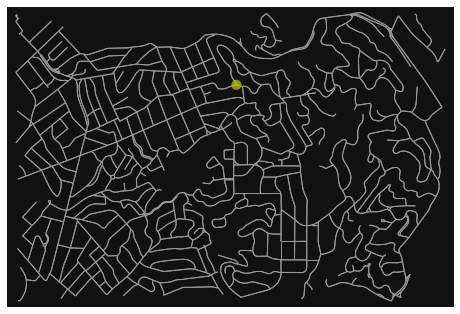

In [75]:
rounds = 1000
sma = SMA(hop='shop')
G = sma.G
sma.tick = 0
orig = list(G)[1]
dest = list(G)[120]
#d1 = ContinuousDriverAgent(1, orig, dest, detour=0.5, pref_weight='length',test=True)
d1 = ContinuousDriverAgent(2, orig, dest, detour_factor=5, pref_weight='travel_time',test=True)
sma.addAgent(d1)
for _ in range(30):
    sma.runOnce()
p_cs = d1.perceptions[1]
p_node_cs = set(ox.truncate.truncate_graph_bbox(G, p_cs[3], p_cs[1], p_cs[2], p_cs[0], truncate_by_edge=False, retain_all=False).nodes)
v1, v2 = random.sample(p_node_cs,2)
#v1 = list(G)[120]
r1 = RiderAgent(3, v1, v2, detour_factor=10, waiting_time=25, pref_weight='travel_time')
sma.addAgent(r1)
print(d1.stops)
sma.runOnce()
print(d1.stops)
for _ in range(1000):
    sma.runOnce()
    #print(d1.stops)

In [76]:
sma.data

{'d_trip_time': [602.0],
 'd_trip_length': [8222.325],
 'r_total_waiting_time': [139.0],
 'r_start_waiting_time': [139.0],
 'r_trip_time': [410.0],
 'r_saved_time': [4071.0],
 'r_nb_unmatched': 0,
 'r_nb_matched': 1,
 'mhop_count': 0,
 'shop_count': 1,
 'saved_distance': -2284.927,
 'nb_tsf': []}

### TEST 5 : Plusieurs conducteurs avec plusieurs passager, test avec contraintes et verif faisabilité, MHOP Test sur les différentes méthodes (base et GGNV1-4)

In [112]:
NB_RUN = 2
MAX_NB_DRIVERS = 20
MAX_NB_RIDERS = 15
DET_FACTOR_D = 1
DET_FACTOR_R = 0.2
WT = 4
seed = 1
#bbox = [-96.649805,39.17254,-96.558395,39.215712]
bbox = 'grid'
les_datas = []

In [113]:
# random.seed(seed)
# #sma = SMA(place='Lille, France')
# for _ in range(1):
#     sma = SMA(place=bbox, show_graph=True, verbose=True, verbose2=True, hop='mhop')
#     G = sma.G
#     count_id = 1
#     for i in range(MAX_NB_DRIVERS):
#         v1, v2 = random.sample(list(sma.G.nodes),2)
#         while not nx.has_path(sma.G, v1, v2):
#             v1, v2 = random.sample(list(sma.G.nodes),2)

#         d = ContinuousDriverAgent(count_id, v1, v2, detour_factor=DET_FACTOR_D, pref_weight='travel_time',test=False)
#         sma.addAgent(d)
#         count_id+=1

#     for i in range(MAX_NB_RIDERS):
#         v1, v2 = random.sample(list(sma.G.nodes),2)
#         while not nx.has_path(sma.G, v1, v2):
#             v1, v2 = random.sample(list(sma.G.nodes),2)
#         r = GNNV1RiderAgent(count_id, v1, v2, detour_factor=DET_FACTOR_R, waiting_time=WT, pref_weight='travel_time')
#         sma.addAgent(r)
#         count_id+=1
#     start = timer()
#     for _ in range(NB_RUN):
#         print("tick:",sma.tick)
#         sma.runOnce()
#     end = timer()
#     print(f'elapsed time: {end - start}')

In [114]:
# les_datas.append(sma.data)

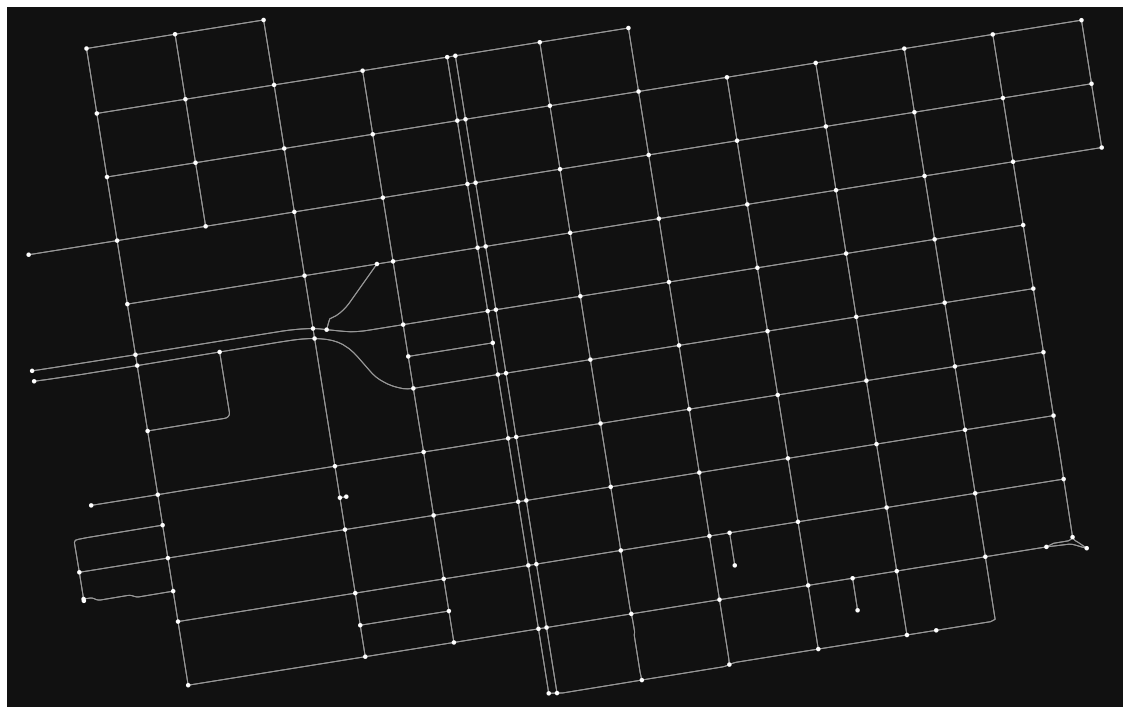

tick: 0
best_candidate was None
best_candidate is ((<__main__.ContinuousDriverAgent object at 0x7f4cc9b8e4d0>, 65333834, 65334137, 55.0, 71.0, 1, 1), (<__main__.ContinuousDriverAgent object at 0x7f4cd7d41190>, 65334137, 65295347, 75.0, 164.0, 1, 1), 164.0, 4.0)


/home/fevrec/Documents/These/these/smac_agents/mas_ride_sharing/mas_transportation_utils.py:117: RuntimeWarning: overflow encountered in power
  min_dist = math.sqrt(np.power(q_min_lon-ref_lon,2)+np.power(q_min_lat-ref_lat,2))*111000 #valeur approchée mais suffisante sinon utiliser cosinus et sinus...


best_candidate was ((<__main__.ContinuousDriverAgent object at 0x7f4cc9b8e4d0>, 65333834, 65334137, 55.0, 71.0, 1, 1), (<__main__.ContinuousDriverAgent object at 0x7f4cd7d41190>, 65334137, 65295347, 75.0, 164.0, 1, 1), 164.0, 4.0)
best_candidate is ((<__main__.ContinuousDriverAgent object at 0x7f4ce6c20a50>, 65333834, 65295347, 27.0, 134.0, 1, 1), None, 134.0, 0)
Rider 21 single hop with 11
best_candidate was None
best_candidate is ((<__main__.ContinuousDriverAgent object at 0x7f4cd7d41190>, 65360273, 65319968, 60.0, 155.0, 1, 1), (<__main__.ContinuousDriverAgent object at 0x7f4ce6c20a50>, 65319968, 4014319583, 164.0, 195.0, 3, 3), 195.0, 9.0)
best_candidate was ((<__main__.ContinuousDriverAgent object at 0x7f4cd7d41190>, 65360273, 65319968, 60.0, 155.0, 1, 1), (<__main__.ContinuousDriverAgent object at 0x7f4ce6c20a50>, 65319968, 4014319583, 164.0, 195.0, 3, 3), 195.0, 9.0)
best_candidate is ((<__main__.ContinuousDriverAgent object at 0x7f4cc8fb7d50>, 65360273, 4014319583, 11.0, 119.0,

In [115]:
random.seed(seed)
#sma = SMA(place='Lille, France')
for _ in range(1):
    sma = SMA(place=bbox, show_graph=True, verbose=True, verbose2=True, hop='mhop')
    G = sma.G
    count_id = 1
    for i in range(MAX_NB_DRIVERS):
        v1, v2 = random.sample(list(sma.G.nodes),2)
        while not nx.has_path(sma.G, v1, v2):
            v1, v2 = random.sample(list(sma.G.nodes),2)

        d = ContinuousDriverAgent(count_id, v1, v2, detour_factor=DET_FACTOR_D, pref_weight='travel_time',test=False)
        sma.addAgent(d)
        count_id+=1

    for i in range(MAX_NB_RIDERS):
        v1, v2 = random.sample(list(sma.G.nodes),2)
        while not nx.has_path(sma.G, v1, v2):
            v1, v2 = random.sample(list(sma.G.nodes),2)
        r = GNNV2RiderAgent(count_id, v1, v2, detour_factor=DET_FACTOR_R, waiting_time=WT, pref_weight='travel_time', version=1)
        sma.addAgent(r)
        count_id+=1
    start = timer()
    for _ in range(NB_RUN):
        print("tick:",sma.tick)
        sma.runOnce()
    end = timer()
    print(f'elapsed time: {end - start}')

In [116]:
les_datas.append(sma.data)

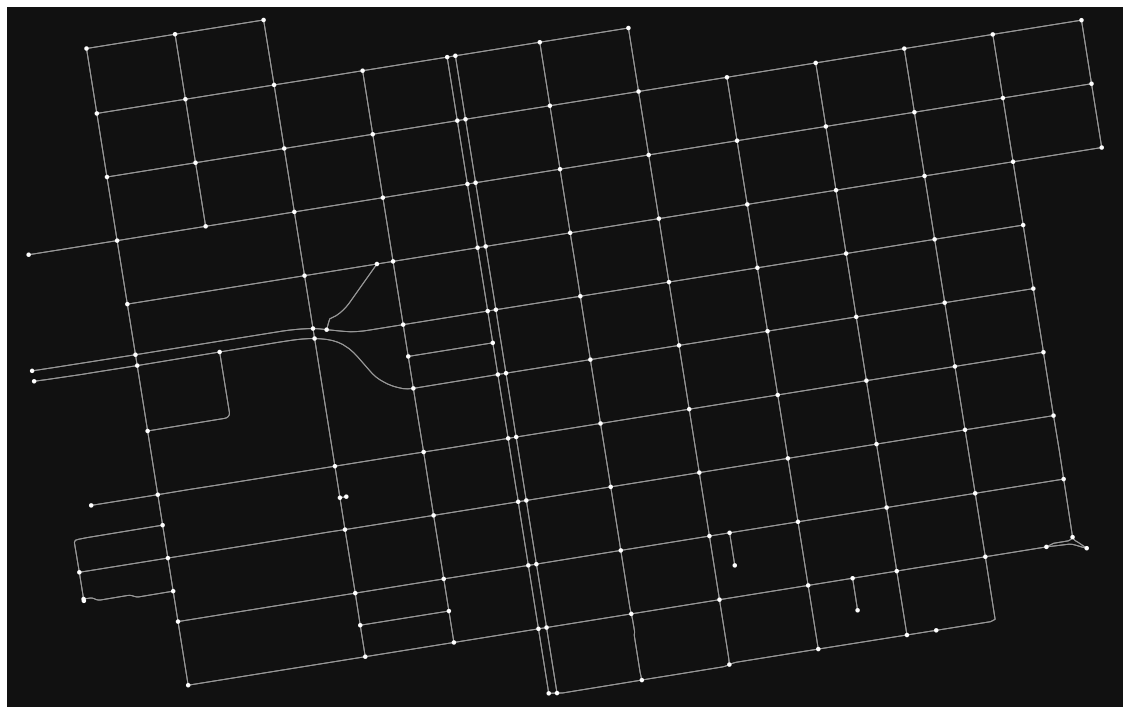

tick: 0
best_candidate was None
best_candidate is ((<__main__.ContinuousDriverAgent object at 0x7f4cc80f6750>, 65333834, 65314171, 46.0, 70.0, 1, 1), (<__main__.ContinuousDriverAgent object at 0x7f4cd64ae990>, 65314171, 65295347, 81.0, 161.0, 1, 1), 161.0, 11.0)
best_candidate was ((<__main__.ContinuousDriverAgent object at 0x7f4cc80f6750>, 65333834, 65314171, 46.0, 70.0, 1, 1), (<__main__.ContinuousDriverAgent object at 0x7f4cd64ae990>, 65314171, 65295347, 81.0, 161.0, 1, 1), 161.0, 11.0)
best_candidate is ((<__main__.ContinuousDriverAgent object at 0x7f4cc9139390>, 65333834, 65295347, 27.0, 134.0, 1, 1), None, 134.0, 0)


/home/fevrec/Documents/These/these/smac_agents/mas_ride_sharing/mas_transportation_utils.py:117: RuntimeWarning: overflow encountered in power
  min_dist = math.sqrt(np.power(q_min_lon-ref_lon,2)+np.power(q_min_lat-ref_lat,2))*111000 #valeur approchée mais suffisante sinon utiliser cosinus et sinus...


Rider 21 single hop with 11
best_candidate was None
best_candidate is ((<__main__.ContinuousDriverAgent object at 0x7f4cd64ae990>, 65360273, 65319968, 60.0, 155.0, 1, 1), (<__main__.ContinuousDriverAgent object at 0x7f4cc9139390>, 65319968, 4014319583, 164.0, 195.0, 3, 3), 195.0, 9.0)
best_candidate was ((<__main__.ContinuousDriverAgent object at 0x7f4cd64ae990>, 65360273, 65319968, 60.0, 155.0, 1, 1), (<__main__.ContinuousDriverAgent object at 0x7f4cc9139390>, 65319968, 4014319583, 164.0, 195.0, 3, 3), 195.0, 9.0)
best_candidate is ((<__main__.ContinuousDriverAgent object at 0x7f4cc80f6750>, 65360273, 65329103, 27.0, 90.0, 1, 1), (<__main__.ContinuousDriverAgent object at 0x7f4cd5d5d050>, 65329103, 4014319583, 100.0, 148.0, 1, 1), 148.0, 10.0)
best_candidate was ((<__main__.ContinuousDriverAgent object at 0x7f4cc80f6750>, 65360273, 65329103, 27.0, 90.0, 1, 1), (<__main__.ContinuousDriverAgent object at 0x7f4cd5d5d050>, 65329103, 4014319583, 100.0, 148.0, 1, 1), 148.0, 10.0)
best_candi

In [117]:
random.seed(seed)
#sma = SMA(place='Lille, France')
for _ in range(1):
    sma = SMA(place=bbox, show_graph=True, verbose=True, verbose2=True, hop='mhop')
    G = sma.G
    count_id = 1
    for i in range(MAX_NB_DRIVERS):
        v1, v2 = random.sample(list(sma.G.nodes),2)
        while not nx.has_path(sma.G, v1, v2):
            v1, v2 = random.sample(list(sma.G.nodes),2)

        d = ContinuousDriverAgent(count_id, v1, v2, detour_factor=DET_FACTOR_D, pref_weight='travel_time',test=False)
        sma.addAgent(d)
        count_id+=1

    for i in range(MAX_NB_RIDERS):
        v1, v2 = random.sample(list(sma.G.nodes),2)
        while not nx.has_path(sma.G, v1, v2):
            v1, v2 = random.sample(list(sma.G.nodes),2)
        r = GNNV2RiderAgent(count_id, v1, v2, detour_factor=DET_FACTOR_R, waiting_time=WT, pref_weight='travel_time', version=2)
        sma.addAgent(r)
        count_id+=1
    start = timer()
    for _ in range(NB_RUN):
        print("tick:",sma.tick)
        sma.runOnce()
    end = timer()
    print(f'elapsed time: {end - start}')

In [118]:
les_datas.append(sma.data)

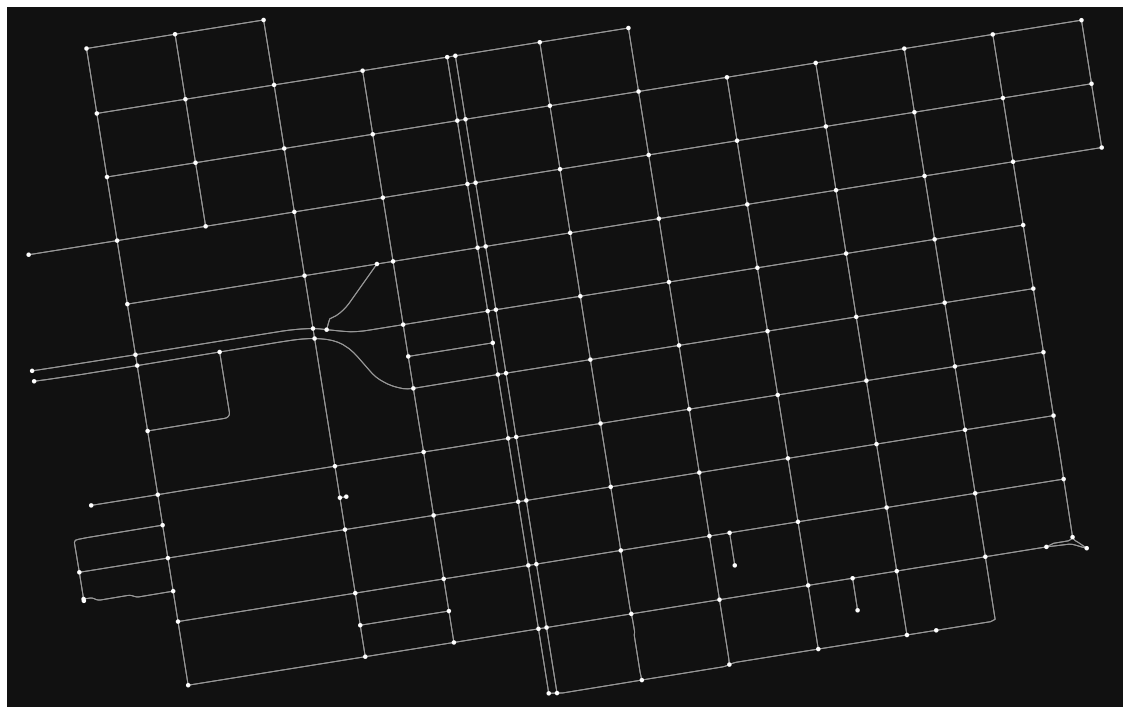

tick: 0


KeyboardInterrupt: 

In [212]:
random.seed(seed)
#sma = SMA(place='Lille, France')
for _ in range(1):
    sma = SMA(place=bbox, show_graph=True, verbose=True, verbose2=True, hop='mhop')
    G = sma.G
    count_id = 1
    for i in range(MAX_NB_DRIVERS):
        v1, v2 = random.sample(list(sma.G.nodes),2)
        while not nx.has_path(sma.G, v1, v2):
            v1, v2 = random.sample(list(sma.G.nodes),2)

        d = ContinuousDriverAgent(count_id, v1, v2, detour_factor=DET_FACTOR_D, pref_weight='travel_time',test=False)
        sma.addAgent(d)
        count_id+=1

    for i in range(MAX_NB_RIDERS):
        v1, v2 = random.sample(list(sma.G.nodes),2)
        while not nx.has_path(sma.G, v1, v2):
            v1, v2 = random.sample(list(sma.G.nodes),2)
        r = GNNV3RiderAgent(count_id, v1, v2, detour_factor=DET_FACTOR_R, waiting_time=WT, pref_weight='travel_time', version=2)
        sma.addAgent(r)
        count_id+=1
    start = timer()
    for _ in range(NB_RUN):
        print("tick:",sma.tick)
        sma.runOnce()
    end = timer()
    print(f'elapsed time: {end - start}')

In [120]:
les_datas.append(sma.data)

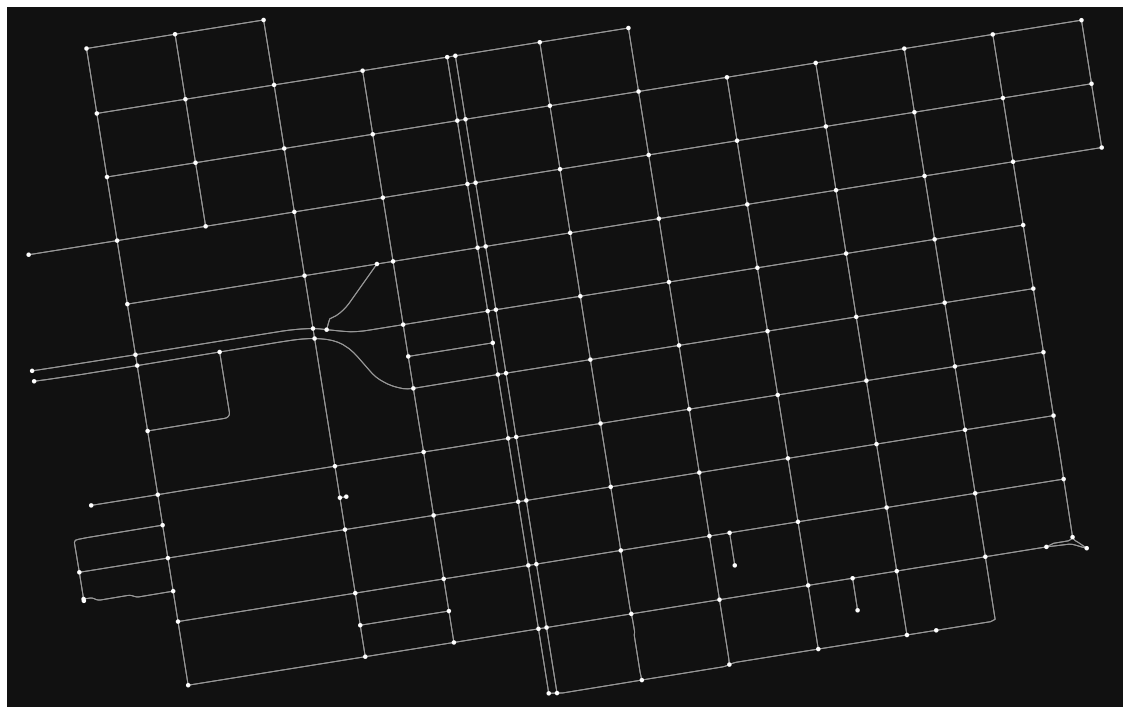

tick: 0
best_candidates were [] [inf, inf, inf, inf]
best_candidate is now [((<__main__.ContinuousDriverAgent object at 0x7f4cc980aad0>, 65333834, 65314171, 57.0, 81.0, 1, 1), (<__main__.ContinuousDriverAgent object at 0x7f4cd650c590>, 65314171, 65295347, 81.0, 161.0, 1, 1), (57.0, 502.74300000000005, 161.0, 2))] [57.0, 502.74300000000005, 161.0, 2]


/home/fevrec/Documents/These/these/smac_agents/mas_ride_sharing/mas_transportation_utils.py:117: RuntimeWarning: overflow encountered in power
  min_dist = math.sqrt(np.power(q_min_lon-ref_lon,2)+np.power(q_min_lat-ref_lat,2))*111000 #valeur approchée mais suffisante sinon utiliser cosinus et sinus...


adding the candidate ((<__main__.ContinuousDriverAgent object at 0x7f4cc980a510>, 65333834, 4013421806, 41.0, 98.0, 1, 1), (<__main__.ContinuousDriverAgent object at 0x7f4cc966b710>, 4013421806, 65295347, 107.0, 163.0, 1, 1), (50.0, 319.791, 163.0, 2))
changing goals from [57.0, 502.74300000000005, 161.0, 2]
to [50.0, 502.74300000000005, 161.0, 2]
changing goals from [50.0, 502.74300000000005, 161.0, 2]
to [50.0, 319.791, 161.0, 2]
changing goals from [50.0, 319.791, 161.0, 2]
to [50.0, 319.791, 161.0, 2]
best_candidates were [((<__main__.ContinuousDriverAgent object at 0x7f4cc980aad0>, 65333834, 65314171, 57.0, 81.0, 1, 1), (<__main__.ContinuousDriverAgent object at 0x7f4cd650c590>, 65314171, 65295347, 81.0, 161.0, 1, 1), (57.0, 502.74300000000005, 161.0, 2)), ((<__main__.ContinuousDriverAgent object at 0x7f4cc980a510>, 65333834, 4013421806, 41.0, 98.0, 1, 1), (<__main__.ContinuousDriverAgent object at 0x7f4cc966b710>, 4013421806, 65295347, 107.0, 163.0, 1, 1), (50.0, 319.791, 163.0, 

adding the candidate ((<__main__.ContinuousDriverAgent object at 0x7f4cc966b690>, 65338334, 276546819, 125.0, 192.0, 1, 1), None, (125.0, 3833.3333333333335, 192.0, 1))
changing goals from [67.0, 227.415, 134.0, 1]
to [67.0, 227.415, 134.0, 1]
Rider 25 single hop with 15
best_candidates were [] [inf, inf, inf, inf]
best_candidate is now [((<__main__.ContinuousDriverAgent object at 0x7f4cd650c590>, 65362158, 65333826, 71.0, 79.0, 1, 1), (<__main__.ContinuousDriverAgent object at 0x7f4cca09bf10>, 65333826, 276546820, 79.0, 161.0, 1, 1), (71.0, 1192.994, 161.0, 2))] [71.0, 1192.994, 161.0, 2]
adding the candidate ((<__main__.ContinuousDriverAgent object at 0x7f4cca09bf10>, 65362158, 276546820, 85.0, 159.0, 1, 1), None, (85.0, 2208.3333333333335, 159.0, 1))
changing goals from [71.0, 1192.994, 161.0, 2]
to [71.0, 1192.994, 159.0, 2]
changing goals from [71.0, 1192.994, 159.0, 2]
to [71.0, 1192.994, 159.0, 1]
adding the candidate ((<__main__.ContinuousDriverAgent object at 0x7f4cc980a510>, 

In [161]:
random.seed(seed)
#sma = SMA(place='Lille, France')
for _ in range(1):
    sma = SMA(place=bbox, show_graph=True, verbose=True, verbose2=True, hop='mhop', )
    G = sma.G
    count_id = 1
    for i in range(MAX_NB_DRIVERS):
        v1, v2 = random.sample(list(sma.G.nodes),2)
        while not nx.has_path(sma.G, v1, v2):
            v1, v2 = random.sample(list(sma.G.nodes),2)

        d = ContinuousDriverAgent(count_id, v1, v2, detour_factor=DET_FACTOR_D, pref_weight='travel_time',test=False)
        sma.addAgent(d)
        count_id+=1

    for i in range(MAX_NB_RIDERS):
        v1, v2 = random.sample(list(sma.G.nodes),2)
        while not nx.has_path(sma.G, v1, v2):
            v1, v2 = random.sample(list(sma.G.nodes),2)
        r = GNNV4RiderAgent(count_id, v1, v2, detour_factor=DET_FACTOR_R, waiting_time=WT, pref_weight='travel_time', version=2)
        sma.addAgent(r)
        count_id+=1
    start = timer()
    for _ in range(NB_RUN):
        print("tick:",sma.tick)
        sma.runOnce()
    end = timer()
    print(f'elapsed time: {end - start}')

In [162]:
les_datas.append(sma.data)

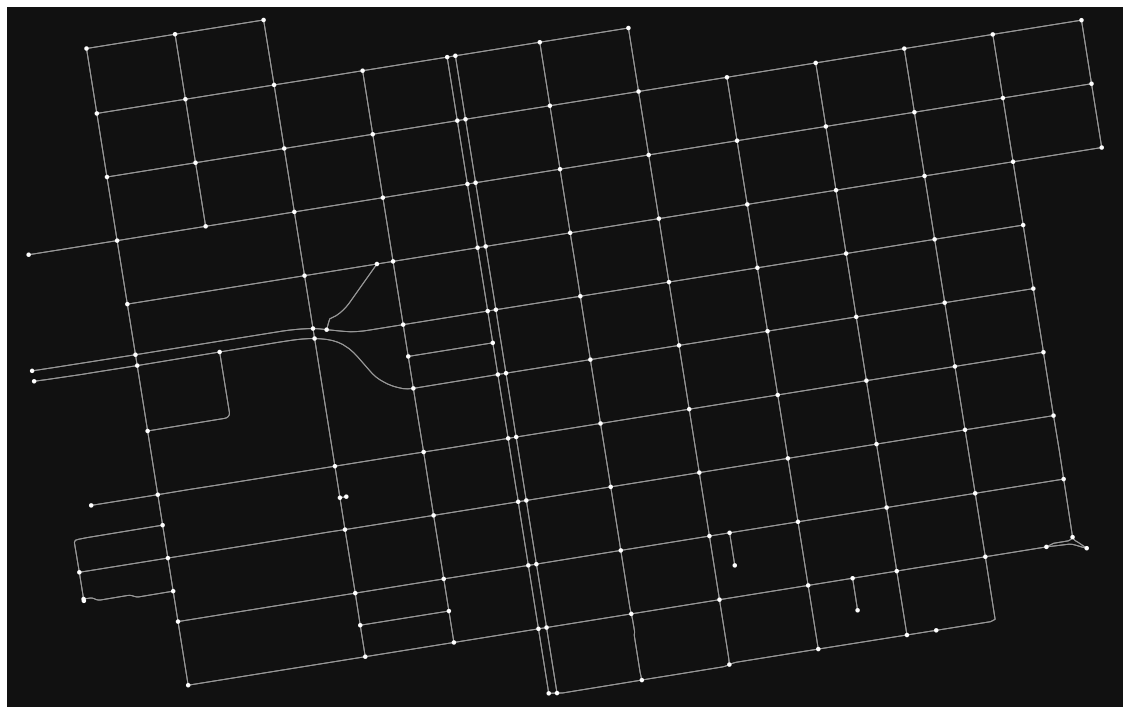

tick: 0
best_candidate was None
best_candidate is ((<__main__.ContinuousDriverAgent object at 0x7f4cd50dc990>, 65333834, 65317956, 55.0, 63.0, 1, 1), (<__main__.ContinuousDriverAgent object at 0x7f4cc9821310>, 65317956, 65295347, 65.0, 163.0, 1, 1), 163.0, 2.0)
best_candidate was ((<__main__.ContinuousDriverAgent object at 0x7f4cd50dc990>, 65333834, 65317956, 55.0, 63.0, 1, 1), (<__main__.ContinuousDriverAgent object at 0x7f4cc9821310>, 65317956, 65295347, 65.0, 163.0, 1, 1), 163.0, 2.0)
best_candidate is ((<__main__.ContinuousDriverAgent object at 0x7f4cb8352b90>, 65333834, 65295347, 30.0, 137.0, 1, 1), None, 137.0, 0)
best_candidate was ((<__main__.ContinuousDriverAgent object at 0x7f4cb8352b90>, 65333834, 65295347, 30.0, 137.0, 1, 1), None, 137.0, 0)
best_candidate is ((<__main__.ContinuousDriverAgent object at 0x7f4cc8109f50>, 65333834, 258758553, 24.0, 45.0, 1, 1), (<__main__.ContinuousDriverAgent object at 0x7f4cc9e87650>, 258758553, 65295347, 50.0, 136.0, 1, 1), 136.0, 5.0)
best

best_candidate was ((<__main__.ContinuousDriverAgent object at 0x7f4cd50dc990>, 65308283, 65329103, 74.0, 136.0, 1, 1), (<__main__.ContinuousDriverAgent object at 0x7f4cb8352b90>, 65329103, 65319023, 196.0, 242.0, 3, 3), 242.0, 60.0)
best_candidate is ((<__main__.ContinuousDriverAgent object at 0x7f4cd50dc990>, 65308283, 65327154, 74.0, 101.0, 1, 1), (<__main__.ContinuousDriverAgent object at 0x7f4cc9e87650>, 65327154, 65319023, 122.0, 196.0, 3, 3), 196.0, 21.0)
best_candidate was ((<__main__.ContinuousDriverAgent object at 0x7f4cd50dc990>, 65308283, 65327154, 74.0, 101.0, 1, 1), (<__main__.ContinuousDriverAgent object at 0x7f4cc9e87650>, 65327154, 65319023, 122.0, 196.0, 3, 3), 196.0, 21.0)
best_candidate is ((<__main__.ContinuousDriverAgent object at 0x7f4cd50dc990>, 65308283, 65308283, 74.0, 74.0, 1, 1), (<__main__.ContinuousDriverAgent object at 0x7f4cd5b8de10>, 65308283, 65319023, 79.0, 183.0, 1, 1), 183.0, 5.0)
best_candidate was ((<__main__.ContinuousDriverAgent object at 0x7f4c

best_candidate was ((<__main__.ContinuousDriverAgent object at 0x7f4cb8352790>, 65362158, 65354421, 54.0, 76.0, 1, 1), (<__main__.ContinuousDriverAgent object at 0x7f4cb8352250>, 65354421, 276546820, 80.0, 135.0, 1, 1), 135.0, 4.0)
best_candidate is ((<__main__.ContinuousDriverAgent object at 0x7f4cc9e87ad0>, 65362158, 276546820, 27.0, 101.0, 1, 1), None, 101.0, 0)
best_candidate was ((<__main__.ContinuousDriverAgent object at 0x7f4cc9e87ad0>, 65362158, 276546820, 27.0, 101.0, 1, 1), None, 101.0, 0)
best_candidate is ((<__main__.ContinuousDriverAgent object at 0x7f4cd5b8de10>, 65362158, 258758552, 22.0, 65.0, 1, 1), (<__main__.ContinuousDriverAgent object at 0x7f4cc9e87ad0>, 258758552, 276546820, 65.0, 96.0, 1, 1), 96.0, 0.0)
best_candidate was ((<__main__.ContinuousDriverAgent object at 0x7f4cd5b8de10>, 65362158, 258758552, 22.0, 65.0, 1, 1), (<__main__.ContinuousDriverAgent object at 0x7f4cc9e87ad0>, 258758552, 276546820, 65.0, 96.0, 1, 1), 96.0, 0.0)
best_candidate is ((<__main__.Co

In [163]:
random.seed(seed)
#sma = SMA(place='Lille, France')
for _ in range(1):
    sma = SMA(place=bbox, show_graph=True, verbose=True, verbose2=True, hop='mhop')
    G = sma.G
    count_id = 1
    for i in range(MAX_NB_DRIVERS):
        v1, v2 = random.sample(list(sma.G.nodes),2)
        while not nx.has_path(sma.G, v1, v2):
            v1, v2 = random.sample(list(sma.G.nodes),2)

        d = ContinuousDriverAgent(count_id, v1, v2, detour_factor=DET_FACTOR_D, pref_weight='travel_time',test=False)
        sma.addAgent(d)
        count_id+=1

    for i in range(MAX_NB_RIDERS):
        v1, v2 = random.sample(list(sma.G.nodes),2)
        while not nx.has_path(sma.G, v1, v2):
            v1, v2 = random.sample(list(sma.G.nodes),2)
        r = RiderAgent(count_id, v1, v2, detour_factor=DET_FACTOR_R, waiting_time=WT, pref_weight='travel_time')
        sma.addAgent(r)
        count_id+=1
    start = timer()
    for _ in range(NB_RUN):
        print("tick:",sma.tick)
        sma.runOnce()
    end = timer()
    print(f'elapsed time: {end - start}')

In [164]:
les_datas.append(sma.data)

In [165]:
les_datas

[{'d_trip_time': [],
  'd_trip_length': [],
  'r_total_waiting_time': [27.0,
   11.0,
   20.0,
   56.0,
   82.0,
   11.0,
   65.0,
   30.0,
   42.0,
   92.0,
   165.0],
  'r_start_waiting_time': [27.0,
   11.0,
   20.0,
   38.0,
   77.0,
   11.0,
   53.0,
   30.0,
   30.0,
   35.0,
   27.0],
  'r_trip_time': [134.0,
   119.0,
   124.0,
   138.0,
   141.0,
   85.0,
   113.0,
   125.0,
   137.0,
   205.0,
   244.0],
  'r_saved_time': [235.0,
   251.0,
   241.0,
   201.0,
   180.0,
   244.0,
   185.0,
   229.0,
   217.0,
   165.0,
   91.0],
  'r_nb_unmatched': 0,
  'r_nb_matched': 11,
  'mhop_count': 6,
  'shop_count': 5,
  'saved_distance': 12320.641000000001,
  'nb_tsf': []},
 {'d_trip_time': [],
  'd_trip_length': [],
  'r_total_waiting_time': [27.0,
   11.0,
   20.0,
   61.0,
   60.0,
   11.0,
   70.0,
   30.0,
   135.0,
   40.0,
   84.0,
   165.0],
  'r_start_waiting_time': [27.0,
   11.0,
   20.0,
   61.0,
   52.0,
   11.0,
   70.0,
   30.0,
   21.0,
   35.0,
   84.0,
   27.0],
  'r

In [ ]:
d_id = 4
print("arr",sma.getAgentFromId(d_id).arr)
print("ddl",sma.getAgentFromId(d_id).ddl)
print("slk",sma.getAgentFromId(d_id).slk)
print("cap",sma.getAgentFromId(d_id).capacities)
print("perc",sma.getAgentFromId(d_id).perceptions)
print("stops",sma.getAgentFromId(d_id).stops)
print("trip",sma.getAgentFromId(d_id).trip)
print("v_r",sma.getAgentFromId(d_id).current_pos)
print("v_arr",sma.getAgentFromId(d_id).v_arr)
sma.getAgentFromId(d_id)

In [ ]:
sma.data

### Test: faire varier les préférences des agents sur GNNV4
5 profils sur le schéma : [total_wt, add_dist, arr_time, nb_tsf]
- balanced [0.25,0.25,0.25,0.25]
- comfort [0.3,0.15,0.15,0.4]
- hurry [0.2,0.15,0.5,0.15]
- ecologist [0.15,0.55,0.15,0.15]
- wet [0.5,0.1,0.1,0.3]

In [216]:
profils = [[0.25,0.25,0.25,0.25],[0.3,0.15,0.15,0.4],[0.2,0.15,0.5,0.15],[0.15,0.55,0.15,0.15],[0.5,0.1,0.1,0.3]]
NB_RUN = 300
MAX_NB_DRIVERS = 20
MAX_NB_RIDERS = 15
DET_FACTOR_D = 1
DET_FACTOR_R = 0.2
WT = 4
seed = 1
#bbox = [-96.649805,39.17254,-96.558395,39.215712]
bbox = 'grid'
les_datas = []

random.seed(seed)
#sma = SMA(place='Lille, France')
for profil in profils:
    sma = SMA(place=bbox, show_graph=False, verbose=True, verbose2=True, hop='mhop')
    G = sma.G
    count_id = 1
    for i in range(MAX_NB_DRIVERS):
        v1, v2 = random.sample(list(sma.G.nodes),2)
        while not nx.has_path(sma.G, v1, v2):
            v1, v2 = random.sample(list(sma.G.nodes),2)

        d = ContinuousDriverAgent(count_id, v1, v2, detour_factor=DET_FACTOR_D, pref_weight='travel_time',test=False)
        sma.addAgent(d)
        count_id+=1

    for i in range(MAX_NB_RIDERS):
        v1, v2 = random.sample(list(sma.G.nodes),2)
        while not nx.has_path(sma.G, v1, v2):
            v1, v2 = random.sample(list(sma.G.nodes),2)
        r = GNNV4RiderAgent(count_id, v1, v2, detour_factor=DET_FACTOR_R, waiting_time=WT, pref_weight='travel_time', version=2, profil=profil)
        sma.addAgent(r)
        count_id+=1
    start = timer()
    for _ in range(NB_RUN):
        print("tick:",sma.tick)
        sma.runOnce()
    end = timer()
    print(f'elapsed time: {end - start}')
    les_datas.append(sma.data)
les_datas

tick: 0
best_candidates were [] [inf, inf, inf, inf]
best_candidate is now [((<__main__.ContinuousDriverAgent object at 0x7f4ca8391990>, 65333834, 258758555, 24.0, 66.0, 1, 1), (<__main__.ContinuousDriverAgent object at 0x7f4ca8391710>, 258758555, 65295347, 71.0, 175.0, 1, 1), (29.0, 1535.431, 175.0, 2))] [29.0, 1535.431, 175.0, 2]
adding the candidate ((<__main__.ContinuousDriverAgent object at 0x7f4ca8391990>, 65333834, 65333837, 24.0, 46.0, 1, 1), (<__main__.ContinuousDriverAgent object at 0x7f4ca8391610>, 65333837, 65295347, 53.0, 139.0, 1, 1), (31.0, 1249.5579999999998, 139.0, 2))
changing goals from [29.0, 1535.431, 175.0, 2]
to [29.0, 1249.5579999999998, 175.0, 2]
changing goals from [29.0, 1249.5579999999998, 175.0, 2]
to [29.0, 1249.5579999999998, 139.0, 2]
changing goals from [29.0, 1249.5579999999998, 139.0, 2]
to [29.0, 1249.5579999999998, 139.0, 2]
adding the candidate ((<__main__.ContinuousDriverAgent object at 0x7f4ca8391990>, 65333834, 258758555, 24.0, 66.0, 1, 1), (<__

[(21.0, 0, 125.0, 2), (79.0, 3111.1111111111113, 183.0, 1), (20.0, 3194.4444444444443, 124.0, 1)]
[18.462469733656174, 53.1055900621118, 17.857142857142858]
Rider 23 single hop with 5
best_candidates were [] [inf, inf, inf, inf]
best_candidate is now [((<__main__.ContinuousDriverAgent object at 0x7f4ca8391ed0>, 65333837, 258758553, 56.0, 57.0, 1, 1), (<__main__.ContinuousDriverAgent object at 0x7f4ca8391cd0>, 258758553, 65314161, 60.0, 141.0, 1, 1), (59.0, 810.725, 141.0, 2))] [59.0, 810.725, 141.0, 2]
adding the candidate ((<__main__.ContinuousDriverAgent object at 0x7f4ca8391cd0>, 65333837, 65314161, 61.0, 143.0, 1, 1), None, (61.0, 2527.777777777778, 143.0, 1))
changing goals from [59.0, 810.725, 141.0, 2]
to [59.0, 810.725, 141.0, 1]
adding the candidate ((<__main__.ContinuousDriverAgent object at 0x7f4ca8391cd0>, 65333837, 258758547, 61.0, 107.0, 1, 1), (<__main__.ContinuousDriverAgent object at 0x7f4ca8391250>, 258758547, 65314161, 114.0, 184.0, 1, 1), (68.0, 299.521, 184.0, 2))


[(117.0, 358.63199999999995, 214.0, 2), (139.0, 1875.0, 187.0, 1)]
[35.714285714285715, 35.714285714285715]
Rider 27 multihop with 10 and 15
best_candidates were [] [inf, inf, inf, inf]
best_candidate is now [((<__main__.ContinuousDriverAgent object at 0x7f4ca8391250>, 65333826, 65319019, 30.0, 116.0, 1, 1), (<__main__.ContinuousDriverAgent object at 0x7f4ca8391610>, 65319019, 276546818, 222.0, 230.0, 4, 4), (136.0, 737.106, 230.0, 2))] [136.0, 737.106, 230.0, 2]
adding the candidate ((<__main__.ContinuousDriverAgent object at 0x7f4ca8391250>, 65333826, 276546818, 30.0, 125.0, 1, 1), None, (30.0, 2625.0, 125.0, 1))
changing goals from [136.0, 737.106, 230.0, 2]
to [30.0, 737.106, 230.0, 2]
changing goals from [30.0, 737.106, 230.0, 2]
to [30.0, 737.106, 125.0, 2]
changing goals from [30.0, 737.106, 125.0, 2]
to [30.0, 737.106, 125.0, 1]
adding the candidate ((<__main__.ContinuousDriverAgent object at 0x7f4ca8391250>, 65333826, 65329103, 30.0, 95.0, 1, 1), (<__main__.ContinuousDriverAge

tick 172 ended
tick: 172
tick 173 ended
tick: 173
tick 174 ended
tick: 174
tick 175 ended
tick: 175
tick 176 ended
tick: 176
tick 177 ended
tick: 177
tick 178 ended
tick: 178
tick 179 ended
tick: 179
tick 180 ended
tick: 180
tick 181 ended
tick: 181
tick 182 ended
tick: 182
tick 183 ended
tick: 183
Driver 14 arrived
tick 184 ended
tick: 184
tick 185 ended
tick: 185
tick 186 ended
tick: 186
tick 187 ended
tick: 187
tick 188 ended
tick: 188
tick 189 ended
tick: 189
tick 190 ended
tick: 190
tick 191 ended
tick: 191
tick 192 ended
tick: 192
Driver 3 arrived
tick 193 ended
tick: 193
tick 194 ended
tick: 194
tick 195 ended
tick: 195
tick 196 ended
tick: 196
tick 197 ended
tick: 197
tick 198 ended
tick: 198
tick 199 ended
tick: 199
tick 200 ended
tick: 200
tick 201 ended
tick: 201
tick 202 ended
tick: 202
tick 203 ended
tick: 203
tick 204 ended
tick: 204
tick 205 ended
tick: 205
tick 206 ended
tick: 206
tick 207 ended
tick: 207
tick 208 ended
tick: 208
tick 209 ended
tick: 209
tick 210 ended


adding the candidate ((<__main__.ContinuousDriverAgent object at 0x7f4ca83cf750>, 65360270, 258758555, 58.0, 97.0, 1, 1), None, (58.0, 2430.5555555555557, 97.0, 1))
changing goals from [14.0, 244.61999999999998, 53.0, 1]
to [14.0, 244.61999999999998, 53.0, 1]
[(48.0, 2541.6666666666665, 87.0, 1), (76.0, 328.533, 127.0, 2), (14.0, 1902.7777777777778, 53.0, 1), (42.0, 1902.7777777777778, 81.0, 1), (232.0, 2111.1111111111113, 271.0, 1), (46.0, 2222.222222222222, 85.0, 1), (43.0, 2027.7777777777778, 82.0, 1), (46.0, 1611.111111111111, 85.0, 1), (77.0, 315.08500000000004, 126.0, 2), (45.0, 1291.6666666666667, 84.0, 1), (35.0, 244.61999999999998, 76.0, 2), (29.0, 1902.7777777777778, 68.0, 1), (97.0, 3513.888888888889, 136.0, 1), (58.0, 2430.5555555555557, 97.0, 1)]
[12.541154516321038, 38.577758078571215, 5.434235235546573, 9.56267560251905, 38.259857526516534, 11.19935935824049, 10.119778990207184, 9.196581590442884, 38.582833414761296, 8.00223073118278, 31.76605504587156, 7.645899717853257

adding the candidate ((<__main__.ContinuousDriverAgent object at 0x7f4cd6b8b110>, 65338019, 258758548, 96.0, 125.0, 1, 1), None, (96.0, 1763.888888888889, 125.0, 1))
changing goals from [55.0, 0, 84.0, 1]
to [55.0, 0, 84.0, 1]
adding the candidate ((<__main__.ContinuousDriverAgent object at 0x7f4ca83cfe10>, 65338019, 258758548, 196.0, 225.0, 3, 3), None, (196.0, 2180.5555555555557, 225.0, 1))
changing goals from [55.0, 0, 84.0, 1]
to [55.0, 0, 84.0, 1]
adding the candidate ((<__main__.ContinuousDriverAgent object at 0x7f4ca89a4750>, 65338019, 258758548, 219.0, 248.0, 3, 3), None, (219.0, 2541.6666666666665, 248.0, 1))
changing goals from [55.0, 0, 84.0, 1]
to [55.0, 0, 84.0, 1]
adding the candidate ((<__main__.ContinuousDriverAgent object at 0x7f4cc9f2b910>, 65338019, 258758548, 99.0, 128.0, 3, 3), None, (99.0, 2111.1111111111113, 128.0, 1))
changing goals from [55.0, 0, 84.0, 1]
to [55.0, 0, 84.0, 1]
adding the candidate ((<__main__.ContinuousDriverAgent object at 0x7f4ce6ca9b50>, 653

adding the candidate ((<__main__.ContinuousDriverAgent object at 0x7f4cd621fb10>, 4013421806, 65327158, 79.0, 107.0, 1, 1), None, (79.0, 1625.0, 107.0, 1))
changing goals from [109.0, 1013.8888888888889, 137.0, 1]
to [79.0, 1013.8888888888889, 137.0, 1]
changing goals from [79.0, 1013.8888888888889, 137.0, 1]
to [79.0, 1013.8888888888889, 107.0, 1]
changing goals from [79.0, 1013.8888888888889, 107.0, 1]
to [79.0, 1013.8888888888889, 107.0, 1]
adding the candidate ((<__main__.ContinuousDriverAgent object at 0x7f4cd621fb10>, 4013421806, 258758551, 79.0, 97.0, 1, 1), (<__main__.ContinuousDriverAgent object at 0x7f4cd50ece50>, 258758551, 65327158, 104.0, 114.0, 1, 1), (86.0, 433.028, 114.0, 2))
changing goals from [79.0, 1013.8888888888889, 107.0, 1]
to [79.0, 433.028, 107.0, 1]
adding the candidate ((<__main__.ContinuousDriverAgent object at 0x7f4cd6b8b110>, 4013421806, 65327158, 104.0, 132.0, 1, 1), None, (104.0, 1972.2222222222222, 132.0, 1))
changing goals from [79.0, 433.028, 107.0, 

tick 1 ended
tick: 1
tick 2 ended
tick: 2
tick 3 ended
tick: 3
tick 4 ended
tick: 4
tick 5 ended
tick: 5
tick 6 ended
tick: 6
tick 7 ended
tick: 7
tick 8 ended
tick: 8
tick 9 ended
tick: 9
tick 10 ended
tick: 10
tick 11 ended
tick: 11
tick 12 ended
tick: 12
tick 13 ended
tick: 13
tick 14 ended
tick: 14
tick 15 ended
tick: 15
tick 16 ended
tick: 16
tick 17 ended
tick: 17
tick 18 ended
tick: 18
tick 19 ended
tick: 19
tick 20 ended
tick: 20
tick 21 ended
tick: 21
tick 22 ended
tick: 22
tick 23 ended
tick: 23
tick 24 ended
tick: 24
tick 25 ended
tick: 25
tick 26 ended
tick: 26
tick 27 ended
tick: 27
tick 28 ended
tick: 28
tick 29 ended
tick: 29
tick 30 ended
tick: 30
tick 31 ended
tick: 31
tick 32 ended
tick: 32
tick 33 ended
tick: 33
tick 34 ended
tick: 34
tick 35 ended
tick: 35
tick 36 ended
tick: 36
Driver 7 arrived
tick 37 ended
tick: 37
tick 38 ended
tick: 38
tick 39 ended
tick: 39
tick 40 ended
tick: 40
Driver 5 arrived
tick 41 ended
tick: 41
tick 42 ended
tick: 42
Driver 16 arrived


adding the candidate ((<__main__.ContinuousDriverAgent object at 0x7f4cd5f9c190>, 342548255, 258758546, 57.0, 97.0, 1, 1), None, (57.0, 2402.777777777778, 97.0, 1))
changing goals from [57.0, 0, 97.0, 2]
to [57.0, 0, 97.0, 2]
changing goals from [57.0, 0, 97.0, 2]
to [57.0, 0, 97.0, 2]
changing goals from [57.0, 0, 97.0, 2]
to [57.0, 0, 97.0, 1]
adding the candidate ((<__main__.ContinuousDriverAgent object at 0x7f4cb825ef90>, 342548255, 258758546, 50.0, 90.0, 1, 1), None, (50.0, 2402.777777777778, 90.0, 1))
changing goals from [57.0, 0, 97.0, 1]
to [50.0, 0, 97.0, 1]
changing goals from [50.0, 0, 97.0, 1]
to [50.0, 0, 90.0, 1]
changing goals from [50.0, 0, 90.0, 1]
to [50.0, 0, 90.0, 1]
adding the candidate ((<__main__.ContinuousDriverAgent object at 0x7f4cb825ee10>, 342548255, 258758546, 49.0, 89.0, 1, 1), None, (49.0, 2402.777777777778, 89.0, 1))
changing goals from [50.0, 0, 90.0, 1]
to [49.0, 0, 90.0, 1]
changing goals from [49.0, 0, 90.0, 1]
to [49.0, 0, 89.0, 1]
changing goals fr

adding the candidate ((<__main__.ContinuousDriverAgent object at 0x7f4cd52c3250>, 65334137, 65334125, 66.0, 99.0, 1, 1), (<__main__.ContinuousDriverAgent object at 0x7f4cd5f9c190>, 65334125, 65365830, 172.0, 204.0, 3, 3), (139.0, 0, 204.0, 2))
changing goals from [124.0, 543.5519999999999, 208.0, 1]
to [124.0, 0, 208.0, 1]
changing goals from [124.0, 0, 208.0, 1]
to [124.0, 0, 204.0, 1]
adding the candidate ((<__main__.ContinuousDriverAgent object at 0x7f4cd52c3250>, 65334137, 65365830, 66.0, 135.0, 1, 1), None, (66.0, 1805.5555555555557, 135.0, 1))
changing goals from [124.0, 0, 204.0, 1]
to [66.0, 0, 204.0, 1]
changing goals from [66.0, 0, 204.0, 1]
to [66.0, 0, 135.0, 1]
changing goals from [66.0, 0, 135.0, 1]
to [66.0, 0, 135.0, 1]
adding the candidate ((<__main__.ContinuousDriverAgent object at 0x7f4d15c9e290>, 65334137, 65365830, 47.0, 116.0, 1, 1), None, (47.0, 2180.5555555555557, 116.0, 1))
changing goals from [66.0, 0, 135.0, 1]
to [47.0, 0, 135.0, 1]
changing goals from [47.0

[(57.0, 1736.111111111111, 73.0, 1), (112.0, 397.249, 128.0, 2), (88.0, 2208.3333333333335, 104.0, 1), (51.0, 1875.0, 67.0, 1), (112.0, 2027.7777777777778, 128.0, 1), (123.0, 1569.4444444444446, 139.0, 1)]
[12.087308972745287, 53.07539682539682, 36.40873015873016, 8.742302132021882, 52.00723905167058, 56.9346505149467]
Rider 26 single hop with 11
best_candidates were [] [inf, inf, inf, inf]
best_candidate is now [((<__main__.ContinuousDriverAgent object at 0x7f4ca8af0550>, 65303553, 65334120, 115.0, 164.0, 3, 3), None, (115.0, 1569.4444444444446, 164.0, 1))] [115.0, 1569.4444444444446, 164.0, 1]
adding the candidate ((<__main__.ContinuousDriverAgent object at 0x7f4ca8af0550>, 65303553, 65303548, 115.0, 148.0, 3, 3), (<__main__.ContinuousDriverAgent object at 0x7f4cd5f9c190>, 65303548, 65334120, 168.0, 184.0, 3, 3), (135.0, 356.195, 184.0, 2))
changing goals from [115.0, 1569.4444444444446, 164.0, 1]
to [115.0, 356.195, 164.0, 1]
adding the candidate ((<__main__.ContinuousDriverAgent ob

tick 218 ended
tick: 218
tick 219 ended
tick: 219
tick 220 ended
tick: 220
tick 221 ended
tick: 221
tick 222 ended
tick: 222
tick 223 ended
tick: 223
tick 224 ended
tick: 224
tick 225 ended
tick: 225
tick 226 ended
tick: 226
tick 227 ended
tick: 227
tick 228 ended
tick: 228
tick 229 ended
tick: 229
tick 230 ended
tick: 230
tick 231 ended
tick: 231
tick 232 ended
tick: 232
tick 233 ended
tick: 233
tick 234 ended
tick: 234
tick 235 ended
tick: 235
tick 236 ended
tick: 236
tick 237 ended
tick: 237
tick 238 ended
tick: 238
tick 239 ended
tick: 239
Rider 33 cancels.
Rider 34 cancels.
tick 240 ended
tick: 240
tick 241 ended
tick: 241
tick 242 ended
tick: 242
tick 243 ended
tick: 243
tick 244 ended
tick: 244
tick 245 ended
tick: 245
tick 246 ended
tick: 246
tick 247 ended
tick: 247
tick 248 ended
tick: 248
tick 249 ended
tick: 249
tick 250 ended
tick: 250
tick 251 ended
tick: 251
tick 252 ended
tick: 252
Driver 1 arrived
tick 253 ended
tick: 253
tick 254 ended
tick: 254
tick 255 ended
tick: 2

adding the candidate ((<__main__.ContinuousDriverAgent object at 0x7f4cd5a9a890>, 65317959, 65317957, 71.0, 82.0, 1, 1), None, (71.0, 1583.3333333333335, 82.0, 1))
changing goals from [38.0, 52.518, 49.0, 1]
to [38.0, 52.518, 49.0, 1]
adding the candidate ((<__main__.ContinuousDriverAgent object at 0x7f4d15d05150>, 65317959, 65317957, 67.0, 78.0, 1, 1), None, (67.0, 1208.3333333333333, 78.0, 1))
changing goals from [38.0, 52.518, 49.0, 1]
to [38.0, 52.518, 49.0, 1]
adding the candidate ((<__main__.ContinuousDriverAgent object at 0x7f4cb022f410>, 65317959, 65317957, 86.0, 97.0, 1, 1), None, (86.0, 2402.777777777778, 97.0, 1))
changing goals from [38.0, 52.518, 49.0, 1]
to [38.0, 52.518, 49.0, 1]
adding the candidate ((<__main__.ContinuousDriverAgent object at 0x7f4ca85b7950>, 65317959, 65317957, 55.0, 66.0, 1, 1), None, (55.0, 1861.111111111111, 66.0, 1))
changing goals from [38.0, 52.518, 49.0, 1]
to [38.0, 52.518, 49.0, 1]
adding the candidate ((<__main__.ContinuousDriverAgent object 

adding the candidate ((<__main__.ContinuousDriverAgent object at 0x7f4cd5401590>, 276546820, 65327158, 52.0, 120.0, 1, 1), None, (52.0, 2597.222222222222, 120.0, 1))
changing goals from [40.0, 52.518, 108.0, 1]
to [40.0, 52.518, 108.0, 1]
adding the candidate ((<__main__.ContinuousDriverAgent object at 0x7f4ca85b7950>, 276546820, 65327158, 103.0, 171.0, 1, 1), None, (103.0, 3194.4444444444443, 171.0, 1))
changing goals from [40.0, 52.518, 108.0, 1]
to [40.0, 52.518, 108.0, 1]
adding the candidate ((<__main__.ContinuousDriverAgent object at 0x7f4cd6853150>, 276546820, 65327158, 102.0, 170.0, 1, 1), None, (102.0, 3416.666666666667, 170.0, 1))
changing goals from [40.0, 52.518, 108.0, 1]
to [40.0, 52.518, 108.0, 1]
[(156.0, 712.007, 224.0, 2), (138.0, 3722.222222222222, 206.0, 1), (76.0, 251.224, 144.0, 2), (40.0, 105.217, 108.0, 2), (44.0, 52.518, 113.0, 2), (52.0, 2597.222222222222, 120.0, 1), (103.0, 3194.4444444444443, 171.0, 1), (102.0, 3416.666666666667, 170.0, 1)]
[39.2029619523075

[(93.0, 356.64, 142.0, 2), (68.0, 944.4444444444445, 117.0, 1)]
[32.142857142857146, 39.285714285714285]
Rider 31 multihop with 20 and 2
best_candidates were [] [inf, inf, inf, inf]
best_candidate is now [((<__main__.ContinuousDriverAgent object at 0x7f4cd5a9ab10>, 65358118, 65334139, 127.0, 185.0, 3, 3), (<__main__.ContinuousDriverAgent object at 0x7f4cd6853150>, 65334139, 65303566, 216.0, 281.0, 3, 3), (158.0, 998.79, 281.0, 2))] [158.0, 998.79, 281.0, 2]
Rider 32 multihop with 12 and 5
tick 1 ended
tick: 1
tick 2 ended
tick: 2
tick 3 ended
tick: 3
tick 4 ended
tick: 4
tick 5 ended
tick: 5
tick 6 ended
tick: 6
tick 7 ended
tick: 7
tick 8 ended
tick: 8
tick 9 ended
tick: 9
tick 10 ended
tick: 10
tick 11 ended
tick: 11
tick 12 ended
tick: 12
tick 13 ended
tick: 13
Driver 17 arrived
tick 14 ended
tick: 14
tick 15 ended
tick: 15
tick 16 ended
tick: 16
tick 17 ended
tick: 17
Driver 8 arrived
tick 18 ended
tick: 18
tick 19 ended
tick: 19
tick 20 ended
tick: 20
tick 21 ended
tick: 21
tick 2

tick: 0
best_candidates were [] [inf, inf, inf, inf]
best_candidate is now [((<__main__.ContinuousDriverAgent object at 0x7f4cb8336790>, 65334128, 65308283, 126.0, 203.0, 1, 1), None, (126.0, 3402.777777777778, 203.0, 1))] [126.0, 3402.777777777778, 203.0, 1]
adding the candidate ((<__main__.ContinuousDriverAgent object at 0x7f4ca8af0550>, 65334128, 65317954, 87.0, 106.0, 1, 1), (<__main__.ContinuousDriverAgent object at 0x7f4cb8336790>, 65317954, 65308283, 108.0, 164.0, 1, 1), (89.0, 712.5060000000001, 164.0, 2))
changing goals from [126.0, 3402.777777777778, 203.0, 1]
to [89.0, 3402.777777777778, 203.0, 1]
changing goals from [89.0, 3402.777777777778, 203.0, 1]
to [89.0, 712.5060000000001, 203.0, 1]
changing goals from [89.0, 712.5060000000001, 203.0, 1]
to [89.0, 712.5060000000001, 164.0, 1]
adding the candidate ((<__main__.ContinuousDriverAgent object at 0x7f4ca8af0550>, 65334128, 65333826, 87.0, 103.0, 1, 1), (<__main__.ContinuousDriverAgent object at 0x7f4ca2c3f510>, 65333826, 65

adding the candidate ((<__main__.ContinuousDriverAgent object at 0x7f4cd621fb10>, 65287128, 65333837, 39.0, 76.0, 1, 1), None, (39.0, 1847.2222222222222, 76.0, 1))
changing goals from [64.0, 1402.572, 101.0, 1]
to [39.0, 1402.572, 101.0, 1]
changing goals from [39.0, 1402.572, 101.0, 1]
to [39.0, 1402.572, 76.0, 1]
changing goals from [39.0, 1402.572, 76.0, 1]
to [39.0, 1402.572, 76.0, 1]
adding the candidate ((<__main__.ContinuousDriverAgent object at 0x7f4ca2c3f510>, 65287128, 65333837, 60.0, 97.0, 1, 1), None, (60.0, 2083.3333333333335, 97.0, 1))
changing goals from [39.0, 1402.572, 76.0, 1]
to [39.0, 1402.572, 76.0, 1]
adding the candidate ((<__main__.ContinuousDriverAgent object at 0x7f4cb8336890>, 65287128, 65334139, 20.0, 38.0, 1, 1), (<__main__.ContinuousDriverAgent object at 0x7f4cd5a7e790>, 65334139, 65333837, 46.0, 65.0, 1, 1), (28.0, 52.518, 65.0, 2))
changing goals from [39.0, 1402.572, 76.0, 1]
to [28.0, 1402.572, 76.0, 1]
changing goals from [28.0, 1402.572, 76.0, 1]
to 

adding the candidate ((<__main__.ContinuousDriverAgent object at 0x7f4ca2c3f510>, 65303560, 65334133, 88.0, 148.0, 1, 1), None, (88.0, 2458.3333333333335, 148.0, 1))
changing goals from [92.0, 461.178, 152.0, 1]
to [88.0, 461.178, 152.0, 1]
changing goals from [88.0, 461.178, 152.0, 1]
to [88.0, 461.178, 148.0, 1]
changing goals from [88.0, 461.178, 148.0, 1]
to [88.0, 461.178, 148.0, 1]
[(92.0, 2875.0, 152.0, 1), (127.0, 461.178, 205.0, 2), (127.0, 1208.3333333333333, 187.0, 1), (88.0, 2458.3333333333335, 148.0, 1)]
[11.307113938692885, 64.28571428571429, 42.812447155193134, 5.909878706091518]
Rider 28 single hop with 10
best_candidates were [] [inf, inf, inf, inf]
best_candidate is now [((<__main__.ContinuousDriverAgent object at 0x7f4cb8336890>, 258758547, 65303560, 68.0, 88.0, 1, 1), (<__main__.ContinuousDriverAgent object at 0x7f4cb8336790>, 65303560, 65314156, 92.0, 188.0, 1, 1), (72.0, 1612.5939999999998, 188.0, 2))] [72.0, 1612.5939999999998, 188.0, 2]
best_candidates were [((<

[{'d_trip_time': [22.0,
   28.0,
   42.0,
   45.0,
   47.0,
   49.0,
   61.0,
   86.0,
   109.0,
   111.0,
   145.0,
   159.0,
   156.0,
   165.0,
   163.0,
   192.0,
   194.0,
   240.0,
   246.0,
   281.0],
  'd_trip_length': [146.31300000000002,
   244.243,
   391.113,
   419.48900000000003,
   467.728,
   502.601,
   599.93,
   985.629,
   1339.6519999999998,
   1301.8509999999999,
   1768.2449999999997,
   2060.2080000000005,
   1825.159,
   1933.8100000000002,
   1855.8819999999998,
   2279.7000000000003,
   2419.4909999999995,
   2789.204,
   2996.5829999999996,
   3429.236000000001],
  'r_total_waiting_time': [27.0,
   11.0,
   20.0,
   61.0,
   77.0,
   11.0,
   117.0,
   35.0,
   42.0,
   51.0,
   64.0],
  'r_start_waiting_time': [27.0,
   11.0,
   20.0,
   61.0,
   77.0,
   11.0,
   53.0,
   35.0,
   21.0,
   35.0,
   51.0],
  'r_trip_time': [134.0,
   119.0,
   124.0,
   143.0,
   144.0,
   85.0,
   214.0,
   130.0,
   137.0,
   179.0,
   107.0],
  'r_saved_time': [235.0,
  

In [222]:
mean_les_datas = []
for dico in les_datas:
    new_dico = dict()
    for k,v in dico.items():
        new_dico[k]=np.mean(v)
    mean_les_datas.append(new_dico)
        

In [223]:
mean_les_datas

[{'d_trip_time': 127.05,
  'd_trip_length': 1487.80335,
  'r_total_waiting_time': 46.90909090909091,
  'r_start_waiting_time': 36.54545454545455,
  'r_trip_time': 137.8181818181818,
  'r_saved_time': 204.0909090909091,
  'r_nb_unmatched': 4.0,
  'r_nb_matched': 11.0,
  'mhop_count': 4.0,
  'shop_count': 7.0,
  'saved_distance': 1450.360000000002,
  'nb_tsf': 1.3636363636363635},
 {'d_trip_time': 134.77777777777777,
  'd_trip_length': 1610.376888888889,
  'r_total_waiting_time': 52.357142857142854,
  'r_start_waiting_time': 45.357142857142854,
  'r_trip_time': 142.5,
  'r_saved_time': 206.0,
  'r_nb_unmatched': 1.0,
  'r_nb_matched': 14.0,
  'mhop_count': 3.0,
  'shop_count': 11.0,
  'saved_distance': 7198.270999999997,
  'nb_tsf': 1.2142857142857142},
 {'d_trip_time': 128.05,
  'd_trip_length': 1505.3967,
  'r_total_waiting_time': 50.0,
  'r_start_waiting_time': 45.46153846153846,
  'r_trip_time': 116.15384615384616,
  'r_saved_time': 205.0,
  'r_nb_unmatched': 2.0,
  'r_nb_matched': 1

In [224]:
import pandas as pd
df = pd.DataFrame(mean_les_datas)
df
        

,d_trip_time,d_trip_length,r_total_waiting_time,r_start_waiting_time,r_trip_time,r_saved_time,r_nb_unmatched,r_nb_matched,mhop_count,shop_count,saved_distance,nb_tsf
0,127.050000,1487.803350,46.909091,36.545455,137.818182,204.090909,4.0,11.0,4.0,7.0,1450.360,1.363636
1,134.777778,1610.376889,52.357143,45.357143,142.500000,206.000000,1.0,14.0,3.0,11.0,7198.271,1.214286
2,128.050000,1505.396700,50.000000,45.461538,116.153846,205.000000,2.0,13.0,4.0,9.0,2653.782,1.307692
3,136.350000,1593.291900,78.818182,55.181818,161.272727,167.636364,4.0,11.0,9.0,2.0,1455.785,1.818182
4,129.650000,1561.756700,50.615385,43.000000,119.846154,196.846154,2.0,13.0,5.0,8.0,-1061.938,1.384615


In [192]:
sma.getAgentFromId(19)

In [182]:
sma.get_SP_value(65287128, 65295352, weight="length") + sma.get_SP_value(65295352, 65354419, weight="length") + sma.get_SP_value(65354419, 65319966, weight="length") - sma.get_SP_value(65287128, 65319966, weight="length")

3070.442

In [171]:
les_datas[0]

{'d_trip_time': [],
 'd_trip_length': [],
 'r_total_waiting_time': [52.0,
  54.0,
  67.0,
  61.0,
  125.0,
  85.0,
  63.0,
  137.0,
  64.0,
  71.0,
  31.0],
 'r_start_waiting_time': [52.0,
  54.0,
  67.0,
  61.0,
  125.0,
  85.0,
  53.0,
  19.0,
  64.0,
  21.0,
  20.0],
 'r_trip_time': [159.0,
  162.0,
  171.0,
  143.0,
  192.0,
  159.0,
  127.0,
  231.0,
  159.0,
  91.0,
  74.0],
 'r_saved_time': [210.0,
  208.0,
  194.0,
  196.0,
  129.0,
  170.0,
  171.0,
  123.0,
  195.0,
  173.0,
  218.0],
 'r_nb_unmatched': 0,
 'r_nb_matched': 11,
 'mhop_count': 4,
 'shop_count': 7,
 'saved_distance': 10616.457,
 'nb_tsf': [1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 2]}

In [174]:
les_datas[3]

{'d_trip_time': [],
 'd_trip_length': [],
 'r_total_waiting_time': [106.0,
  216.0,
  71.0,
  121.0,
  102.0,
  26.0,
  174.0,
  167.0,
  163.0,
  77.0,
  93.0,
  92.0],
 'r_start_waiting_time': [106.0,
  216.0,
  71.0,
  121.0,
  102.0,
  22.0,
  174.0,
  65.0,
  163.0,
  77.0,
  93.0,
  92.0],
 'r_trip_time': [187.0,
  227.0,
  169.0,
  178.0,
  170.0,
  151.0,
  214.0,
  284.0,
  230.0,
  141.0,
  142.0,
  165.0],
 'r_saved_time': [151.0,
  27.0,
  189.0,
  131.0,
  152.0,
  239.0,
  74.0,
  75.0,
  91.0,
  176.0,
  157.0,
  163.0],
 'r_nb_unmatched': 0,
 'r_nb_matched': 12,
 'mhop_count': 2,
 'shop_count': 10,
 'saved_distance': 10693.304999999998,
 'nb_tsf': [1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1]}

- 1 tick = 1 secondes
- temps : secondes dnas le système, temps d'attente en minutes
- distances : metres
- vitesse : km/h, converti pour les calculs en m/s

### XP1 : Effet du détour conducteur

### XP minimale

In [ ]:
TIME_LIMIT = 500 #secondes

NB_RIDERS = 10
WT_R = 3
DET_FACTOR_R = 0.1


NB_DRIVERS = 300
DET_FACTOR_D = [0.25,0.5,0.75,1]
#DET_FACTOR_D = [0.1,0.2]
HOP = ['mhop','shop']
#SEED = [1,6,42,69,48,100,26,35,89,663,559,478,452,236,5789,555,666,777,888,999,111,222,333,444,555]
SEED = [1,2]

results = []

for hop in HOP:
    
    mean_nb_unmatched = []
    mean_waiting_time = []
    mean_trip_length = []
    mean_trip_time = []
    mean_nb_shop = []
    mean_nb_mhop = []
    mean_saved_distance = []
    
        
    for det_d in DET_FACTOR_D:
        local_mean_nb_unmatched = []
        local_mean_waiting_time = []
        local_mean_trip_length = []
        local_mean_trip_time = []
        local_mean_nb_shop = []
        local_mean_nb_mhop = []
        local_mean_saved_distance = []
        
        for seed in SEED:
            random.seed(seed)
            count_id = 0
            sma = SMA(place='grid',show_graph=False, verbose=True, hop=hop)

           
            for i in range(NB_RIDERS):
                v1, v2 = random.sample(list(sma.G.nodes),2)
                while not nx.has_path(sma.G, v1, v2):
                    v1, v2 = random.sample(list(sma.G.nodes),2)
                r = RiderAgent(count_id, v1, v2, detour_factor=DET_FACTOR_R, waiting_time=WT_R, pref_weight='travel_time')
                sma.addAgent(r)
                count_id+=1



            for i in range(NB_DRIVERS):
                v1, v2 = random.sample(list(sma.G.nodes),2)
                while not nx.has_path(sma.G, v1, v2):
                    v1, v2 = random.sample(list(sma.G.nodes),2)

                d = ContinuousDriverAgent(count_id, v1, v2, detour_factor=det_d, pref_weight='travel_time',test=False)
                sma.addAgent(d)
                count_id+=1


            for _ in range(TIME_LIMIT):
                if sma.tick%int(TIME_LIMIT/10)==0:
                    print("tick:",sma.tick)             
                sma.runOnce()

            #on récupère les données
            local_mean_trip_time.append(np.mean(sma.data['d_trip_time']))
            print(local_mean_trip_time)
            local_mean_waiting_time.append(np.mean(sma.data['r_waiting_time']))
            print(local_mean_waiting_time)
            local_mean_trip_length.append(np.mean(sma.data['d_trip_length']))
            print(local_mean_trip_length)
            local_mean_nb_unmatched.append(sma.data['r_nb_unmatched'])
            print(local_mean_nb_unmatched)
            local_mean_nb_shop.append(sma.data['shop_count'])
            print(local_mean_nb_shop)
            local_mean_nb_mhop.append(sma.data['mhop_count'])
            print(local_mean_nb_mhop)
            local_mean_saved_distance.append(sma.data['saved_distance'])
            print(local_mean_saved_distance)
            

        mean_trip_time.append((np.mean(local_mean_trip_time),np.std(local_mean_trip_time)))
        mean_waiting_time.append((np.mean(local_mean_waiting_time),np.std(local_mean_waiting_time)))
        mean_trip_length.append((np.mean(local_mean_trip_length),np.std(local_mean_trip_length)))
        mean_nb_unmatched.append((np.mean(local_mean_nb_unmatched),np.std(local_mean_nb_unmatched)))
        mean_nb_shop.append((np.mean(local_mean_nb_shop),np.std(local_mean_nb_shop)))
        mean_nb_mhop.append((np.mean(local_mean_nb_mhop),np.std(local_mean_nb_mhop)))
        mean_saved_distance.append((np.mean(local_mean_saved_distance),np.std(local_mean_saved_distance)))

        print(hop, det_d, "finished.")  
            
    results.append([mean_trip_time, mean_waiting_time, mean_trip_length, mean_nb_unmatched, mean_saved_distance, mean_nb_shop, mean_nb_mhop])

In [ ]:
# entries = ["Mean trip time of drivers (s)", "Mean total waiting time of riders (s)", 
#            "Mean trip length of drivers (meters)", "Number of unmatched riders", "Saved distance (meters)"]

# for i in range(len(entries)) :
#     f = plt.figure(figsize=(15, 5))
#     for j in range(len(HOP)):
#         avg = [x for x,_ in results[j][i]]
#         std = [x for _,x in results[j][i]]
#         plt.plot(DET_FACTOR_D, avg, label = HOP[j])
#         plt.fill_between(DET_FACTOR_D, np.add(avg,std), np.subtract(avg,std), alpha=0.2)

#     plt.xlabel('Drivers detour')
#     plt.ylabel(entries[i])
#     plt.legend()
    
#     #entry = entries[i].replace(' ','_').split("(")[0]
#     #path = '/home/fevrec/Documents/These/these/smac_agents/img/paper_v3/xp2/raw/'+entry+'_max_d_'+str(MAX_NB_DRIVERS[-1])+'.pdf'
#     #plt.savefig(path)
#     plt.show()

### XP minimale multi processing (le bon pour le moment)

In [ ]:
import time
from timeit import default_timer as timer
from multiprocessing import Pool, cpu_count

def power(hop, det_d):
    print(hop,det_d,"begins")
    TIME_LIMIT = 500 #secondes
    NB_RUN = 30
    NB_RIDERS = 20
    WT_R = 3
    DET_FACTOR_R = 0.2

    NB_DRIVERS = 30
    
    #seed = 1

    trip_time=[]
    start_waiting_time=[]
    total_waiting_time=[]
    trip_length=[]
    nb_unmatched=[]
    nb_matched=[]
    nb_shop=[]
    nb_mhop=[]
    saved_distance=[] 
    rider_trip_time = []
    rider_saved_time = []
        
    for j in range(NB_RUN):
        #random.seed(seed)
        count_id = 0
        global sma
        sma = SMA(place='grid', show_graph=False, verbose=False, hop=hop)


        for i in range(NB_RIDERS):
            v1, v2 = random.sample(list(sma.G.nodes),2)
            while not nx.has_path(sma.G, v1, v2):
                v1, v2 = random.sample(list(sma.G.nodes),2)
            r = RiderAgent(count_id, v1, v2, detour_factor=DET_FACTOR_R, waiting_time=WT_R, pref_weight='travel_time')
            sma.addAgent(r)
            count_id+=1



        for i in range(NB_DRIVERS):
            v1, v2 = random.sample(list(sma.G.nodes),2)
            while not nx.has_path(sma.G, v1, v2):
                v1, v2 = random.sample(list(sma.G.nodes),2)

            d = ContinuousDriverAgent(count_id, v1, v2, detour_factor=det_d, pref_weight='travel_time',test=False)
            sma.addAgent(d)
            count_id+=1


        for _ in range(TIME_LIMIT):
            if sma.tick%int(TIME_LIMIT/4)==0:
                print(hop,det_d,"tick:",sma.tick)             
            sma.runOnce()
            
        #print(hop,det_d,"run",i,"finished")    
        trip_time.extend(sma.data['d_trip_time'])
        total_waiting_time.extend(sma.data['r_total_waiting_time'])
        start_waiting_time.extend(sma.data['r_start_waiting_time'])
        trip_length.extend(sma.data['d_trip_length'])
        nb_unmatched.extend([sma.data['r_nb_unmatched']])
        nb_matched.extend([sma.data['r_nb_matched']])
        nb_shop.extend([sma.data['shop_count']])
        nb_mhop.extend([sma.data['mhop_count']])
        saved_distance.extend([sma.data['saved_distance']])
        rider_trip_time.extend(sma.data['r_trip_time'])
        rider_saved_time.extend(sma.data['r_saved_time'])

        print(hop,det_d,"run",j,"finished")

        

        
    print(hop,det_d,"finished")        
    
    return [hop, det_d, trip_time, trip_length, start_waiting_time, total_waiting_time,  nb_unmatched, nb_matched, saved_distance, nb_shop, nb_mhop, rider_trip_time, rider_saved_time]


def main():
    DET_FACTOR_D = [1,0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1]
    HOP = ['mhop','shop']
    values = []
    res3 = None
    #DET_FACTOR_D = [0.1,0.2]
    for hop in HOP:
        for det_d in DET_FACTOR_D:
            values.append((hop,det_d))
   
    start = timer()

    print(f'starting computations on {cpu_count()} cores')

    with Pool() as pool:
        res3 = pool.starmap(power, values)
        print(res3)

    end = timer()
    print(f'elapsed time: {end - start}')
    return res3

if __name__ == '__main__':
    res3 = main()

In [ ]:
res3

In [ ]:
import csv
with open('/home/fevrec/Documents/These/these/smac_agents/mas_basics/xp_conf_ieee/xp2_50run_more_agents/data.csv', 'w') as f:
    write = csv.writer(f)
    write.writerows(res3)
    

In [ ]:
show_res3 = []
mean_trip_time = []
mean_trip_length = []
mean_start_waiting_time = []
mean_total_waiting_time = []
mean_nb_unmatched = []
mean_nb_matched = []
mean_saved_distance = [] 
mean_rider_trip_time = []
mean_rider_saved_time = []


for i in range(len(res3)):
    mean_trip_time.insert(0,(np.mean(res3[i][2])/60,np.std(res3[i][2])/60))
    mean_trip_length.insert(0,(np.mean(res3[i][3])/1000,np.std(res3[i][3])/1000))
    mean_start_waiting_time.insert(0,(np.mean(res3[i][4])/60,np.std(res3[i][4])/60))
    mean_total_waiting_time.insert(0,(np.mean(res3[i][5])/60,np.std(res3[i][5])/60))
    mean_nb_unmatched.insert(0,(np.mean(res3[i][6]),np.std(res3[i][6]))) #meme si une seule valeur
    mean_nb_matched.insert(0,(np.mean(res3[i][7]),np.std(res3[i][7]))) #meme si une seule valeur
    mean_saved_distance.insert(0,(np.mean(res3[i][8])/1000,np.std(res3[i][8])/1000))
    mean_rider_trip_time.insert(0,(np.mean(res3[i][11])/60,np.std(res3[i][11])/60))
    mean_rider_saved_time.insert(0,(np.mean(res3[i][12])/60,np.std(res3[i][12])/60))

    if i == 9 or i == len(res3)-1:
        show_res3.append([mean_trip_time, mean_trip_length, mean_start_waiting_time, mean_total_waiting_time, mean_nb_unmatched, mean_nb_matched, mean_saved_distance])
        mean_trip_time = []
        mean_trip_length = []
        mean_start_waiting_time = []
        mean_total_waiting_time = []
        mean_nb_unmatched = []
        mean_nb_matched = []
        mean_saved_distance = [] 
        mean_rider_trip_time = []
        mean_rider_saved_time = []
        
show_res3

# Affichage courbes

In [ ]:
plt.style.use('default')
plt.rcParams.update({'font.size': 22})
#plt.style.use('fivethirtyeight')

entries = ["Average trip time of drivers (min)","Average trip length of drivers (km)","Average waiting time of riders before ridesharing (min)", "Average total waiting time of riders (min)",
            "Number of unmatched riders","Number of matched riders", "Saved distance (km)","Average trip time of riders (min)", "Average saved time of riders (min)"]
DET_FACTOR_D = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
HOP = ['multi-hop','single-hop']
for i in range(len(entries)) :
    f = plt.figure(figsize=(14, 10))
    for j in range(len(HOP)):
        avg = [x for x,_ in show_res3[j][i]]
        poly_avg = np.polyfit(DET_FACTOR_D,avg,3) 
        poly_y_avg = np.poly1d(poly_avg)(DET_FACTOR_D)
        
        
        #std = [x for _,x in show_res3[j][i]]
        #poly_std = np.polyfit(DET_FACTOR_D,std,3) 
        #poly_y_std = np.poly1d(poly_std)(DET_FACTOR_D)
        #plt.plot(DET_FACTOR_D, avg, label = HOP[j])
        plt.plot(DET_FACTOR_D, poly_y_avg, label = HOP[j],linewidth=4)
        #plt.fill_between(DET_FACTOR_D, np.add(avg,std), np.subtract(avg,std), alpha=0.2)
    plt.grid()
    plt.xlabel('Drivers detour factor')
    plt.ylabel(entries[i])
    plt.xticks(np.arange(0.1, 1.1, 0.1))
    plt.legend()
    
#     entry = entries[i].replace(' ','_').split("(")[0]
#     path = '/home/fevrec/Documents/These/these/smac_agents/mas_basics/xp_conf_ieee/xp2_50run_more_agents/'+entry+'.png'
#     plt.savefig(path,format='png', dpi=400)
    plt.show()

In [ ]:
print(plt.style.available)

In [ ]:
import pandas as pd

fig = plt.figure(figsize=(20, 10))

size = list(np.arange(10))
ab_bar_list = [plt.bar(size, [x for x,_ in show_res3[0][4]], align='edge', width= 0.2 , color='red'),
               plt.bar(size, [x for x,_ in show_res3[0][5]], align='edge', width= 0.2, color='green')]

cd_bar_list = [plt.bar(size, [x for x,_ in show_res3[1][4]], align='edge',width= -0.2),
               plt.bar(size, [x for x,_ in show_res3[1][5]], align='edge',width= -0.2)]

In [ ]:
import pandas as pd

fig= plt.figure(figsize=(20, 10))

size = list(np.arange(10))
#plt.bar([1],3,align='edge', width= -0.4 , color='pink')

unmatch_mhop = [x for x,_ in show_res3[0][4]]
match_mhop = [x for x,_ in show_res3[0][5]]
unmatch_shop = [x for x,_ in show_res3[1][4]]
match_shop = [x for x,_ in show_res3[1][5]]

i = 0.1
for unm_s,m_s, unm_m, m_m in zip(unmatch_shop, match_shop, unmatch_mhop, match_mhop):
    if m_s<unm_s:
        plt.bar(i, unm_s, align='edge', width= -0.02 , color='red')
        plt.bar(i, m_s, align='edge', width= -0.02 , color='green')
    else:
        plt.bar(i, m_s, align='edge', width= -0.02 , color='green')
        plt.bar(i, unm_s, align='edge', width= -0.02 , color='red')
        
    if m_m<unm_m:
        plt.bar(i, unm_m, align='edge', width= 0.02 , color='orange')
        plt.bar(i, m_m, align='edge', width= 0.02 , color='blue')
    else:
        plt.bar(i, m_m, align='edge', width= 0.02 , color='blue')
        plt.bar(i, unm_m, align='edge', width= 0.02 , color='orange')
        
    i+=0.1
    
plt.xlabel('Drivers detour factor')
plt.ylabel('Number of matched and unmatched riders')
#plt.ylabel(entries[i])
plt.legend(['Single-hop unmatch','Single-hop match','Multi-hop unmatch','Multi-hop match'])
plt.xticks(np.arange(0.1, 1.1, 0.1))
#plt.legend(['2'])

path = '/home/fevrec/Documents/These/these/smac_agents/mas_basics/xp_conf_ieee/xp2_50run_more_agents/match_unmatch.png'
plt.savefig(path,format='png',dpi=400)
plt.show()

## Courbes 3D nb_drivers vs nb_riders

In [ ]:
import time
from timeit import default_timer as timer
from multiprocessing import Pool, cpu_count

def power(hop, nbd, nbr):
    print(hop,nbd,nbr,"begins")
    TIME_LIMIT = 500 #secondes
    NB_RUN = 20
    nb_riders = nbr
    WT_R = 3
    DET_FACTOR_R = 0.2
    DET_FACTOR_D = 0.5

    nb_drivers = nbd
    
    #seed = 1

    trip_time=[]
    start_waiting_time=[]
    total_waiting_time=[]
    trip_length=[]
    nb_unmatched=[]
    nb_matched=[]
    nb_shop=[]
    nb_mhop=[]
    saved_distance=[] 
    rider_trip_time = []
    rider_saved_time = []
        
    for j in range(NB_RUN):
        #random.seed(seed)
        count_id = 0
        global sma
        sma = SMA(place='grid', show_graph=False, verbose=False, hop=hop)


        for i in range(nb_riders):
            v1, v2 = random.sample(list(sma.G.nodes),2)
            while not nx.has_path(sma.G, v1, v2):
                v1, v2 = random.sample(list(sma.G.nodes),2)
            r = RiderAgent(count_id, v1, v2, detour_factor=DET_FACTOR_R, waiting_time=WT_R, pref_weight='travel_time')
            sma.addAgent(r)
            count_id+=1



        for i in range(nb_drivers):
            v1, v2 = random.sample(list(sma.G.nodes),2)
            while not nx.has_path(sma.G, v1, v2):
                v1, v2 = random.sample(list(sma.G.nodes),2)

            d = ContinuousDriverAgent(count_id, v1, v2, detour_factor=DET_FACTOR_D, pref_weight='travel_time',test=False)
            sma.addAgent(d)
            count_id+=1


        for _ in range(TIME_LIMIT):
            if sma.tick%int(TIME_LIMIT/4)==0:
                print(hop,"d",nb_drivers,"r",nb_riders,"tick:",sma.tick)             
            sma.runOnce()
            
        #print(hop,det_d,"run",i,"finished")    
        trip_time.extend(sma.data['d_trip_time'])
        total_waiting_time.extend(sma.data['r_total_waiting_time'])
        start_waiting_time.extend(sma.data['r_start_waiting_time'])
        trip_length.extend(sma.data['d_trip_length'])
        nb_unmatched.extend([sma.data['r_nb_unmatched']])
        nb_matched.extend([sma.data['r_nb_matched']])
        nb_shop.extend([sma.data['shop_count']])
        nb_mhop.extend([sma.data['mhop_count']])
        saved_distance.extend([sma.data['saved_distance']])
        rider_trip_time.extend(sma.data['r_trip_time'])
        rider_saved_time.extend(sma.data['r_saved_time'])

        print(hop,"d",nb_drivers,"r",nb_riders,"run",j,"finished")

        

        
    print(hop,nbd,nbr,"begins")     
    
    return [hop, nb_drivers, nb_riders, trip_time, trip_length, start_waiting_time, total_waiting_time,  nb_unmatched, nb_matched, saved_distance, nb_shop, nb_mhop, rider_trip_time, rider_saved_time]


def main():
    NB_DRIVERS = [5,10,15,20]
    NB_RIDERS = [5,10,15,20]
#     NB_DRIVERS = [10]
#     NB_RIDERS = [10]
    HOP = ['mhop','shop']
    values = []
    res4 = None

    for hop in HOP:
        for nbd in NB_DRIVERS :
            for nbr in NB_RIDERS:
                values.append((hop,nbd,nbr))
   
    start = timer()

    print(f'starting computations on {cpu_count()} cores')

    with Pool() as pool:
        res4 = pool.starmap(power, values)
        print(res4)

    end = timer()
    print(f'elapsed time: {end - start}')
    return res4

if __name__ == '__main__':
    res4 = main()

In [ ]:
import csv
with open('/home/fevrec/Documents/These/these/smac_agents/mas_basics/xp_conf_ieee/xp4_nbdrivers_vs_nbriders/data.csv', 'w') as f:
    write = csv.writer(f)
    write.writerows(res4)

In [ ]:
res4[16]

A faire correctement en prenant en compte la 3D

In [ ]:

show_res4 = []
mean_trip_time = []
mean_trip_length = []
mean_start_waiting_time = []
mean_total_waiting_time = []
mean_nb_unmatched = []
mean_nb_matched = []
mean_saved_distance = [] 
mean_rider_trip_time = []
mean_rider_saved_time = []


for i in range(len(res4)):
    mean_trip_time.insert(0,(np.mean(res4[i][2+1])/60,np.std(res4[i][2+1])/60))
    mean_trip_length.insert(0,(np.mean(res4[i][3+1])/1000,np.std(res4[i][3+1])/1000))
    mean_start_waiting_time.insert(0,(np.mean(res4[i][4+1])/60,np.std(res4[i][4+1])/60))
    mean_total_waiting_time.insert(0,(np.mean(res4[i][5+1])/60,np.std(res4[i][5+1])/60))
    mean_nb_unmatched.insert(0,(np.mean(res4[i][6+1]),np.std(res4[i][6+1]))) #meme si une seule valeur
    mean_nb_matched.insert(0,(np.mean(res4[i][7+1]),np.std(res4[i][7+1]))) #meme si une seule valeur
    mean_saved_distance.insert(0,(np.mean(res4[i][8+1])/1000,np.std(res4[i][8+1])/1000))
    mean_rider_trip_time.insert(0,(np.mean(res4[i][11+1])/60,np.std(res4[i][11+1])/60))
    mean_rider_saved_time.insert(0,(np.mean(res4[i][12+1])/60,np.std(res4[i][12+1])/60))

    if i == 15 or i == len(res4)-1:
        show_res4.append([mean_trip_time, mean_trip_length, mean_start_waiting_time, mean_total_waiting_time, mean_nb_unmatched, mean_nb_matched, mean_saved_distance, mean_rider_trip_time, mean_rider_saved_time])
        mean_trip_time = []
        mean_trip_length = []
        mean_start_waiting_time = []
        mean_total_waiting_time = []
        mean_nb_unmatched = []
        mean_nb_matched = []
        mean_saved_distance = [] 
        mean_rider_trip_time = []
        mean_rider_saved_time = []
        
show_res4

In [ ]:
Z = []
temp = []
j = 0
for i in range(len(show_res4[0][0])):
    print(show_res4[0][0][i][0])
    temp.append(show_res4[0][0][i][0])
    j+=1
    if j==4:
        Z.append(temp)
        temp = []
        j=0
    

In [ ]:
len(show_res4[0][0])

In [ ]:
Z

In [ ]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Grab some test data.
X, Y, Z = axes3d.get_test_data(0.05)

# Plot a basic wireframe.
ax.plot_wireframe(X, Y, Z, rstride=10, cstride=10)

plt.show()

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
X = [5,10,15,20]
Y = [5,10,15,20]
X,Y = np.meshgrid(Y,X)
idx = 8
# Grab some test data.
Z = []
temp = []
for i in range(len(show_res4[0][idx])):
    Z = []
    temp = []
    j = 0
    for i in range(len(show_res4[0][idx])):
        #print(show_res4[0][0][i][0])
        temp.append(show_res4[0][idx][i][0])
        j+=1
        if j==4:
            Z.append(temp)
            temp = []
            j=0
    

print(Z)
Z = np.array(Z)
    
    


# Plot a basic wireframe.
# ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
#                 cmap='viridis', edgecolor='none')
ax.plot_wireframe(X, Y, Z, rstride=10, cstride=10)
# ax.contour3D(X, Y, Z, 50, cmap='binary')


plt.show()


In [ ]:
plt.style.use('default')
#plt.rcParams.update({'font.size': 22})
#plt.style.use('fivethirtyeight')

entries = ["Average trip time of drivers (min)","Average trip length of drivers (km)","Average waiting time of riders before ridesharing (min)", "Average total waiting time of riders (min)",
            "Number of unmatched riders","Number of matched riders", "Saved distance (km)","Average trip time of riders (min)", "Average saved time of riders (min)"]
X = [5,10,15,20]    
Y = [5,10,15,20]  
HOP = ['multi-hop','single-hop']
for i in range(len(entries)) :
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    for j in range(len(HOP)):
        avg = [x for x,_ in show_res4[j][i]]
        #poly_avg = np.polyfit(DET_FACTOR_D,avg,3) 
        #poly_y_avg = np.poly1d(poly_avg)(DET_FACTOR_D)
        
        
        #std = [x for _,x in show_res3[j][i]]
        #poly_std = np.polyfit(DET_FACTOR_D,std,3) 
        #poly_y_std = np.poly1d(poly_std)(DET_FACTOR_D)
        #plt.plot(DET_FACTOR_D, avg, label = HOP[j])
        ax.scatter(X, Y, avg, label = HOP[j], rstride=10, cstride=10)
        #ax.plot_wi(DET_FACTOR_D, poly_y_avg, label = HOP[j],linewidth=4)
        #plt.fill_between(DET_FACTOR_D, np.add(avg,std), np.subtract(avg,std), alpha=0.2)
    plt.grid()
    plt.xlabel('Drivers detour factor')
    plt.ylabel(entries[i])
    #plt.xticks(np.arange(0.1, 1.1, 0.1))
    plt.legend()
    
    #entry = entries[i].replace(' ','_').split("(")[0]
    #path = '/home/fevrec/Documents/These/these/smac_agents/mas_basics/xp_conf_ieee/xp2_50run_more_agents/'+entry+'.png'
    #plt.savefig(path,format='png', dpi=400)
    plt.show()

### Multiprocessing xp (ajout agents temps réel)

In [ ]:
import time
from timeit import default_timer as timer
from multiprocessing import Pool, cpu_count

def power(hop, det_d):
    print(hop,det_d,"begins")
    TIME_LIMIT = 750 #secondes

    NB_RIDERS = 50
    WT_R = 3
    RIDER_FREQUENCY = NB_RIDERS/(TIME_LIMIT-(WT_R*60)) #nombre de passagers par secondes
    #print("Frequence d'apparition passager:",RIDER_FREQUENCY,"par secondes.")
    DET_FACTOR_R = 0.2


    NB_DRIVERS = 75
    DRIVER_FREQUENCY = NB_DRIVERS/(TIME_LIMIT-(WT_R*60)) #nombre de conducteurs par secondes
    #print("Frequence d'apparition conducteurs:",DRIVER_FREQUENCY,"par secondes.")
    
    
    NB_RUN = 10 #1 run = 30 minutes
    
        

    trip_time=[]
    start_waiting_time=[]
    total_waiting_time=[]
    trip_length=[]
    nb_unmatched=[]
    nb_matched=[]
    nb_shop=[]
    nb_mhop=[]
    saved_distance=[] 
    rider_trip_time = []
    rider_saved_time = []

        
    for j in range(NB_RUN):
        #random.seed(seed)
        count_id = 0
        global sma
        sma = SMA(place='grid', show_graph=False, verbose=False, hop=hop)

        riders_nodes = []
        for _ in range(NB_RIDERS):
            v1, v2 = random.sample(list(sma.G.nodes),2)
            while not nx.has_path(sma.G, v1, v2):
                v1, v2 = random.sample(list(sma.G.nodes),2)
            riders_nodes.append((v1, v2))


        drivers_nodes = []
        for _ in range(NB_DRIVERS):
            v1, v2 = random.sample(list(sma.G.nodes),2)
            while not nx.has_path(sma.G, v1, v2):
                v1, v2 = random.sample(list(sma.G.nodes),2)
            drivers_nodes.append((v1,v2))
               
        
        #on ajoute 10% des utilisateurs au départ
        for _ in range(int(NB_DRIVERS/10)):
            v1, v2 = drivers_nodes.pop()
            d = ContinuousDriverAgent(count_id, v1, v2, detour_factor=det_d, pref_weight='travel_time',test=False)
            sma.addAgent(d)
            count_id+=1
                
        for _ in range(int(NB_RIDERS/10)):
            v1, v2 = riders_nodes.pop()
            r = RiderAgent(count_id, v1, v2, detour_factor=DET_FACTOR_R, waiting_time=WT_R, pref_weight='travel_time')
            sma.addAgent(r)
            count_id+=1  
                
                
                
        drivers_frequency = 0
        riders_frequency = 0

        for _ in range(TIME_LIMIT):
            if sma.tick%int(TIME_LIMIT/4)==0:
                print(hop,det_d,"tick:",sma.tick)

            drivers_frequency+=DRIVER_FREQUENCY
            while drivers_frequency>=1 and len(drivers_nodes)>0:
                v1, v2 = drivers_nodes.pop()
                d = ContinuousDriverAgent(count_id, v1, v2, detour_factor=det_d, pref_weight='travel_time',test=False)
                sma.addAgent(d)
                    #print("new_d")
                count_id+=1
                drivers_frequency-=1

            riders_frequency+=RIDER_FREQUENCY
            while riders_frequency>=1 and len(riders_nodes)>0:
                v1, v2 = riders_nodes.pop()
                r = RiderAgent(count_id, v1, v2, detour_factor=DET_FACTOR_R, waiting_time=WT_R, pref_weight='travel_time')
                sma.addAgent(r)
                #print("new_r")
                count_id+=1  
                riders_frequency-=1
                
            sma.runOnce()
            
        trip_time.extend(sma.data['d_trip_time'])
        total_waiting_time.extend(sma.data['r_total_waiting_time'])
        start_waiting_time.extend(sma.data['r_start_waiting_time'])
        trip_length.extend(sma.data['d_trip_length'])
        nb_unmatched.extend([sma.data['r_nb_unmatched']])
        nb_matched.extend([sma.data['r_nb_matched']])
        nb_shop.extend([sma.data['shop_count']])
        nb_mhop.extend([sma.data['mhop_count']])
        saved_distance.extend([sma.data['saved_distance']])  
        rider_trip_time.extend(sma.data['r_trip_time'])
        rider_saved_time.extend(sma.data['r_saved_time'])

        
    print(hop,det_d,"run:",j,"finished")        
    
    return [hop, det_d, trip_time, trip_length, start_waiting_time, total_waiting_time,  nb_unmatched, nb_matched, saved_distance, nb_shop, nb_mhop, rider_trip_time, rider_saved_time]


def main():
    DET_FACTOR_D = [1,0.8,0.6,0.4,0.2]
    HOP = ['mhop','shop']
    values = []
    res = None
    #DET_FACTOR_D = [0.1,0.2]
    for hop in HOP:
        for det_d in DET_FACTOR_D:
            values.append((hop,det_d))
   
    start = timer()

    print(f'starting computations on {cpu_count()} cores')

    with Pool() as pool:
        res = pool.starmap(power, values)
        print(res)

    end = timer()
    print(f'elapsed time: {end - start}')
    return res

if __name__ == '__main__':
    res = main()

In [ ]:

import csv
with open('/home/fevrec/Documents/These/these/smac_agents/mas_basics/xp_conf_ieee/xp3_ajout_drivers/data.csv', 'w') as f:
    write = csv.writer(f)
    write.writerows(res)
    

In [ ]:
show_res = []
mean_trip_time = []
mean_trip_length = []
mean_start_waiting_time = []
mean_total_waiting_time = []
mean_nb_unmatched = []
mean_nb_matched = []
mean_saved_distance = [] 

for i in range(len(res)):
    mean_trip_time.insert(0,(np.mean(res[i][2])/60,np.std(res[i][2])/60))
    mean_trip_length.insert(0,(np.mean(res[i][3])/1000,np.std(res[i][3])/1000))
    mean_start_waiting_time.insert(0,(np.mean(res[i][4])/60,np.std(res[i][4])/60))
    mean_total_waiting_time.insert(0,(np.mean(res[i][5])/60,np.std(res[i][5])/60))
    mean_nb_unmatched.insert(0,(np.mean(res[i][6]),np.std(res[i][6]))) #meme si une seule valeur
    mean_nb_matched.insert(0,(np.mean(res[i][7]),np.std(res[i][7]))) #meme si une seule valeur
    mean_saved_distance.insert(0,(np.mean(res[i][8])/1000,np.std(res[i][8])/1000))
    if i == 4 or i == len(res)-1:
        show_res.append([mean_trip_time, mean_trip_length, mean_start_waiting_time, mean_total_waiting_time, mean_nb_unmatched, mean_nb_matched, mean_saved_distance])
        mean_trip_time = []
        mean_trip_length = []
        mean_start_waiting_time = []
        mean_total_waiting_time = []
        mean_nb_unmatched = []
        mean_nb_matched = []
        mean_saved_distance = []  
        
show_res

In [ ]:
show_res[1]

In [ ]:
entries = ["Average trip time of drivers (min)","Average trip length of drivers (km)","Average waiting time of riders before ridesharing (min)", "Average total waiting time of riders (min)",
            "Number of unmatched riders","Number of matched riders", "Saved distance (km)"]
DET_FACTOR_D = [0.2,0.4,0.6,0.8,1]
HOP = ['mhop','shop']
for i in range(len(entries)) :
    f = plt.figure(figsize=(7, 5))
    for j in range(len(HOP)):
        avg = [x for x,_ in show_res[j][i]]
        poly_avg = np.polyfit(DET_FACTOR_D,avg,3) 
        poly_y_avg = np.poly1d(poly_avg)(DET_FACTOR_D)
        
        
        #std = [x for _,x in show_res[j][i]]
        #poly_std = np.polyfit(MAX_NB_DRIVERS,std,5) 
        #poly_y_std = np.poly1d(poly_std)(MAX_NB_DRIVERS)
        #plt.plot(DET_FACTOR_D, avg, label = HOP[j])
        plt.plot(DET_FACTOR_D, poly_y_avg, label = HOP[j])
        #plt.fill_between(DET_FACTOR_D, np.add(avg,std), np.subtract(avg,std), alpha=0.2)

    plt.xlabel('Drivers detour')
    plt.ylabel(entries[i])
    plt.legend()
    
    entry = entries[i].replace(' ','_').split("(")[0]
    path = '/home/fevrec/Documents/These/these/smac_agents/mas_basics/xp_conf_ieee/xp3_ajout_drivers/'+entry+'.png'
    plt.savefig(path,format='png')
    plt.show()

In [ ]:
import time
from timeit import default_timer as timer
from multiprocessing import Pool, cpu_count

def power(hop, det_d):
    print(hop,det_d,"begins")
    TIME_LIMIT = 650 #secondes

    NB_RIDERS = 75
    WT_R = 3
    RIDER_FREQUENCY = NB_RIDERS/(TIME_LIMIT-(WT_R*60)) #nombre de passagers par secondes
    #print("Frequence d'apparition passager:",RIDER_FREQUENCY,"par secondes.")
    DET_FACTOR_R = 0.5


    NB_DRIVERS = 100
    DRIVER_FREQUENCY = NB_DRIVERS/(TIME_LIMIT-(WT_R*60)) #nombre de conducteurs par secondes
    #print("Frequence d'apparition conducteurs:",DRIVER_FREQUENCY,"par secondes.")
    
    
    seed = 1

    local_mean_nb_unmatched = []
    local_mean_waiting_time = []
    local_mean_trip_length = []
    local_mean_trip_time = []
    local_mean_nb_shop = []
    local_mean_nb_mhop = []
    local_mean_saved_distance = []
        
    
    random.seed(seed)
    count_id = 0
    global sma
    sma = SMA(place='grid', show_graph=False, verbose=False, hop=hop)

    riders_nodes = []
    for _ in range(NB_RIDERS):
        v1, v2 = random.sample(list(sma.G.nodes),2)
        while not nx.has_path(sma.G, v1, v2):
            v1, v2 = random.sample(list(sma.G.nodes),2)
        riders_nodes.append((v1, v2))


    drivers_nodes = []
    for _ in range(NB_DRIVERS):
        v1, v2 = random.sample(list(sma.G.nodes),2)
        while not nx.has_path(sma.G, v1, v2):
            v1, v2 = random.sample(list(sma.G.nodes),2)
        drivers_nodes.append((v1,v2))
               
        
        #on ajoute 10% des utilisateurs au départ
    for _ in range(int(NB_DRIVERS/10)):
        v1, v2 = drivers_nodes.pop()
        d = ContinuousDriverAgent(count_id, v1, v2, detour_factor=det_d, pref_weight='travel_time',test=False)
        sma.addAgent(d)
        count_id+=1
                
    for _ in range(int(NB_RIDERS/10)):
        v1, v2 = riders_nodes.pop()
        r = RiderAgent(count_id, v1, v2, detour_factor=DET_FACTOR_R, waiting_time=WT_R, pref_weight='travel_time')
        sma.addAgent(r)
        count_id+=1  
                
                
                
    drivers_frequency = 0
    riders_frequency = 0

    for _ in range(TIME_LIMIT):
        if sma.tick%int(TIME_LIMIT/4)==0:
            print(hop,det_d,"tick:",sma.tick)

        drivers_frequency+=DRIVER_FREQUENCY
        while drivers_frequency>=1 and len(drivers_nodes)>0:
            v1, v2 = drivers_nodes.pop()
            d = ContinuousDriverAgent(count_id, v1, v2, detour_factor=det_d, pref_weight='travel_time',test=False)
            sma.addAgent(d)
                    #print("new_d")
            count_id+=1
            drivers_frequency-=1

        riders_frequency+=RIDER_FREQUENCY
        while riders_frequency>=1 and len(riders_nodes)>0:
            v1, v2 = riders_nodes.pop()
            r = RiderAgent(count_id, v1, v2, detour_factor=DET_FACTOR_R, waiting_time=WT_R, pref_weight='travel_time')
            sma.addAgent(r)
            #print("new_r")
            count_id+=1  
            riders_frequency-=1
                
        sma.runOnce()
            
        #on récupère les données
    trip_time=sma.data['d_trip_time']
    waiting_time=sma.data['r_waiting_time']
    trip_length=sma.data['d_trip_length']
    nb_unmatched=sma.data['r_nb_unmatched']
    nb_shop=sma.data['shop_count']
    nb_mhop=sma.data['mhop_count']
    saved_distance=sma.data['saved_distance']
        

        
    print(hop,det_d,"finished")        
    
    return [hop, det_d, trip_time, waiting_time, trip_length, nb_unmatched, saved_distance, nb_shop, nb_mhop]


def main():
    DET_FACTOR_D = [1,0.8,0.6,0.4,0.2]
    HOP = ['mhop','shop']
    values = []
    res = None
    #DET_FACTOR_D = [0.1,0.2]
    for hop in HOP:
        for det_d in DET_FACTOR_D:
            values.append((hop,det_d))
   
    start = timer()

    print(f'starting computations on {cpu_count()} cores')

    with Pool() as pool:
        res = pool.starmap(power, values)
        print(res)

    end = timer()
    print(f'elapsed time: {end - start}')
    return res3

if __name__ == '__main__':
    res3 = main()

In [ ]:
res
res2=res

In [ ]:
# import csv
# with open('results_big_xp_1seed.csv', 'w', newline='') as file:
#     mywriter = csv.writer(file, delimiter=',')
#     mywriter.writerows(res2)

In [ ]:
show_res = []
mean_trip_time = []
mean_waiting_time = []
mean_trip_length = []
mean_nb_unmatched = []
mean_saved_distance = [] 

for i in range(len(res2)):
    mean_trip_time.insert(0,(np.mean(res2[i][2])/60,np.std(res2[i][2])/60))
    mean_waiting_time.insert(0,(np.mean(res2[i][3])/60,np.std(res2[i][3])/60))
    mean_trip_length.insert(0,(np.mean(res2[i][4])/1000,np.std(res2[i][4])/1000))
    mean_nb_unmatched.insert(0,(np.mean(res2[i][5]),np.std(res2[i][5]))) #meme si une seule valeur
    mean_saved_distance.insert(0,(np.mean(res2[i][6])/1000,np.std(res2[i][6])/1000))
    if i == 4 or i == 9:
        show_res.append([mean_trip_time, mean_waiting_time, mean_trip_length, mean_nb_unmatched, mean_saved_distance])
        mean_trip_time = []
        mean_waiting_time = []
        mean_trip_length = []
        mean_nb_unmatched = []
        mean_saved_distance = [] 
        
show_res
        
        
    
    
# mean_trip_time=((np.mean(local_mean_trip_time),np.std(local_mean_trip_time)))
# mean_waiting_time=((np.mean(local_mean_waiting_time),np.std(local_mean_waiting_time)))
# mean_trip_length=((np.mean(local_mean_trip_length),np.std(local_mean_trip_length)))
# mean_nb_unmatched=((np.mean(local_mean_nb_unmatched),np.std(local_mean_nb_unmatched)))
# mean_nb_shop=((np.mean(local_mean_nb_shop),np.std(local_mean_nb_shop)))
# mean_nb_mhop=((np.mean(local_mean_nb_mhop),np.std(local_mean_nb_mhop)))
# mean_saved_distance=((np.mean(local_mean_saved_distance),np.std(local_mean_saved_distance)))    
#[mean_trip_time, mean_waiting_time, mean_trip_length, mean_nb_unmatched, mean_saved_distance, mean_nb_shop, mean_nb_mhop])

In [ ]:
entries = ["Average trip time of drivers (min)", "Average waiting time of riders (min)", 
           "Average trip length of drivers (km)", "Number unmatched riders", "Saved distance (km)"]
DET_FACTOR_D = [0.2,0.4,0.6,0.8,1]
HOP = ['mhop','shop']
for i in range(len(entries)) :
    f = plt.figure(figsize=(7, 5))
    for j in range(len(HOP)):
        avg = [x for x,_ in show_res[j][i]]
        poly_avg = np.polyfit(DET_FACTOR_D,avg,3) 
        poly_y_avg = np.poly1d(poly_avg)(DET_FACTOR_D)
        
        
        #std = [x for _,x in show_res[j][i]]
#         poly_std = np.polyfit(MAX_NB_DRIVERS,std,5) 
#         poly_y_std = np.poly1d(poly_std)(MAX_NB_DRIVERS)
        #plt.plot(DET_FACTOR_D, avg, label = HOP[j])
        plt.plot(DET_FACTOR_D, poly_y_avg, label = HOP[j])
        #plt.fill_between(DET_FACTOR_D, np.add(avg,std), np.subtract(avg,std), alpha=0.2)

    plt.xlabel('Drivers detour')
    plt.ylabel(entries[i])
    plt.legend()
    
    #entry = entries[i].replace(' ','_').split("(")[0]
    #path = '/home/fevrec/Documents/These/these/smac_agents/mas_basics/xp1/'+entry+'.png'
    #plt.savefig(path,format='png')
    plt.show()

In [ ]:
d_id = 49
print("arr",sma.getAgentFromId(d_id).arr)
print("ddl",sma.getAgentFromId(d_id).ddl)
print("slk",sma.getAgentFromId(d_id).slk)
print("cap",sma.getAgentFromId(d_id).capacities)
print("perc",sma.getAgentFromId(d_id).perceptions)
print("stops",sma.getAgentFromId(d_id).stops)
print("trip",sma.getAgentFromId(d_id).trip)
print("v_r",sma.getAgentFromId(d_id).current_pos)
print("v_arr",sma.getAgentFromId(d_id).v_arr)
sma.getAgentFromId(d_id)

In [ ]:
sma.getAgentFromId(d_id).decide()

In [ ]:
d_id = 20
print("arr",sma.getAgentFromId(d_id).arr)
print("ddl",sma.getAgentFromId(d_id).ddl)
print("slk",sma.getAgentFromId(d_id).slk)
print("cap",sma.getAgentFromId(d_id).capacities)
print("perc",sma.getAgentFromId(d_id).perceptions)
print("stops",sma.getAgentFromId(d_id).stops)
print("trip",sma.getAgentFromId(d_id).trip)
print("v_r",sma.getAgentFromId(d_id).current_pos)
print("v_arr",sma.getAgentFromId(d_id).v_arr)
sma.getAgentFromId(d_id)

In [ ]:
nx.has_path(G,53090940,53027459)

In [ ]:
class SMA:
    def __init__(self, verbose=False, place='Piedmont, California, USA', speed=50, show_graph=False, hop='mhop'):
        self.tick=0 #1 tick = 1 seconde
        self.resetTicks()
        
        if hop in ['mhop','shop','nohop']:
            self.hop = hop
        else :
            raise Exception("hop parameters is either : mhop, shop or nohop")
            
        
        if place=='grid':
            north, south, east, west = 37.79, 37.78, -122.41, -122.43
            self.min_lat, self.min_lon, self.max_lat, self.max_lon = south, west, north ,east 
            
            
        else:
            gdf = ox.geocode_to_gdf(place) 
            # get the street network within this bounding box
            west, south, east, north = list(gdf.bounds.iloc[0])
            self.min_lat, self.min_lon, self.max_lat, self.max_lon = south, west, north ,east 
            #self.bbox = (self.min_lon, self.min_lat, self.max_lon, self.max_lat)
            
        self.G = ox.graph_from_bbox(north, south, east, west, network_type='drive')
        
#         #filter deadends
#         deadends = []
#         for node in list(self.G.nodes):
#             if self.G.nodes[node]['street_count']==1:
#                 deadends.append(node)
#         print(deadends)
#         self.G.remove_nodes_from(deadends)
        
        if show_graph:
            fig, ax = ox.plot_graph(self.G, figsize=(20, 20),  node_size=20)
        self.speed = speed
        # hwy_speeds = {'residential': 30,
        #               'secondary': 50,
        #               'tertiary': 70}

        hwy_speeds = {'residential': self.speed,
                      'primary':self.speed,
                      'secondary': self.speed,
                      'tertiary': self.speed,
                      'motorway': self.speed,
                      'trunk': self.speed}

        self.G = ox.add_edge_speeds(self.G, hwy_speeds, precision=0)
        #temps arrondis
        self.G = ox.add_edge_travel_times(self.G, precision=0)
        
        #dictionnaire des agents par type
        self.agentTypeIdDict = {}
        self.agentTypeIdDict["drivers"] = []
        self.agentTypeIdDict["riders"] = []
        self.agentTypeIdDict["tsas"] = []
        self.agentTypeIdDict["tgas"] = []
        
        #dictionnaire des agents par id
        self.agentDict = {}
        
        #arbre d'indexation spatiale R-TREE
        self.rtree = rtree.index.Index()
        
        #self.G = None
        self.verbose = verbose
        
        
        ####DATA####
        self.data = dict()
        self.data['d_trip_time'] = []
        self.data['d_trip_length'] = []
        self.data['r_waiting_time'] = []
        self.data['r_nb_unmatched'] = 0
    
    def resetTicks(self):
        self.tick=0
          
    def setRoadGraph(self,graph):
        self.G = graph
        
    def addAgent(self,ag):
        self.agentDict[ag.unique_id] = ag
        if "RiderAgent" in ag.__class__.__name__:
            self.agentTypeIdDict["riders"].append(ag.unique_id)
        elif "DriverAgent" in ag.__class__.__name__:
            self.agentTypeIdDict["drivers"].append(ag.unique_id)
        elif "TransportServiceAgent" in ag.__class__.__name__:
            self.agentTypeIdDict["tsas"].append(ag.unique_id)
        elif "TransportGeneratorAgent" in ag.__class__.__name__:
            self.agentTypeIdDict["tgas"].append(ag.unique_id)
        else: raise Exception(ag.__class__.__name__,"is a wrong type of agent.")
            
            
    def getAgentFromId(self, unique_id):
        return self.agentDict[unique_id]
    
    def getRiders(self):
        R = []
        for r in self.agentTypeIdDict['riders']:
            R.append(self.agentDict[r])
        return R
        
    def getDrivers(self):
        D = []
        for d in self.agentTypeIdDict['drivers']:
            D.append(self.agentDict[d])
        return D
        
    def getTSAs(self):
        TSA = []
        for tsa in self.agentTypeIdDict['tsas']:
            TSA.append(self.agentDict[tsa])
        return TSA
    
    def getTGAs(self):
        TGA = []
        for tga in self.agentTypeIdDict['tgas']:
            TGA.append(self.agentDict[tga])
        return TGA

    def run(self,rounds=None):
        if rounds==None:
            #on s'arrete si tout les passagers ou tout les conducteurs sont arrivés
            self.runOnce()
            while len([agent for agent in sma.agentDict.values() if ("RiderAgent" in agent.__class__.__name__)]) > 0 and len([agent for agent in sma.agentDict.values() if ("DriverAgent" in agent.__class__.__name__)]) > 0:
                self.runOnce()
            #print("Finished in",self.tick,"ticks")
        
        else :
            #génération classique
            for i in range(0,rounds):
                self.runOnce()

    def runOnce(self):
        self.tick+=1
        #random.shuffle(self.agentList)
        for ag in self.agentDict.values() :
            #print(ag.unique_id)
            ag.update()
            ag.decide()
        
        #phase de nettoyage des agents morts
        for ag in self.agentDict.copy().values():
            if ag.is_alive == False:
                if "RiderAgent" in ag.__class__.__name__:
                    self.agentTypeIdDict["riders"].remove(ag.unique_id)
                elif "DriverAgent" in ag.__class__.__name__:
                    self.agentTypeIdDict["drivers"].remove(ag.unique_id)
                elif "TransportServiceAgent" in ag.__class__.__name__:
                    self.agentTypeIdDict["tsas"].remove(ag.unique_id)
                elif "TransportGeneratorAgent" in ag.__class__.__name__:
                    self.agentTypeIdDict["tgas"].remove(ag.unique_id)
                else: raise Exception(ag.__class__.__name__,"is a wrong type of agent, even if diying.")
                
                self.agentDict.pop(ag.unique_id)
                
                
        if self.verbose == True:      
            print("tick",str(self.tick),"ended")

In [ ]:
a = ['mhop','shop','nohop']
'mhop' in a

In [ ]:
#remplacé par r-tree
class TransportServiceAgent(Agent):
    #tsa : agent blackboard
    def __init__(self, unique_id):
        super().__init__(unique_id)
        self.nodes_to_drivers = dict()
        for node in list(sma.G.nodes):
            self.nodes_to_drivers[node] = set()
        self.drivers_to_nodes = dict()
        
    
     
    def update_driver_data(self, d):
        if d.is_alive == False:
            for node in self.drivers_to_nodes[d]:
                self.nodes_to_drivers[node].remove(d)
            del self.drivers_to_nodes[d]
            
        else :
            node_set = set([item for sublist in d.perceptions for item in sublist])
            #print("node set",node_set)
            #print("d nodes ranges",d.perceptions)
            if d in self.drivers_to_nodes.keys() :
                #noeuds à retirer
                old_nodes = self.drivers_to_nodes[d] - node_set
                #noeuds à ajouter
                new_nodes = node_set - self.drivers_to_nodes[d]

                for old_node in old_nodes:
                    self.nodes_to_drivers[old_node].remove(d)

                for new_node in new_nodes:
                    self.nodes_to_drivers[new_node].add(d)
            else :
                for node in node_set:
                    self.nodes_to_drivers[node].add(d)


            self.drivers_to_nodes[d] = node_set
            
    def get_drivers_from_node(self, node):
        
        return self.nodes_to_drivers[node]
    
    def get_nodes_from_driver(self,driver):
        
        return self.drivers_to_nodes[driver]
    
    def update(self):
        #print("nodes to drivers",self.nodes_to_drivers)
        #print("drivers to nodes",self.drivers_to_nodes)
        pass
    
    def decide(self):
        pass

In [ ]:
# download/model a street network for some city then visualize it
G = ox.graph_from_place('Piedmont, California, USA', network_type='drive') 
fig, ax = ox.plot_graph(G,  figsize=(20, 20),  node_size=70)
hwy_speeds = {'residential': 30,
              'secondary': 50,
              'tertiary': 70}
G = ox.add_edge_speeds(G, hwy_speeds)

#temps arrondis
G = ox.add_edge_travel_times(G, precision=0)

    

In [ ]:
d = dict(nx.all_pairs_dijkstra(G, weight="travel_time"))

In [ ]:
d[53017091][0][53018411]

In [ ]:
def get_SP(sp_dict, orig, dest):
    return d[orig][1][dest]

def get_SP_time(sp_dict, orig, dest):
    return d[orig][0][dest]

In [ ]:
rounds = 10000
sma = SMA()
G = sma.G
sma.tick = 0
orig = list(G)[1]
dest = list(G)[120]
#d1 = ContinuousDriverAgent(1, orig, dest, detour=0.5, pref_weight='length',test=True)
d1 = ContinuousDriverAgent(2, orig, dest, detour_factor=0.5, pref_weight='travel_time',test=False)
sma.addAgent(d1)
for _ in range(rounds):
    sma.runOnce()
    #print(sma.rtree)

In [ ]:
rounds = 50
sma = SMA()
sma.setRoadGraph(G)
sma.tick = 0
orig = list(G)[1]
dest = list(G)[120]
#d1 = ContinuousDriverAgent(1, orig, dest, detour=0.5, pref_weight='length',test=True)
tsa1 = TransportServiceAgent(1)
d1 = ContinuousDriverAgent(2, orig, dest, detour_factor=0.1, pref_weight='travel_time',test=True)

sma.addAgent(tsa1)
sma.addAgent(d1)

sma.runOnce()
nc = ['b' if (v in d1.get_perception_set_node()) else 'w' for v in sma.G.nodes()]

fig, ax = ox.plot_graph(sma.G, figsize=(20, 20), node_color=nc, node_edgecolor='k', node_size=70, 
                           node_zorder=3, edge_color='w', edge_linewidth=1)

In [ ]:
rounds = 50
sma = SMA()
sma.setRoadGraph(G)
sma.tick = 0
orig = list(G)[1]
dest = list(G)[120]
#d1 = ContinuousDriverAgent(1, orig, dest, detour=0.5, pref_weight='length',test=True)
tsa1 = TransportServiceAgent(1)
d1 = ContinuousDriverAgent(2, orig, dest, detour_factor=0.8, pref_weight='travel_time',test=True)

sma.addAgent(tsa1)
sma.addAgent(d1)

nc = ['b' if (v in d1.get_perception_set_node()) else 'w' for v in sma.G.nodes()]

fig, ax = ox.plot_graph(sma.G, figsize=(20, 20), node_color=nc, node_edgecolor='k', node_size=30, 
                           node_zorder=3, edge_color='w', edge_linewidth=3)

for _ in range(rounds):
    sma.runOnce()
print(d1.get_perception_set_node())
r1, r2 = random.sample(d1.get_perception_set_node(),2)

d1.add_rider_to_scheduler(None,  r1, r2, 60, 100)

for _ in range(10000):
    sma.runOnce()

In [ ]:
# SPL = nx.shortest_path_length(sma.G, orig, dest, weight='length')
# sub_g_orig = ox.truncate.truncate_graph_dist(sma.G, orig, max_dist=SPL/4, weight='length', retain_all=True)
# #fig, ax = ox.plot_graph(sub_g)

# sub_g_dest = ox.truncate.truncate_graph_dist(sma.G, dest, max_dist=SPL/4, weight='length', retain_all=True)
# #fig, ax = ox.plot_graph(sub_g)

# ec = ['b' if ((u,v) in sub_g_orig.edges() or (u,v) in sub_g_dest.edges()) else 'r' for u, v, k in sma.G.edges(keys=True)]

# fig, ax = ox.plot_graph(sma.G, node_color='w', node_edgecolor='k', node_size=30, 
#                            node_zorder=3, edge_color=ec, edge_linewidth=3)

In [ ]:

orig = list(G)[1]
dest = list(G)[120]
weight='travel_time'
SPL = nx.shortest_path_length(sma.G, orig, dest, weight=weight)
coef_det = 0.2
det = SPL + (SPL*coef_det)


def get_perception(self, orig, dest, max_weight):
    visited = []
    perception = []
    current_node = orig
    self.algo_recu(current_node)
    return perception

def algo_recu(self, current_node):
    for succ in G.neighbors(current_node):
        if succ not in visited :
            visited.append(succ)
            try: 
                if nx.shortest_path_length(sma.G, orig, succ, weight=self.pref_weight) + nx.shortest_path_length(sma.G, succ, dest, weight=pref_weight) <= max_weight:
                    perception.append(succ)
                    self.algo_recu(succ)
            except (KeyError, nx.NetworkXNoPath):
                pass
            
        


In [ ]:
nc = ['b' if (v in perception) else 'w' for v in sma.G.nodes()]

fig, ax = ox.plot_graph(sma.G, node_color=nc, node_edgecolor='k', node_size=30, 
                           node_zorder=3, edge_color='w', edge_linewidth=3)

In [ ]:
routes = ox.k_shortest_paths(G, orig, dest, k=2, weight='length')
fig, ax = ox.plot_graph_routes(G, list(routes), route_colors='y', route_linewidth=4, node_size=0)


In [ ]:
'''Faire ce quil y a au dessus mais pour chaque noeuds composant le shortest trip ? AVEC SLK''' 

In [ ]:
def my_all_paths(G, source, target, weight_name, w):
    cutoff = len(G)-1
    visited = [source]
    stack = [iter(G[source])]
    weight = 0
    while stack:
        children = stack[-1]
        child = next(children, None)
        if child is None:
            stack.pop()
            visited.pop()
        elif len(visited) < cutoff:
            if child == target:
                if (visited[-1],child) in G.edges():
                    temp = G[visited[-1]][child][0][weight_name]
                else:
                    temp = G[child][visited[-1]][0][weight_name]
                if weight+temp <= w:
                    yield visited + [target]
            elif child not in visited:
                if (visited[-1],child) in G.edges():
                    weight += G[visited[-1]][child][0][weight_name]
                else:
                    weight += G[child][visited[-1]][0][weight_name]
                visited.append(child)
                stack.append(iter(G[child]))
        else: 
            if child == target or target in children:
                if (visited[-1],child) in G.edges():
                    temp = G[visited[-1]][child][0][weight_name]
                else:
                    temp = G[child][visited[-1]][0][weight_name]
                if weight+temp <= w:
                    yield visited + [target]
            stack.pop()
            visited.pop()

In [ ]:
def get_perception(G, source, target, weight_name, w):
    SPL = nx.shortest_path_length(G, source, target,  weight='length'))

In [ ]:
SP =  nx.shortest_path_length(sma.G, orig, dest, weight='length')
paths = list(nx.all_simple_paths(sma.G, orig, dest, cutoff=10))
#paths = list(my_all_paths(sma.G, source=orig, target=dest, weight_name='length', w=10))
        #return set([item for sublist in paths for item in sublist])

In [ ]:
a = nx.johnson(sma.G, weight='length')
a[0]

In [ ]:
len(G.nodes())

In [ ]:
sma.addAgent(d1)
for _ in range(rounds):
    sma.runOnce()